# Problem Statement

## Background  - Business Understanding
- ElecKart is an e-commerce firm based out of Ontario, Canada specialising in electronic products. Over the last year, they had spent a significant amount of money on marketing. Occasionally, they had also offered big-ticket promotions (similar to the Big Billion Day). They are about to create a marketing budget for the next year, which includes spending on commercials, online campaigns, and pricing & promotion strategies. The CFO feels that the money spent over the last 12 months on marketing was not sufficiently impactful, and, that they can either cut on the budget or reallocate it optimally across marketing levers to improve the revenue response.


- Imagine that you are a part of the marketing team working on budget optimisation. You need to develop a market mix model to observe the actual impact of different marketing variables over the last year. Using your understanding of the model, you have to recommend the optimal budget allocation for different marketing levers for the next year.

In [2]:
# import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn
import squarify
from datetime import date, datetime

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [3]:
# importing warnings to ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# reading data with applied method to convert invalid values to NaN
pd.options.display.max_columns = 150
elec_data = pd.read_csv("ConsumerElectronics.csv", low_memory = False, na_values=['\\N', ' '])

In [5]:
elec_data.head()

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla
0,ACCCX3S58G7B5F6P,2015-10-17 15:11:54,2015,10,3.419301e+15,3.419301e+15,6400.0,1,NaN,NaN,COD,5,-1.012991e+18,-7.791756e+18,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:22,2015,10,1.420831e+15,1.420831e+15,6900.0,1,NaN,NaN,COD,7,-8.990325e+18,7.335411e+18,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0
2,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2.421913e+15,2.421913e+15,1990.0,1,NaN,NaN,COD,10,-1.040443e+18,-7.477688e+18,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4.416592e+15,4.416592e+15,1690.0,1,NaN,NaN,Prepaid,4,-7.604961e+18,-5.835932e+18,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4.419525e+15,4.419525e+15,1618.0,1,NaN,NaN,Prepaid,6,2.894557e+18,5.347354e+17,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3


In [6]:
elec_data.shape

(1648824, 20)

In [7]:
elec_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648824 entries, 0 to 1648823
Data columns (total 20 columns):
fsn_id                             1648824 non-null object
order_date                         1648824 non-null object
Year                               1648824 non-null int64
Month                              1648824 non-null int64
order_id                           1648824 non-null float64
order_item_id                      1648824 non-null float64
gmv                                1643920 non-null float64
units                              1648824 non-null int64
deliverybdays                      335852 non-null float64
deliverycdays                      335853 non-null float64
s1_fact.order_payment_type         1648824 non-null object
sla                                1648824 non-null int64
cust_id                            1643920 non-null float64
pincode                            1643920 non-null float64
product_analytic_super_category    1648824 non-null object
p

In [8]:
elec_data.describe()

,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,sla,cust_id,pincode,product_mrp,product_procurement_sla
count,1.648824e+06,1.648824e+06,1.648824e+06,1.648824e+06,1.643920e+06,1.648824e+06,335852.000000,335853.000000,1.648824e+06,1.643920e+06,1.643920e+06,1.648824e+06,1.648824e+06
mean,2.015519e+03,6.585650e+00,2.842445e+15,1.375628e+16,2.461124e+03,1.022087e+00,4.575358,5.248299,5.687832e+00,-7.057686e+15,1.002128e+17,4.108309e+03,5.403451e+00
std,4.996557e-01,3.623351e+00,1.269134e+15,5.594598e+16,5.618842e+03,2.535318e-01,3.382710,12.521473,2.983336e+00,5.327064e+18,5.312979e+18,8.510918e+03,5.346618e+01
min,2.015000e+03,1.000000e+00,7.633152e+07,1.080165e+08,0.000000e+00,1.000000e+00,-98.000000,-5345.000000,0.000000e+00,-9.223351e+18,-9.221830e+18,0.000000e+00,-1.000000e+00
25%,2.015000e+03,3.000000e+00,1.602589e+15,1.606725e+15,3.400000e+02,1.000000e+00,3.000000,3.000000,4.000000e+00,-4.616854e+18,-4.414802e+18,7.990000e+02,1.000000e+00
50%,2.016000e+03,6.000000e+00,2.611825e+15,2.619185e+15,7.500000e+02,1.000000e+00,4.000000,5.000000,6.000000e+00,-1.738055e+16,1.240911e+17,1.599000e+03,2.000000e+00
75%,2.016000e+03,1.000000e+01,3.610614e+15,4.397706e+15,1.999000e+03,1.000000e+00,6.000000,7.000000,7.000000e+00,4.603580e+18,4.786651e+18,3.499000e+03,3.000000e+00
max,2.016000e+03,1.200000e+01,5.395077e+15,3.000373e+17,2.269470e+05,5.000000e+01,238.000000,278.000000,1.006000e+03,9.223362e+18,9.222980e+18,2.999990e+05,1.000000e+03


In [9]:
# duplicate rows removal from the elec_data
elec_data = elec_data.drop_duplicates(subset = ["order_date", "order_id", "order_item_id" ,"units"], keep = 'first', inplace = False)

In [10]:
# checking the shape of the dataframe
elec_data.shape

(1536296, 20)

In [11]:
# converting order_date column to datetime format
elec_data['order_datetime'] = pd.to_datetime(elec_data['order_date'], format='%Y-%m-%d %H:%M:%S')

In [12]:
# using order_datetime column creating order_date colum
elec_data['order_date'] = elec_data['order_datetime'].dt.date

In [13]:
# checking the starting & ending order dates in the provided data
print("Start date of transaction: ",min(elec_data.order_date))
print("End date of transaction: ", max(elec_data.order_date))

Start date of transaction:  2015-05-19
End date of transaction:  2016-07-25


#### As mentioned we have to use data from July 2015 to June 2016

In [14]:
startdate = pd.to_datetime("2015-07-01").date()
enddate = pd.to_datetime("2016-06-30").date()
elec_data = elec_data.loc[(elec_data['order_date']>=startdate) & (elec_data['order_date']<=enddate)]

In [15]:
elec_data.shape

(1535689, 21)

In [16]:
# creating new column i.e. order_week which would contain week number when order is placed
elec_data['order_week'] = elec_data['order_datetime'].dt.week

In [17]:
# function to check  null percentages in the data
def getNullPercent(df):
    return np.round(pd.isnull(df).sum()/len(df)*100, 2).sort_values(ascending = False)

In [18]:
getNullPercent(elec_data)

deliverybdays                      78.29
deliverycdays                      78.29
product_analytic_vertical           0.38
pincode                             0.26
cust_id                             0.26
gmv                                 0.26
order_week                          0.00
order_date                          0.00
Year                                0.00
Month                               0.00
order_id                            0.00
order_item_id                       0.00
units                               0.00
s1_fact.order_payment_type          0.00
order_datetime                      0.00
sla                                 0.00
product_analytic_super_category     0.00
product_analytic_category           0.00
product_analytic_sub_category       0.00
product_mrp                         0.00
product_procurement_sla             0.00
fsn_id                              0.00
dtype: float64

In [19]:
# removing the columns deliverybdays & deliverycdays as it contains above 70% of null values
elec_data.drop(['deliverybdays', 'deliverycdays'], axis = 1, inplace = True)

In [20]:
# dropping rows containing nulls in the product_analytic_vertical attribute
elec_data = elec_data.loc[~pd.isnull(elec_data['product_analytic_vertical'])]

In [21]:
# converting scientific notations in columns order_id, order_item_id, cust_id, pincode to integer format
elec_data['cust_id']=  elec_data['cust_id'].apply(lambda x: '{:.0f}'.format(x))
elec_data['order_id']=  elec_data['order_id'].apply(lambda x: '{:.0f}'.format(x))
elec_data['order_item_id']=  elec_data['order_item_id'].apply(lambda x: '{:.0f}'.format(x))
elec_data['pincode']=  elec_data['pincode'].apply(lambda x: '{:.0f}'.format(x))

In [22]:
elec_data.head()

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,order_datetime,order_week
0,ACCCX3S58G7B5F6P,2015-10-17,2015,10,3419300926147000,3419300926147000,6400.0,1,COD,5,-1012991307785880064,-7791755829057349632,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0,2015-10-17 15:11:54,42
1,ACCCX3S58G7B5F6P,2015-10-19,2015,10,1420830839915200,1420830839915200,6900.0,1,COD,7,-8990324579055120384,7335411490974310400,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0,2015-10-19 10:07:22,43
2,ACCCX3S5AHMF55FV,2015-10-20,2015,10,2421912925714800,2421912925714800,1990.0,1,COD,10,-1040442942046599936,-7477687762286570496,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,2015-10-20 15:45:56,43
3,ACCCX3S5AHMF55FV,2015-10-14,2015,10,4416592101738400,4416592101738400,1690.0,1,Prepaid,4,-7604960843527140352,-5835931638776609792,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,2015-10-14 12:05:15,42
4,ACCCX3S5AHMF55FV,2015-10-17,2015,10,4419525153426400,4419525153426400,1618.0,1,Prepaid,6,2894557208345299968,534735360997241984,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,2015-10-17 21:25:03,42


In [23]:
getNullPercent(elec_data)

gmv                                0.26
order_week                         0.00
order_datetime                     0.00
order_date                         0.00
Year                               0.00
Month                              0.00
order_id                           0.00
order_item_id                      0.00
units                              0.00
s1_fact.order_payment_type         0.00
sla                                0.00
cust_id                            0.00
pincode                            0.00
product_analytic_super_category    0.00
product_analytic_category          0.00
product_analytic_sub_category      0.00
product_analytic_vertical          0.00
product_mrp                        0.00
product_procurement_sla            0.00
fsn_id                             0.00
dtype: float64

In [24]:
# count number of transactions with 0 GMV
len(elec_data.loc[elec_data.gmv == 0])

1265

#### We have transactions where gmv is  0. We will drop them because:

1. GMV is our target variable
2. Imputing it with 1 won't be beneficial
3. Model will be mislead if we try imputing using MRP and units 

In [25]:
# removing records where GMV = 0
elec_data = elec_data.loc[~(elec_data.gmv == 0)]

In [26]:
# let's check if we have GMV greater than or equal to the MRP x Number of units sold
gmvMoreThanMRP = elec_data.loc[elec_data.gmv > elec_data.product_mrp * elec_data.units]
print("Number of records: ",len(gmvMoreThanMRP))
gmvMoreThanMRP.head()

Number of records:  34606


,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,order_datetime,order_week
511,ACCCX3SGJRUGH99Z,2015-10-06,2015,10,4409414274572400,4409414274572400,38839.0,1,Prepaid,6,-1617884985499729920,-5488422414876180480,CE,CameraAccessory,CameraAccessory,Lens,34980,0,2015-10-06 04:41:01,41
512,ACCCX3SGN4BGZGQY,2015-10-16,2015,10,2417955407141700,2417955407141700,30155.0,1,Prepaid,4,7810252194098679808,-3845369806734649856,CE,CameraAccessory,CameraAccessory,Lens,24696,1,2015-10-16 05:36:04,42
818,ACCCX3SUBDTT3GMA,2015-10-08,2015,10,1411811239304700,1411811239304700,450.0,1,COD,7,1094225417257330048,-4625296276251990016,CE,CameraAccessory,CameraAccessory,Lens,405,0,2015-10-08 23:12:54,41
819,ACCCX3SUBDTT3GMA,2015-10-22,2015,10,4423484217011800,4423484217011800,900.0,2,Prepaid,8,6138352773202599936,-6222871012507570176,CE,CameraAccessory,CameraAccessory,Lens,405,0,2015-10-22 11:23:26,43
820,ACCCX3SUBXAF4QRK,2015-10-07,2015,10,1410601049371400,1410601049371400,380.0,1,COD,5,-8616460973717909504,1948276093461929984,CE,CameraAccessory,CameraAccessory,Lens,285,-1,2015-10-07 13:31:33,41


In [27]:
# removing the records where GMV is greater than the Product MRP * Units
elec_data = elec_data.loc[(elec_data.gmv <= elec_data.product_mrp * elec_data.units)]

In [28]:
elec_data.shape

(1490019, 20)

In [29]:
getNullPercent(elec_data)

order_week                         0.0
order_datetime                     0.0
order_date                         0.0
Year                               0.0
Month                              0.0
order_id                           0.0
order_item_id                      0.0
gmv                                0.0
units                              0.0
s1_fact.order_payment_type         0.0
sla                                0.0
cust_id                            0.0
pincode                            0.0
product_analytic_super_category    0.0
product_analytic_category          0.0
product_analytic_sub_category      0.0
product_analytic_vertical          0.0
product_mrp                        0.0
product_procurement_sla            0.0
fsn_id                             0.0
dtype: float64

In [30]:
# Function to change order_week for the months of the year 2016 to make them in continuation with the 
# week number of December 2015 for analysis purpose.
def mapOrderWeek(order_week, year):
    if((year == 2016) & (order_week <= 26)):
         return order_week+53
    else:
        return order_week

In [31]:
# Mapping order_week according to the new logic
elec_data['order_week'] = elec_data.apply(lambda x: mapOrderWeek(x['order_week'],x['Year']), axis = 1)

In [32]:
# to check week number is imputed properly
elec_data[elec_data.Year == 2016].head()

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,order_datetime,order_week
3089,ACCD2H57TFFW7P2V,2016-04-23,2016,4,1405526346422300,1405526346422300,425.0,1,COD,15,1116383604361229952,-3865923861894329856,CE,CameraAccessory,CameraAccessory,CameraRemoteControl,850,2,2016-04-23 16:12:05,69
3162,ACCD2H57TFFW7P2V,2016-03-11,2016,3,1415088085940800,1415088085940800,390.0,1,Prepaid,9,-5450116817158400000,2875338360313149952,CE,CameraAccessory,CameraAccessory,CameraRemoteControl,850,2,2016-03-11 22:01:13,63
6970,ACCDAGSHU2ZYMHCF,2016-02-23,2016,2,3410065212860100,3410065212860100,676.0,1,COD,6,-2050163915291840000,2386640620499219968,CE,CameraAccessory,CameraAccessory,CameraTripod,1450,4,2016-02-23 10:03:16,61
7292,ACCDAW7ECFQYHBU7,2016-04-27,2016,4,4408219125325300,4408219125325300,619.0,1,Prepaid,6,-4339338613873079808,-1329613459110640128,CE,CameraAccessory,CameraStorage,CameraStorageMemoryCard,1341,3,2016-04-27 00:26:16,70
12116,ACCDFZPGUWMVW54J,2016-02-26,2016,2,1415227360754800,1415227360754800,350.0,1,Prepaid,6,-7446334205913050112,8837090925622710272,CE,EntertainmentSmall,Speaker,LaptopSpeaker,429,1,2016-02-26 18:33:43,61


In [33]:
# let's also check the unique values in the column 'order_week'
elec_data.order_week.sort_values().unique()

array([27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79])

In [34]:
# check if we have transactions where MRP of the product is 0
len(elec_data.loc[elec_data.product_mrp == 0])

0

In [35]:
#Let's check some outliers in columns
elec_data.describe()

,Year,Month,gmv,units,sla,product_mrp,product_procurement_sla,order_week
count,1.490019e+06,1.490019e+06,1.490019e+06,1.490019e+06,1.490019e+06,1.490019e+06,1.490019e+06,1.490019e+06
mean,2.015556e+03,6.411632e+00,2.495538e+03,1.021619e+00,5.683975e+00,4.214486e+03,5.269346e+00,5.556354e+01
std,4.968865e-01,3.690315e+00,5.677618e+03,2.504660e-01,2.998176e+00,8.686505e+03,5.209425e+01,1.354709e+01
min,2.015000e+03,1.000000e+00,1.000000e+01,1.000000e+00,0.000000e+00,4.900000e+01,-1.000000e+00,2.700000e+01
25%,2.015000e+03,3.000000e+00,3.390000e+02,1.000000e+00,4.000000e+00,8.000000e+02,1.000000e+00,4.400000e+01
50%,2.016000e+03,6.000000e+00,7.500000e+02,1.000000e+00,6.000000e+00,1.599000e+03,2.000000e+00,5.600000e+01
75%,2.016000e+03,1.000000e+01,1.999000e+03,1.000000e+00,7.000000e+00,3.499000e+03,3.000000e+00,6.700000e+01
max,2.016000e+03,1.200000e+01,2.269470e+05,5.000000e+01,1.006000e+03,2.999990e+05,1.000000e+03,7.900000e+01


In [36]:
# checking the percentage of rows having sla greater than 30 days.
len(elec_data.loc[elec_data.sla>30])/len(elec_data)*100

0.005838851719340492

In [37]:
# remove rows with SLA greater than 30
elec_data = elec_data.loc[elec_data.sla<=30]

In [38]:
elec_data.shape

(1489932, 20)

In [39]:
# checking product_procurement_sla
len(elec_data.loc[elec_data.product_procurement_sla<0])/len(elec_data)

0.04257039918600312

#### 4.2% of negative values  for product_procurement_sla

In [40]:
# checking product_procurement_sla for the categories that we need 
len(
    elec_data.loc[
        (elec_data.product_procurement_sla<0)&
        (
            (elec_data['product_analytic_sub_category']=='GamingAccessory') | 
            (elec_data['product_analytic_sub_category']=='CameraAccessory') | 
            (elec_data['product_analytic_sub_category']=='HomeAudio')
        )
    ]
)/len(
    elec_data.loc[
        (
            (elec_data['product_analytic_sub_category']=='GamingAccessory') | 
            (elec_data['product_analytic_sub_category']=='CameraAccessory') | 
            (elec_data['product_analytic_sub_category']=='HomeAudio')
        )
    ]
)

0.019769659335376954

#### 1.9% of negative values  for product_procurement_sla for our 3 categories

In [41]:
# removing rows with negative product_procurement_sla
elec_data = elec_data.loc[elec_data.product_procurement_sla >=0 ]

In [42]:
# checking if rows with negative sla were removed
elec_data.loc[elec_data.product_procurement_sla<0]

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,order_datetime,order_week


In [43]:
# check for product_procurement_sla for greater than 30 days
len(elec_data.loc[elec_data.product_procurement_sla > 30])

4065

In [44]:
# check for product_procurement_sla for greater than 10 days
len(elec_data.loc[elec_data.product_procurement_sla > 10])

15450

In [45]:
# check for product_procurement_sla for greater than 15 days
len(elec_data.loc[elec_data.product_procurement_sla > 15])

4065

#### The product procurement sla  > 15 and  > 30  is same. Let's cap it at <= 15

In [46]:
# Capping the product_procurement_sla to be less than equal to 15
elec_data = elec_data.loc[elec_data.product_procurement_sla <=15 ]
elec_data.shape

(1422440, 20)

In [47]:
print("Percentage of unique orders for the categories - HomeAudio, CameraAccessory and GamingAccessory:",
    len(
      elec_data.loc[
        (elec_data['product_analytic_sub_category']=='GamingAccessory') | 
        (elec_data['product_analytic_sub_category']=='CameraAccessory') | 
        (elec_data['product_analytic_sub_category']=='HomeAudio')
      ].drop_duplicates(subset = ["order_id"], keep = False)
    )/
    len(elec_data.loc[
      (
        (elec_data['product_analytic_sub_category']=='GamingAccessory') | 
        (elec_data['product_analytic_sub_category']=='CameraAccessory') | 
        (elec_data['product_analytic_sub_category']=='HomeAudio')
      )
    ]
  )*100
)

Percentage of unique orders for the categories - HomeAudio, CameraAccessory and GamingAccessory: 95.70525021052696


In [48]:
print("Percentage of unique orders for all the categories:",
    len(elec_data.drop_duplicates(subset = ["order_id"], keep = False))/len(elec_data)*100
)

Percentage of unique orders for all the categories: 96.0924889626276


In [49]:
# Filtering the elec_data for the 3 categories
elec_data= elec_data[
  (elec_data['product_analytic_sub_category']=='GamingAccessory')|
  (elec_data['product_analytic_sub_category']=='CameraAccessory')|
  (elec_data['product_analytic_sub_category']=='HomeAudio')
]

In [50]:
elec_data.shape

(497561, 20)

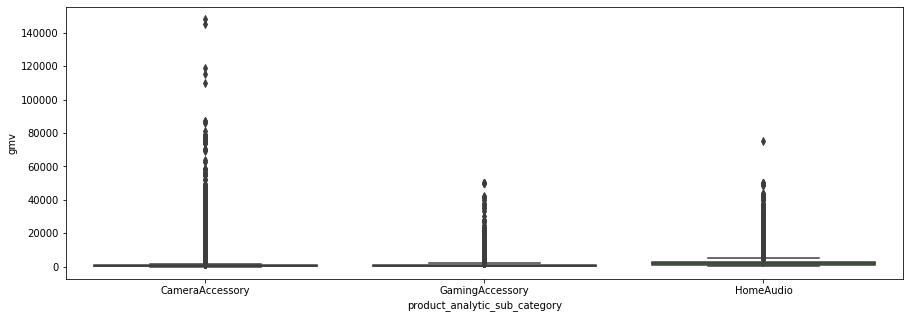

In [51]:
# Let's check outliers in gmv individaully for the three categories
plt.figure(figsize = (15,5))
sns.boxplot(y = 'gmv',data = elec_data, x = 'product_analytic_sub_category')

#### We see a large amount of outliers in the category CameraAccessory & also some in the other two categories. Let's handle them

In [52]:
# Getting the .95 percentile value for gmv when product_analytic_sub_category = 'HomeAudio'
elec_data.loc[(elec_data.product_analytic_sub_category=='HomeAudio')]['gmv'].quantile(0.95)

4706.249999999913

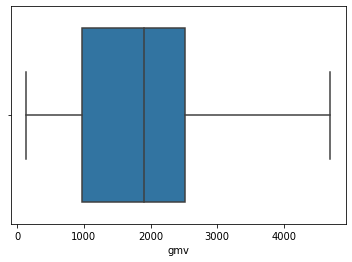

In [53]:
# checking if the outliers get removed from gmv for the category 'HomeAudio' when capped at certain value
sns.boxplot( 
    elec_data.loc[
        (elec_data.product_analytic_sub_category=='HomeAudio') & 
        (elec_data.gmv<4700)
    ]['gmv']
)

In [54]:
# Getting the .95 percentile value for gmv when product_analytic_sub_category = 'GamingAccessory'
elec_data.loc[(elec_data.product_analytic_sub_category=='GamingAccessory')]['gmv'].quantile(0.95)

2890.0

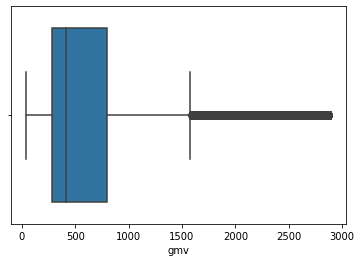

In [55]:
sns.boxplot(
    elec_data.loc[
        (elec_data.product_analytic_sub_category=='GamingAccessory') & 
        (elec_data.gmv<2890)
    ]['gmv']
)

In [56]:
# Getting the .95 percentile value for gmv when product_analytic_sub_category = 'CameraAccessory'
elec_data.loc[(elec_data.product_analytic_sub_category=='CameraAccessory')]['gmv'].quantile(0.95)

6079.0

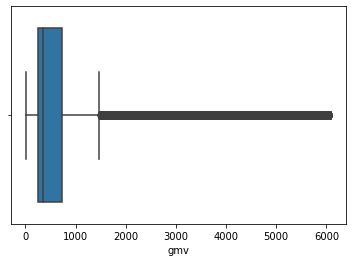

In [57]:
sns.boxplot(
    elec_data.loc[
        (elec_data.product_analytic_sub_category=='CameraAccessory') & 
        (elec_data.gmv<6079)
    ]['gmv']
)

In [58]:
## removing the outliers based on our analysis
camera_data = elec_data.loc[(elec_data.product_analytic_sub_category=='CameraAccessory') & (elec_data.gmv<6079)]
gaming_data = elec_data.loc[(elec_data.product_analytic_sub_category=='GamingAccessory') & (elec_data.gmv<2890)]
homeaudio_data = elec_data.loc[(elec_data.product_analytic_sub_category=='HomeAudio') & (elec_data.gmv<4706)]

In [59]:
## checking the shape of the 3 categories
print(camera_data.shape)
print(gaming_data.shape)
print(homeaudio_data.shape)

(199598, 20)
(172311, 20)
(100755, 20)


In [60]:
## concatinating the three categories to a single dataframe data
elec_data_concat = pd.concat([camera_data, gaming_data, homeaudio_data], axis = 0)

In [61]:
elec_data_concat.shape

(472664, 20)

#### Outliers have been removed, now dropping the columns which are not required

In [62]:
# drop columns which are not required
elec_data_concat.drop(
    ['fsn_id','order_item_id','pincode','product_analytic_super_category','product_analytic_category'], 
    inplace = True, axis = 1
)

In [63]:
#Changing data types for Year, Month & order_week
elec_data_concat['Year'] = elec_data_concat['Year'].astype('int')
elec_data_concat['Month'] = elec_data_concat['Month'].astype('int')
elec_data_concat['order_week'] = elec_data_concat['order_week'].astype('int')

In [64]:
elec_data_concat.head()

,order_date,Year,Month,order_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,order_datetime,order_week
2,2015-10-20,2015,10,2421912925714800,1990.0,1,COD,10,-1040442942046599936,CameraAccessory,CameraTripod,2099,3,2015-10-20 15:45:56,43
3,2015-10-14,2015,10,4416592101738400,1690.0,1,Prepaid,4,-7604960843527140352,CameraAccessory,CameraTripod,2099,3,2015-10-14 12:05:15,42
4,2015-10-17,2015,10,4419525153426400,1618.0,1,Prepaid,6,2894557208345299968,CameraAccessory,CameraTripod,2099,3,2015-10-17 21:25:03,42
5,2015-10-17,2015,10,3419188825145600,3324.0,1,Prepaid,5,-7641546361891739648,CameraAccessory,CameraTripod,4044,5,2015-10-17 12:07:24,42
6,2015-10-16,2015,10,3418428515041500,3695.0,1,Prepaid,6,-71561404148106600,CameraAccessory,CameraTripod,4044,5,2015-10-16 14:59:57,42


### Exploratory Data Analysis - I

In [65]:
elecData = elec_data_concat

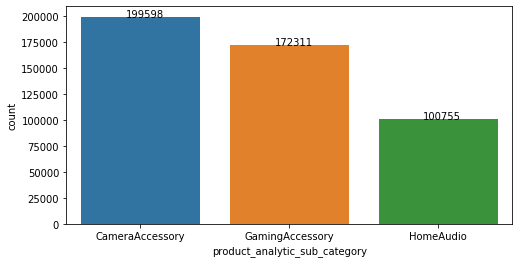

In [66]:
## No of transactions by Sub-Category
plt.figure(figsize = (8,4))
ax = sns.countplot(elecData['product_analytic_sub_category'])
ax.set_xticklabels(ax.get_xticklabels())
sns.set_context(font_scale = 1.5)
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+20))

#### Transaction Count:  CameraAccessory > GamingAccessory > HomeAudio

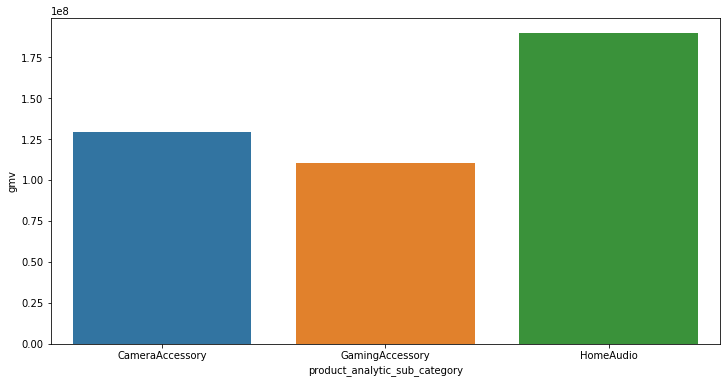

In [67]:
## Total GMV by Sub-Category
plot_gmv = elecData.groupby('product_analytic_sub_category')['gmv'].sum().reset_index()
plt.figure(figsize = (12,6))
ax = sns.barplot(x='product_analytic_sub_category', y='gmv', data=plot_gmv)
ax.set_xticklabels(ax.get_xticklabels())
sns.set_context(font_scale = 1.4)

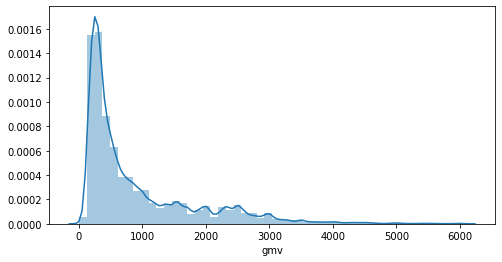

In [68]:
## plotting to check the the frequency of maximum transaction range
plt.figure(figsize = (8,4))
sns.distplot(elecData.gmv )

#### Most of the products range from 0 to 1000

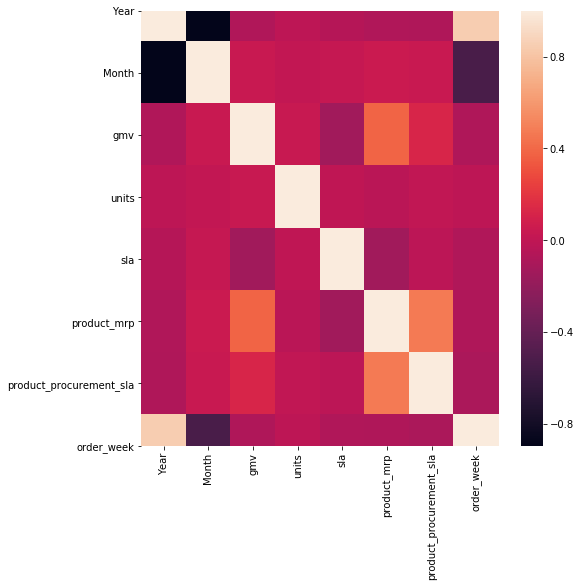

In [69]:
## checking the correlations
plt.figure(figsize = (8,8))
sns.heatmap(elecData.corr())

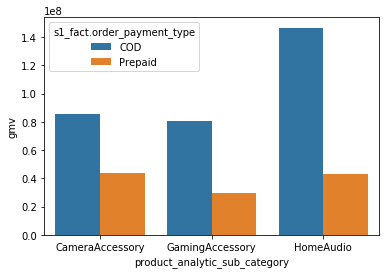

In [70]:
## Total GMV vs Payment Type
GMV_by_Payment_type = elecData.groupby(
  ["s1_fact.order_payment_type","product_analytic_sub_category"]
)['gmv'].sum().reset_index()

sns.barplot(
  x='product_analytic_sub_category', 
  y='gmv', 
  hue="s1_fact.order_payment_type", 
  data=GMV_by_Payment_type
)

#### For COD orders, maximum revenue : HomeAudio > CameraAccessory > GamingAccessory
#### For Prepaid orders, maximum revenue :  CameraAccessory > HomeAudio > GamingAccessory

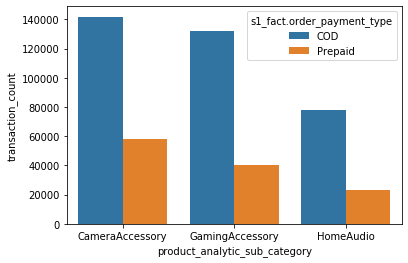

In [71]:
## Order Count vs Payment Type
OC_by_Payment_type = elecData.groupby(
  ["s1_fact.order_payment_type","product_analytic_sub_category"]
)['gmv'].count().reset_index().rename(columns={'gmv':'transaction_count'})

sns.barplot(
  x='product_analytic_sub_category', 
  y='transaction_count', 
  hue="s1_fact.order_payment_type", 
  data=OC_by_Payment_type
)

#### For all the 3 categories, maximum orders are by COD

### Creating dataset for each category

In [72]:
GamingAccessory_data = elecData[(elecData['product_analytic_sub_category']=='GamingAccessory')].drop('product_analytic_sub_category', axis = 1)
CameraAccessory_data = elecData[(elecData['product_analytic_sub_category']=='CameraAccessory')].drop('product_analytic_sub_category', axis = 1)
HomeAudio_data = elecData[(elecData['product_analytic_sub_category']=='HomeAudio')].drop('product_analytic_sub_category', axis = 1)

In [73]:
# checking gamingAccessory_data
GamingAccessory_data.shape

(172311, 14)

In [74]:
# checking CameraAccessory data
CameraAccessory_data.shape

(199598, 14)

In [75]:
# checking HomeAudio data
HomeAudio_data.shape

(100755, 14)

### Creating the KPIS

In [76]:
# Function to map dataframe containing date, week of a given dictionary, for example: holidays, special_days
def createDataFrameFromDictionary(listOfValues, desiredColumnName):
    df = pd.DataFrame(listOfValues)
    df[desiredColumnName] = pd.to_datetime(df[desiredColumnName]).dt.date
    df["total_"+desiredColumnName] = 1
    df['order_week'] = pd.to_datetime(df[desiredColumnName]).dt.week
    df['year'] = pd.to_datetime(df[desiredColumnName]).dt.year
    df['order_week'] = df.apply(lambda x: mapOrderWeek(x['order_week'],x['year']), axis = 1)
    df = df.groupby('order_week').sum()
    df["is_"+desiredColumnName] = 1
    df.drop('year', axis = 1, inplace = True)
    return df

In [77]:
#  Taking the special sale days from the data provided
special_sale_days = {'special_sale_day':["2015-07-18","2015-07-19","2015-08-15",
                  "2015-08-16","2015-08-17","2015-08-28",
                  "2015-08-29","2015-08-30","2015-10-15",
                  "2015-10-16","2015-10-17","2015-11-07","2015-11-08","2015-11-09","2015-11-10",
                  "2015-10-11","2015-10-12","2015-11-13","2015-11-14","2015-12-25","2015-12-26",
                  "2015-12-27","2015-12-28","2015-12-29","2015-12-30","2016-01-01","2016-01-02",
                  "2016-01-03","2016-01-20","2016-01-21","2016-01-22","2016-02-01","2016-02-02",
                  "2016-02-20","2016-02-21","2016-02-14","2016-02-15","2016-03-07","2016-03-08",
                  "2016-03-09","2016-05-25","2016-05-26","2016-05-27"]}
special_sale_df = createDataFrameFromDictionary(special_sale_days,'special_sale_day')

In [78]:
special_sale_df.shape

(16, 2)

In [79]:
special_sale_df.head()

,total_special_sale_day,is_special_sale_day
order_week,,
29,2,1
33,2,1
34,1,1
35,3,1
41,1,1


In [80]:
def createKPIs(df):
#### KPI 1: Payment mode indicator
    df['payment_mode_indicator'] = df['s1_fact.order_payment_type'].apply(lambda x: 0 if x == "COD" else 1)
    
#### KPI 2: Selling price of each product in every transaction
    df['selling_price'] = df['gmv']/df['units']
    
#### KPI 3: Discount offered on the products
    df['discount'] = np.round((df['product_mrp']-df['selling_price'])/df['product_mrp'],2)
    
#### KPI 4: Percent of prepaid orders
    weekly_aggregated_data = df
    weekly_aggregated_data['order_count'] = 1
    weekly_aggregated_data = weekly_aggregated_data.groupby('order_week').sum()
    weekly_aggregated_data['percentage_prepaid_transactions'] = np.round((weekly_aggregated_data.payment_mode_indicator/weekly_aggregated_data.order_count)*100,2)
    weekly_aggregated_data = weekly_aggregated_data.reset_index()[['order_week','percentage_prepaid_transactions']]
    df = pd.merge(df,weekly_aggregated_data, how = 'inner', on = 'order_week')
    return df

In [81]:
def createWeeklyAggregatedKPIs():
    
#### KPI 5: Holidays
    holidays = {'holiday':[
        "2016-01-01", "2016-02-14", "2016-02-16", "2016-03-17", "2016-04-03", "2016-04-06", 
        "2016-05-10", "2016-05-18", "2016-06-21", "2016-06-24", "2015-07-01", "2015-08-03", 
        "2015-09-07", "2015-10-12", "2015-10-31", "2015-11-11", "2015-12-25", "2015-12-26"
    ]}
    holiday_df = createDataFrameFromDictionary(holidays,"holiday")

#### KPI 6: Special sale days
    special_sale_days = {'special_sale_day':[
        "2015-07-18","2015-07-19","2015-08-15","2015-08-16","2015-08-17","2015-08-28",
        "2015-08-29","2015-08-30","2015-10-15","2015-10-16","2015-10-17","2015-11-07",
        "2015-11-08","2015-11-09","2015-11-10","2015-10-11","2015-10-12","2015-11-13",
        "2015-11-14","2015-12-25","2015-12-26","2015-12-27","2015-12-28","2015-12-29",
        "2015-12-30","2016-01-01","2016-01-02","2016-01-03","2016-01-20","2016-01-21",
        "2016-01-22","2016-02-01","2016-02-02","2016-02-20","2016-02-21","2016-02-14",
        "2016-02-15","2016-03-07","2016-03-08","2016-03-09","2016-05-25","2016-05-26",
        "2016-05-27"
    ]}
    special_sale_day_df = createDataFrameFromDictionary(special_sale_days,'special_sale_day')

#### KPI 7: Creating pay_day column
    #Creating order_day column
    pay_days = {'pay_days':[
        "2015-07-01","2015-07-15","2015-08-01","2015-08-15",
        "2015-09-01","2015-09-15","2015-10-01","2015-10-15","2015-11-01",
        "2015-11-15","2015-12-01","2015-12-15","2016-01-01","2016-01-15",
        "2016-02-01","2016-02-15","2016-03-01","2016-03-15","2016-04-01",
        "2016-04-15","2016-05-01","2016-05-15","2016-06-01","2016-06-15"
    ]}
    pay_days_df = createDataFrameFromDictionary(pay_days,'pay_days')
    final_df = pd.concat([holiday_df, special_sale_day_df, pay_days_df],axis = 1)
    return final_df.fillna(0).astype('int')

In [82]:
createWeeklyAggregatedKPIs().head()

,total_holiday,is_holiday,total_special_sale_day,is_special_sale_day,total_pay_days,is_pay_days
order_week,,,,,,
27,1,1,0,0,1,1
29,0,0,2,1,1,1
31,0,0,0,0,1,1
32,1,1,0,0,0,0
33,0,0,2,1,1,1


In [83]:
# Adding the KPIs to the dataframes of each category
GamingAccessory_data_KPIs = createKPIs(GamingAccessory_data)
CameraAccessory_data_KPIs = createKPIs(CameraAccessory_data)
HomeAudio_data_KPIs = createKPIs(HomeAudio_data)

In [84]:
print(HomeAudio_data_KPIs.shape)
print(GamingAccessory_data_KPIs.shape)
print(CameraAccessory_data_KPIs.shape)

(100755, 19)
(172311, 19)
(199598, 19)


### Creating KPI for Prepaid/COD transactions for visualisation

In [85]:
# Creating KPIs for Prepaid Count, COD Count & Percent Online Orders for GamingAccessory_data_KPIs
cod_cnt = GamingAccessory_data_KPIs.loc[
    GamingAccessory_data_KPIs['s1_fact.order_payment_type'] == "COD"
].groupby('order_week')['s1_fact.order_payment_type'].count().reset_index().rename(
    columns={'s1_fact.order_payment_type':'COD_count'}
)


prepaid_cnt = GamingAccessory_data_KPIs.loc[
    GamingAccessory_data_KPIs['s1_fact.order_payment_type'] == "Prepaid"
].groupby('order_week')['s1_fact.order_payment_type'].count().reset_index().rename(
    columns={'s1_fact.order_payment_type':'Prepaid_count'}
)


online_orders_GA = pd.merge(
    cod_cnt,
    prepaid_cnt,
    on = "order_week", 
    how = "outer"
).fillna(0)

online_orders_GA["pct_online_transactions"] = (
    online_orders_GA["Prepaid_count"]/
    (online_orders_GA["Prepaid_count"]+online_orders_GA["COD_count"])
).round(2)

In [86]:
# Creating KPIs for Prepaid Count, COD Count & Percent Online Orders for CameraAccessory_data_KPIs
cod_cnt = CameraAccessory_data_KPIs.loc[
    CameraAccessory_data_KPIs['s1_fact.order_payment_type'] == "COD"
].groupby('order_week')['s1_fact.order_payment_type'].count().reset_index().rename(
    columns={'s1_fact.order_payment_type':'COD_count'}
)


prepaid_cnt = CameraAccessory_data_KPIs.loc[
    CameraAccessory_data_KPIs['s1_fact.order_payment_type'] == "Prepaid"
].groupby('order_week')['s1_fact.order_payment_type'].count().reset_index().rename(
    columns={'s1_fact.order_payment_type':'Prepaid_count'}
)


online_orders_CA = pd.merge(
    cod_cnt,
    prepaid_cnt,
    on = "order_week", 
    how = "outer"
).fillna(0)

online_orders_CA["pct_online_transactions"] = (
    online_orders_CA["Prepaid_count"]/
    (online_orders_CA["Prepaid_count"]+online_orders_CA["COD_count"])
).round(2)

In [87]:
# Creating KPIs for Prepaid Count, COD Count & Percent Online Orders
cod_cnt = HomeAudio_data_KPIs.loc[
    HomeAudio_data_KPIs['s1_fact.order_payment_type'] == "COD"
].groupby('order_week')['s1_fact.order_payment_type'].count().reset_index().rename(
    columns={'s1_fact.order_payment_type':'COD_count'}
)


prepaid_cnt = HomeAudio_data_KPIs.loc[
    HomeAudio_data_KPIs['s1_fact.order_payment_type'] == "Prepaid"
].groupby('order_week')['s1_fact.order_payment_type'].count().reset_index().rename(
    columns={'s1_fact.order_payment_type':'Prepaid_count'}
)


online_orders_HA = pd.merge(
    cod_cnt,
    prepaid_cnt,
    on = "order_week", 
    how = "outer"
).fillna(0)

online_orders_HA["pct_online_transactions"] = (
    online_orders_HA["Prepaid_count"]/
    (online_orders_HA["Prepaid_count"]+online_orders_HA["COD_count"])
).round(2)

In [88]:
GamingAccessory_data_KPIs.head()

,order_date,Year,Month,order_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,product_analytic_vertical,product_mrp,product_procurement_sla,order_datetime,order_week,payment_mode_indicator,selling_price,discount,order_count,percentage_prepaid_transactions
0,2015-10-14,2015,10,1416985339691600,2750.0,1,COD,7,9041577304631719936,GamePad,3999,5,2015-10-14 22:54:54,42,0,2750.0,0.31,1,20.17
1,2015-10-17,2015,10,1419414998353400,2609.0,1,Prepaid,5,-4824142736471789568,GamePad,3999,5,2015-10-17 18:21:43,42,1,2609.0,0.35,1,20.17
2,2015-10-16,2015,10,4417730112316700,2750.0,1,Prepaid,7,2297791966161220096,GamePad,3999,5,2015-10-16 04:02:08,42,1,2750.0,0.31,1,20.17
3,2015-10-14,2015,10,2416992735588600,1300.0,1,COD,5,-9018990134678490112,GamePad,3500,1,2015-10-14 23:19:36,42,0,1300.0,0.63,1,20.17
4,2015-10-15,2015,10,3417267793172600,1300.0,1,COD,9,-8494929005431940096,GamePad,3500,1,2015-10-15 06:44:29,42,0,1300.0,0.63,1,20.17


In [89]:
CameraAccessory_data_KPIs.head()

,order_date,Year,Month,order_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,product_analytic_vertical,product_mrp,product_procurement_sla,order_datetime,order_week,payment_mode_indicator,selling_price,discount,order_count,percentage_prepaid_transactions
0,2015-10-20,2015,10,2421912925714800,1990.0,1,COD,10,-1040442942046599936,CameraTripod,2099,3,2015-10-20 15:45:56,43,0,1990.0,0.05,1,20.81
1,2015-10-25,2015,10,4426481574167600,3695.0,1,COD,7,-7809156068961630208,CameraTripod,4044,5,2015-10-25 22:52:34,43,0,3695.0,0.09,1,20.81
2,2015-10-19,2015,10,2420828677270800,3695.0,1,COD,8,-8990324579055120384,CameraTripod,4044,5,2015-10-19 09:37:06,43,0,3695.0,0.09,1,20.81
3,2015-10-22,2015,10,4423471780328000,4499.0,1,Prepaid,6,3951369679301279744,CameraBag,5999,0,2015-10-22 11:07:53,43,1,4499.0,0.25,1,20.81
4,2015-10-23,2015,10,3424658116375400,3789.0,1,COD,6,-8715611406883560448,CameraBag,4700,0,2015-10-23 20:03:01,43,0,3789.0,0.19,1,20.81


In [90]:
HomeAudio_data_KPIs.head()

,order_date,Year,Month,order_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,product_analytic_vertical,product_mrp,product_procurement_sla,order_datetime,order_week,payment_mode_indicator,selling_price,discount,order_count,percentage_prepaid_transactions
0,2015-10-08,2015,10,1411753777965600,3700.0,1,COD,3,8628124667745449984,HomeAudioSpeaker,4599,0,2015-10-08 21:34:04,41,0,3700.0,0.20,1,18.41
1,2015-10-11,2015,10,2414104375842400,3700.0,1,COD,5,5684936202558919680,HomeAudioSpeaker,4599,0,2015-10-11 16:54:52,41,0,3700.0,0.20,1,18.41
2,2015-10-08,2015,10,4411629266828400,3700.0,1,COD,3,-1123729755469779968,HomeAudioSpeaker,4599,0,2015-10-08 18:06:04,41,0,3700.0,0.20,1,18.41
3,2015-10-09,2015,10,4412152259651800,1970.0,1,COD,8,-1350434790011350016,HomeAudioSpeaker,4999,5,2015-10-09 08:55:52,41,0,1970.0,0.61,1,18.41
4,2015-10-10,2015,10,3413199701716100,1970.0,1,Prepaid,6,2453367163355780096,HomeAudioSpeaker,4999,5,2015-10-10 13:43:33,41,1,1970.0,0.61,1,18.41


###  Creating KPIs for Product Analytical Vertical

####  CameraAccessory

In [91]:
# creating KPIs for product analytical vertical for CameraAccessory_data_KPIs
prd_vert_CA = CameraAccessory_data_KPIs.groupby(
    [
        'order_week',
        'product_analytic_vertical'
    ]
)['units'].sum().reset_index()


CA_prdvr_KPI = prd_vert_CA.pivot_table(
    index='order_week', 
    columns='product_analytic_vertical', 
    values='units', 
    aggfunc=np.sum
).fillna("0").reset_index()


cols = CA_prdvr_KPI.columns
CA_prdvr_KPI[cols] = CA_prdvr_KPI[cols].apply(pd.to_numeric, errors='coerce')
CameraAccessory_data_KPIs = CameraAccessory_data_KPIs.drop(['product_analytic_vertical'],axis=1)

In [92]:
# counting products sold in each vertical
prd_vrt_units_sold = prd_vert_CA.groupby('product_analytic_vertical')[
    'units'
].sum().reset_index().sort_values(by=['units'],ascending=False)
prd_vrt_units_sold.head()

,product_analytic_vertical,units
15,Flash,48003
3,CameraBattery,35974
12,CameraTripod,31268
17,Lens,22800
2,CameraBag,15279


In [93]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10.0, 6.0)
 
squarify.plot(sizes=prd_vrt_units_sold['units'], label=prd_vrt_units_sold['product_analytic_vertical'], alpha=.6 )
plt.axis('off')
plt.show()

NameError: name 'squarify' is not defined

- Highest sold Item is Flash followed by Camera Battery and Camera Tripod

In [94]:
# creating KPIs for product analytical vertical GamingAccessory_data_KPIs
prd_vert_GA = GamingAccessory_data_KPIs.groupby(
    [
        'order_week',
        'product_analytic_vertical'
    ]
)['units'].sum().reset_index()


GA_prdvr_KPI = prd_vert_GA.pivot_table(
    index='order_week', 
    columns='product_analytic_vertical', 
    values='units', 
    aggfunc=np.sum
).fillna("0")


cols = GA_prdvr_KPI.columns
GA_prdvr_KPI[cols] = GA_prdvr_KPI[cols].apply(pd.to_numeric, errors='coerce')
GamingAccessory_data_KPIs = GamingAccessory_data_KPIs.drop(['product_analytic_vertical'],axis=1)

In [95]:
# creating number of products sold for each vertical & plotting
prd_vrt_units_sold = prd_vert_GA.groupby('product_analytic_vertical')[
    'units'
].sum().reset_index().sort_values(by=['units'],ascending=False)

In [96]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10.0, 6.0)
 
squarify.plot(sizes=prd_vrt_units_sold['units'], label=prd_vrt_units_sold['product_analytic_vertical'], alpha=.6 )
plt.axis('off')
plt.show()

NameError: name 'squarify' is not defined

- Highest sold item is Gaming headset followed by Game pad and Gaming Mouse

In [97]:
# creating KPIs for product analytical vertical for HomeAudio_data_KPIs
prd_vert_HA = HomeAudio_data_KPIs.groupby(
    [
        'order_week',
        'product_analytic_vertical'
    ]
)['units'].sum().reset_index()


HA_prdvr_KPI = prd_vert_HA.pivot_table(
    index='order_week', 
    columns='product_analytic_vertical', 
    values='units', 
    aggfunc=np.sum
).fillna("0").reset_index()

cols = HA_prdvr_KPI.columns
HA_prdvr_KPI[cols] = HA_prdvr_KPI[cols].apply(pd.to_numeric, errors='coerce')
HomeAudio_data_KPIs = HomeAudio_data_KPIs.drop(['product_analytic_vertical'],axis=1)

In [98]:
# creating number of products sold for each vertical & plotting
prd_vrt_units_sold = prd_vert_HA.groupby('product_analytic_vertical')[
    'units'
].sum().reset_index().sort_values(by=['units'],ascending=False)

In [99]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10.0, 6.0)
 
squarify.plot(sizes=prd_vrt_units_sold['units'], label=prd_vrt_units_sold['product_analytic_vertical'], alpha=.6 )
plt.axis('off')
plt.show()

NameError: name 'squarify' is not defined

- Highest sold item is Home Audio Speaker followed by FM radio

In [100]:
### KPI 8: Including NPS & Stock Index 

# reading media data from the excel file
nps_data = pd.read_excel("Media data and other information.xlsx", sheet_name = 'Monthly NPS Score', header = 1).T.reset_index()

nps_data = nps_data.loc[1:].rename(
    columns={0:'NPS', 1: 'Stock Index'}
).reset_index()

nps_data = nps_data.astype({'NPS': 'float64'})


# creating Month & Year columns to merge with transactional data
nps_data['Year'] = nps_data['index'].apply(lambda x: int("20"+x.split("'")[1]))
nps_data['Month'] = nps_data['index'].apply(lambda x: x.split("'")[0][:3])


# create mapping to convert month names to month number
import calendar

d = dict((v,k) for k,v in enumerate(calendar.month_abbr))

nps_data.Month = nps_data.Month.apply(lambda x: d.get(x))

#Drop index column from media_data
nps_data.drop(['index', 'level_0'], inplace = True, axis = 1)
nps_data

,NPS,Stock Index,Year,Month
0,54.599588,1177,2015,7
1,59.987101,1206,2015,8
2,46.925419,1101,2015,9
3,44.398389,1210,2015,10
4,47.000000,1233,2015,11
5,45.800000,1038,2015,12
6,47.093031,1052,2016,1
7,50.327406,1222,2016,2
8,49.020550,1015,2016,3
9,51.827605,1242,2016,4


In [101]:
nps_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 4 columns):
NPS            12 non-null float64
Stock Index    12 non-null object
Year           12 non-null int64
Month          12 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 512.0+ bytes


In [102]:
# Adding NPS KPI to each of the dataframes
GamingAccessory_data_KPIs = pd.merge(nps_data,GamingAccessory_data_KPIs,on=['Month','Year'],how='inner')
CameraAccessory_data_KPIs = pd.merge(nps_data,CameraAccessory_data_KPIs,on=['Month','Year'],how='inner')
HomeAudio_data_KPIs = pd.merge(nps_data,HomeAudio_data_KPIs,on=['Month','Year'],how='inner')

In [103]:
# Creating dataframes for plots for each of the category
GamingAccessory_data_KPIs_for_plot = GamingAccessory_data_KPIs
GamingAccessory_data_KPIs_for_plot['analytic_vertical'] = "Gaming Accessory"
CameraAccessory_data_KPIs_for_plot = CameraAccessory_data_KPIs
CameraAccessory_data_KPIs_for_plot['analytic_vertical'] = "Camera Accessory"
HomeAudio_data_KPIs_for_plot = HomeAudio_data_KPIs
HomeAudio_data_KPIs_for_plot['analytic_vertical'] = "Home Audio"

all_data_kpi = pd.concat(
    [
        GamingAccessory_data_KPIs_for_plot, 
        CameraAccessory_data_KPIs_for_plot, 
        HomeAudio_data_KPIs_for_plot
    ], axis = 0
)

### Weekly Aggregation of data

#### Camera Accessory

In [104]:
CameraAccessory_data_KPIs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199598 entries, 0 to 199597
Data columns (total 21 columns):
NPS                                199598 non-null float64
Stock Index                        199598 non-null object
Year                               199598 non-null int64
Month                              199598 non-null int64
order_date                         199598 non-null object
order_id                           199598 non-null object
gmv                                199598 non-null float64
units                              199598 non-null int64
s1_fact.order_payment_type         199598 non-null object
sla                                199598 non-null int64
cust_id                            199598 non-null object
product_mrp                        199598 non-null int64
product_procurement_sla            199598 non-null int64
order_datetime                     199598 non-null datetime64[ns]
order_week                         199598 non-null int64
payment_mode_ind

In [105]:
#Camera data  - Aggregating weekly some features being summed up & for some taking mean
CameraAccessory_data_sum = CameraAccessory_data_KPIs[['gmv','units','order_week']].groupby('order_week').sum()

CameraAccessory_data_mean = CameraAccessory_data_KPIs[
    [
        'sla','product_procurement_sla','order_week',
        'product_mrp','selling_price','discount','NPS'
    ]
].groupby('order_week').mean()

CameraAccessory_data_count = CameraAccessory_data_KPIs[
    [
        'order_id',
        'order_week'
    ]
].groupby('order_week').count().rename(columns={'order_id':'total_transactions'})

final_camera_data = pd.concat([
    CameraAccessory_data_sum, 
    CameraAccessory_data_mean,
    CameraAccessory_data_count
], axis = 1).reset_index()

In [106]:
final_camera_data.head()

,order_week,gmv,units,sla,product_procurement_sla,product_mrp,selling_price,discount,NPS,total_transactions
0,27,15375.0,25,2.280000,2.960000,1456.840000,615.000000,0.525600,54.599588,25
1,28,2019042.0,2752,7.156274,2.742586,1646.428137,751.233460,0.462194,54.599588,2630
2,29,2249245.0,2917,6.491321,2.764789,1630.936238,783.509033,0.465349,54.599588,2823
3,30,2105858.0,2888,6.488138,2.831776,1560.504313,740.930625,0.455913,54.599588,2782
4,31,1426134.0,1932,6.470684,2.777959,1524.232356,756.820304,0.450456,54.605438,1842


In [107]:
# merging with the weekly aggregate KPIs i.e. total_paydays, total_holidays, is_payday, is_holiday, total_special_days, is_special_day
final_camera_data = pd.merge(
    final_camera_data, 
    createWeeklyAggregatedKPIs().reset_index(), on = 'order_week', how = 'left'
).fillna(0)

final_camera_data.shape

(52, 16)

In [108]:
#Merging with Prepaid/Cod KPI
final_camera_data = pd.merge(
    final_camera_data,
    online_orders_CA,
    on = "order_week", 
    how = "left"
)

final_camera_data.shape

(52, 19)

In [109]:
#Merging with Product Analytical Vertical KPI
final_camera_data = pd.merge(
    final_camera_data,
    CA_prdvr_KPI,
    on=['order_week'],
    how='left'
)

final_camera_data.shape

(52, 41)

In [110]:
final_camera_data.columns

Index(['order_week', 'gmv', 'units', 'sla', 'product_procurement_sla',
       'product_mrp', 'selling_price', 'discount', 'NPS', 'total_transactions',
       'total_holiday', 'is_holiday', 'total_special_sale_day',
       'is_special_sale_day', 'total_pay_days', 'is_pay_days', 'COD_count',
       'Prepaid_count', 'pct_online_transactions', 'Binoculars',
       'CameraAccessory', 'CameraBag', 'CameraBattery', 'CameraBatteryCharger',
       'CameraBatteryGrip', 'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing',
       'CameraMicrophone', 'CameraMount', 'CameraRemoteControl',
       'CameraTripod', 'ExtensionTube', 'Filter', 'Flash', 'FlashShoeAdapter',
       'Lens', 'ReflectorUmbrella', 'Softbox', 'Strap', 'Telescope'],
      dtype='object')

#### Gaming Accessory

In [111]:
#GamingAccessory Data - Aggregating weekly some features being summed up & for some taking mean
GamingAccessory_data_sum = GamingAccessory_data_KPIs[['gmv','units','order_week']].groupby('order_week').sum()
GamingAccessory_data_mean = GamingAccessory_data_KPIs[
    [
        'sla','product_procurement_sla','order_week',
        'product_mrp','selling_price','discount','NPS'
    ]
].groupby('order_week').mean()


GamingAccessory_data_count = GamingAccessory_data_KPIs[
    ['order_id','order_week']
].groupby('order_week').count().rename(columns={'order_id':'total_transactions'})


final_gaming_data = pd.concat([GamingAccessory_data_sum, GamingAccessory_data_mean,GamingAccessory_data_count], axis = 1).reset_index()

In [112]:
#Merging with the weekly aggregate KPIs i.e. total_paydays, total_holidays, is_payday, is_holiday, total_special_days, is_special_day
final_gaming_data = pd.merge(
    final_gaming_data, 
    createWeeklyAggregatedKPIs().reset_index(), 
    on = 'order_week', 
    how = 'left'
).fillna(0)

final_gaming_data.shape

(53, 16)

In [113]:
#Merging with Prepaid/COD KPI
final_gaming_data = pd.merge(final_gaming_data,online_orders_GA,on = "order_week", how = "left")
final_gaming_data.shape

(53, 19)

In [114]:
#Merging with Product Analytical Vertical KPI
final_gaming_data = pd.merge(final_gaming_data,GA_prdvr_KPI,on=['order_week'],how='left')
final_gaming_data.shape

(53, 34)

In [115]:
final_gaming_data.columns

Index(['order_week', 'gmv', 'units', 'sla', 'product_procurement_sla',
       'product_mrp', 'selling_price', 'discount', 'NPS', 'total_transactions',
       'total_holiday', 'is_holiday', 'total_special_sale_day',
       'is_special_sale_day', 'total_pay_days', 'is_pay_days', 'COD_count',
       'Prepaid_count', 'pct_online_transactions', 'CoolingPad',
       'GameControlMount', 'GamePad', 'GamingAccessoryKit', 'GamingAdapter',
       'GamingChargingStation', 'GamingHeadset', 'GamingKeyboard',
       'GamingMemoryCard', 'GamingMouse', 'GamingMousePad', 'GamingSpeaker',
       'JoystickGamingWheel', 'MotionController', 'TVOutCableAccessory'],
      dtype='object')

#### Home Audio

In [116]:
# Home Audio data
HomeAudio_data_sum = HomeAudio_data_KPIs[['gmv','units','order_week']].groupby('order_week').sum()

HomeAudio_data_mean = HomeAudio_data_KPIs[
    [
        'sla','product_procurement_sla','order_week','product_mrp',
        'selling_price','discount','NPS'
    ]
].groupby('order_week').mean()


HomeAudio_data_count = HomeAudio_data_KPIs[
    ['order_id','order_week']
].groupby('order_week').count().rename(columns={'order_id':'total_transactions'})


final_home_audio_data = pd.concat([
    HomeAudio_data_sum, 
    HomeAudio_data_mean,
    HomeAudio_data_count
], axis = 1).reset_index()

In [117]:
#Merging with the weekly aggregate KPIs i.e. total_paydays, total_holidays, is_payday, is_holiday, total_special_days, is_special_day
final_home_audio_data = pd.merge(
    final_home_audio_data, 
    createWeeklyAggregatedKPIs().reset_index(), 
    on = 'order_week', 
    how = 'left'
).fillna(0)

final_home_audio_data.shape

(50, 16)

In [118]:
#Merging with Prepaid/COD KPI
final_home_audio_data = pd.merge(final_home_audio_data,online_orders_HA,on = "order_week", how = "left")
final_home_audio_data.shape

(50, 19)

In [119]:
#Merging with Product Analytical Vertical KPI
final_home_audio_data = pd.merge(final_home_audio_data,HA_prdvr_KPI,on=['order_week'],how='left')
final_home_audio_data.shape

(50, 29)

In [120]:
final_home_audio_data.columns

Index(['order_week', 'gmv', 'units', 'sla', 'product_procurement_sla',
       'product_mrp', 'selling_price', 'discount', 'NPS', 'total_transactions',
       'total_holiday', 'is_holiday', 'total_special_sale_day',
       'is_special_sale_day', 'total_pay_days', 'is_pay_days', 'COD_count',
       'Prepaid_count', 'pct_online_transactions', 'BoomBox', 'DJController',
       'Dock', 'DockingStation', 'FMRadio', 'HiFiSystem', 'HomeAudioSpeaker',
       'SlingBox', 'SoundMixer', 'VoiceRecorder'],
      dtype='object')

### KPI 9: Media Investment data

In [121]:
# reading the media data from the provided file
media_investment = pd.read_excel("Media data and other information.xlsx", sheet_name = 'Media Investment', header = 2)
media_investment

,Unnamed: 0,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
0,NaN,2015.0,7.0,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,NaN,NaN
1,NaN,2015.0,8.0,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,NaN,NaN
2,NaN,2015.0,9.0,96.254380,3.879504,1.356528,62.787651,0.610292,16.379990,5.038266,6.202149,NaN,NaN
3,NaN,2015.0,10.0,170.156297,6.144711,12.622480,84.672532,3.444075,24.371778,6.973711,31.927011,NaN,NaN
4,NaN,2015.0,11.0,51.216220,4.220630,1.275469,14.172116,0.168633,19.561574,6.595767,5.222032,NaN,NaN
5,NaN,2015.0,12.0,106.745312,5.397502,3.063360,56.705419,1.067307,22.503756,6.826938,11.181030,NaN,NaN
6,NaN,2016.0,1.0,74.196000,4.380000,0.456000,4.200000,0.900000,22.900000,7.370000,4.200000,2.70,27.090000
7,NaN,2016.0,2.0,48.052000,2.586008,1.912651,11.725555,0.596771,19.892366,6.465019,4.873630,NaN,NaN
8,NaN,2016.0,3.0,100.024621,9.300000,2.100000,41.590000,0.370000,18.437818,6.217667,5.193591,0.87,15.945545
9,NaN,2016.0,4.0,56.848241,5.205196,0.871892,24.308354,0.034876,16.514510,5.693456,4.219958,NaN,NaN


In [122]:
# formatting the dataframe in the required format i.e. removing the extra rows & columns
media_investment = media_investment.iloc[:-4].reset_index()
media_investment.drop('index', inplace = True, axis = 1)

In [123]:
# converting columns year & month in int type
media_investment['Year']  = media_investment['Year'] .astype('int')
media_investment['Month']  = media_investment['Month'] .astype('int')

In [124]:
# filling NaN values as 0 assuming that the investment done in respective area was 0
media_investment= media_investment.fillna(0)

In [125]:
media_investment.drop(['Unnamed: 0'], inplace = True, axis = 1)

In [126]:
media_investment

,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
0,2015,7,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,0.00,0.000000
1,2015,8,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,0.00,0.000000
2,2015,9,96.254380,3.879504,1.356528,62.787651,0.610292,16.379990,5.038266,6.202149,0.00,0.000000
3,2015,10,170.156297,6.144711,12.622480,84.672532,3.444075,24.371778,6.973711,31.927011,0.00,0.000000
4,2015,11,51.216220,4.220630,1.275469,14.172116,0.168633,19.561574,6.595767,5.222032,0.00,0.000000
5,2015,12,106.745312,5.397502,3.063360,56.705419,1.067307,22.503756,6.826938,11.181030,0.00,0.000000
6,2016,1,74.196000,4.380000,0.456000,4.200000,0.900000,22.900000,7.370000,4.200000,2.70,27.090000
7,2016,2,48.052000,2.586008,1.912651,11.725555,0.596771,19.892366,6.465019,4.873630,0.00,0.000000
8,2016,3,100.024621,9.300000,2.100000,41.590000,0.370000,18.437818,6.217667,5.193591,0.87,15.945545
9,2016,4,56.848241,5.205196,0.871892,24.308354,0.034876,16.514510,5.693456,4.219958,0.00,0.000000


In [127]:
# creating a mapping of the Months & number of weeks in order to find the media data weekly for each of the monts
number_of_weeks = {'Month':[1,2,3,4,5,6,7,8,9,10,11,12], 'number_of_weeks':[4,4,5,4,4,5,4,4,5,4,4,5]}
number_of_weeks_df = pd.DataFrame(number_of_weeks)
number_of_weeks_df

,Month,number_of_weeks
0,1,4
1,2,4
2,3,5
3,4,4
4,5,4
5,6,5
6,7,4
7,8,4
8,9,5
9,10,4


In [128]:
# merging the media_investment data with dataframe containing the mapping of months & number of weeks in that month
media_investment = pd.merge(media_investment,number_of_weeks_df, on = 'Month', how = 'inner')
media_investment

,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other,number_of_weeks
0,2015,7,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,0.00,0.000000,4
1,2015,8,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,0.00,0.000000,4
2,2015,9,96.254380,3.879504,1.356528,62.787651,0.610292,16.379990,5.038266,6.202149,0.00,0.000000,5
3,2015,10,170.156297,6.144711,12.622480,84.672532,3.444075,24.371778,6.973711,31.927011,0.00,0.000000,4
4,2015,11,51.216220,4.220630,1.275469,14.172116,0.168633,19.561574,6.595767,5.222032,0.00,0.000000,4
5,2015,12,106.745312,5.397502,3.063360,56.705419,1.067307,22.503756,6.826938,11.181030,0.00,0.000000,5
6,2016,1,74.196000,4.380000,0.456000,4.200000,0.900000,22.900000,7.370000,4.200000,2.70,27.090000,4
7,2016,2,48.052000,2.586008,1.912651,11.725555,0.596771,19.892366,6.465019,4.873630,0.00,0.000000,4
8,2016,3,100.024621,9.300000,2.100000,41.590000,0.370000,18.437818,6.217667,5.193591,0.87,15.945545,5
9,2016,4,56.848241,5.205196,0.871892,24.308354,0.034876,16.514510,5.693456,4.219958,0.00,0.000000,4


In [129]:
# Calculating the final media_investments weekly by dividing the value in a month with the respecitve number_of_weeks in the month
media_investment['TV']  = media_investment['TV']/media_investment['number_of_weeks']
media_investment['Digital']  = media_investment['Digital']/media_investment['number_of_weeks']
media_investment['Sponsorship']  = media_investment['Sponsorship']/media_investment['number_of_weeks']
media_investment['Content Marketing']  = media_investment['Content Marketing']/media_investment['number_of_weeks']
media_investment['Online marketing']  = media_investment['Online marketing']/media_investment['number_of_weeks']
media_investment[' Affiliates']  = media_investment[' Affiliates']/media_investment['number_of_weeks']
media_investment['SEM']  = media_investment['SEM']/media_investment['number_of_weeks']
media_investment['Radio']  = media_investment['Radio']/media_investment['number_of_weeks']
media_investment['Other']  = media_investment['Other']/media_investment['number_of_weeks']

In [130]:
# Getting unique order_week, month & year present in the original dataframe
order_week_data = elecData[['order_week',"Month","Year"]].drop_duplicates(keep = 'first', subset = None).reset_index().drop('index', axis = 1).sort_values(by = 'order_week')
order_week_data = order_week_data.sort_values(by = ['order_week','Month']).drop_duplicates(keep = 'last', subset = 'order_week')
order_week_data

,order_week,Month,Year
53,27,7,2015
51,28,7,2015
49,29,7,2015
52,30,7,2015
55,31,8,2015
60,32,8,2015
61,33,8,2015
62,34,8,2015
15,35,8,2015
58,36,9,2015


In [131]:
# Merging the media_investment_data with the order_week_data to add order_week into this dataframe for final merging with other dataframes containing the KPIs
media_investment_weekwise = pd.merge(
    order_week_data, 
    media_investment, 
    on = ["Month","Year"], 
    how = "inner"
).drop('number_of_weeks', axis =1)
media_investment_weekwise.head()

,order_week,Month,Year,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
0,27,7,2015,17.061775,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0
1,28,7,2015,17.061775,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0
2,29,7,2015,17.061775,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0
3,30,7,2015,17.061775,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0
4,31,8,2015,5.064306,0.001610,0.319518,0.265833,0.000002,0.032311,0.018421,0.628382,0.0,0.0


In [132]:
#Checking the columns
media_investment_weekwise.columns

Index(['order_week', 'Month', 'Year', 'Total Investment', 'TV', 'Digital',
       'Sponsorship', 'Content Marketing', 'Online marketing', ' Affiliates',
       'SEM', 'Radio', 'Other'],
      dtype='object')

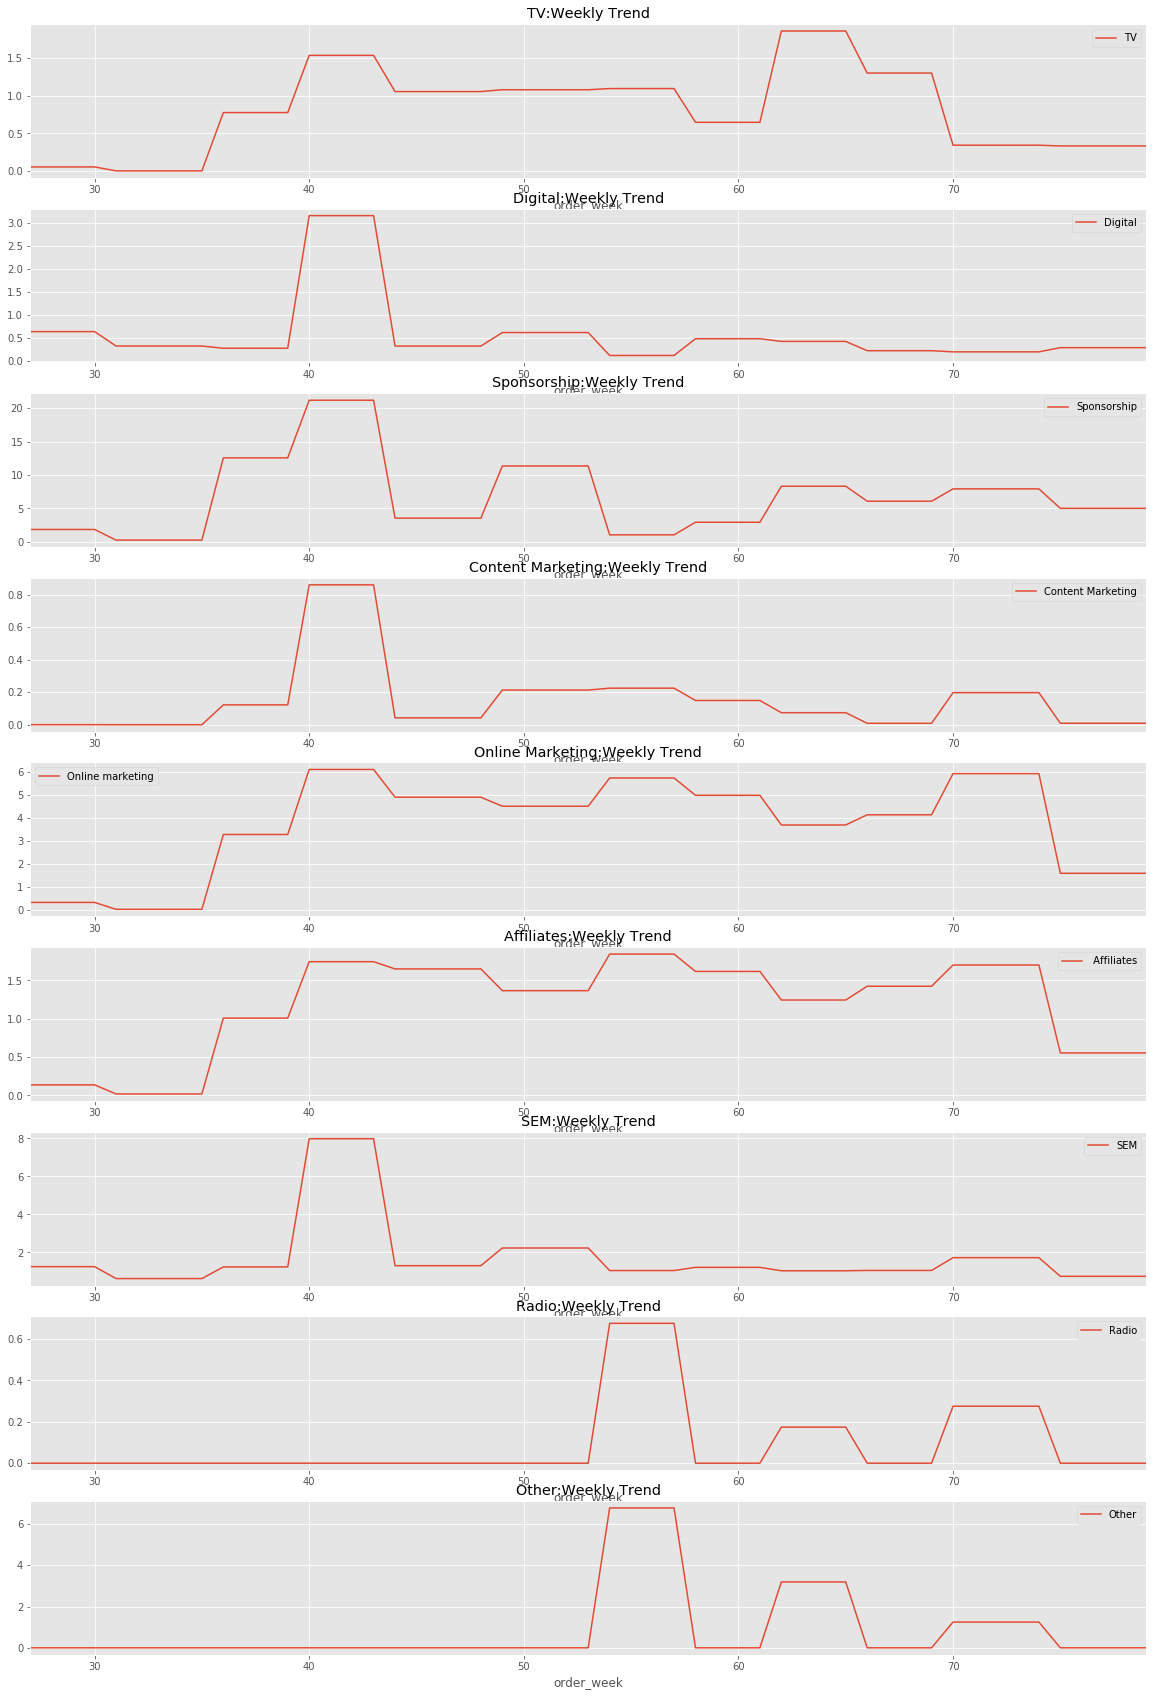

In [133]:
# Lets Analyze the Weekly Spends on different channels
fig = plt.figure(figsize=(20,30))

ax1 = fig.add_subplot(911)
ax1.set_title('TV:Weekly Trend')
ax2 = fig.add_subplot(912)
ax2.set_title('Digital:Weekly Trend')
ax3 = fig.add_subplot(913)
ax3.set_title('Sponsorship:Weekly Trend')
ax4 = fig.add_subplot(914)
ax4.set_title('Content Marketing:Weekly Trend')
ax5 = fig.add_subplot(915)
ax5.set_title('Online Marketing:Weekly Trend')
ax6 = fig.add_subplot(916)
ax6.set_title('Affiliates:Weekly Trend')
ax7 = fig.add_subplot(917)
ax7.set_title('SEM:Weekly Trend')
ax8 = fig.add_subplot(918)
ax8.set_title('Radio:Weekly Trend')
ax9 = fig.add_subplot(919)
ax9.set_title('Other:Weekly Trend')

media_investment_weekwise.plot(x= 'order_week',y=['TV'],ax = ax1)
print()
media_investment_weekwise.plot(x= 'order_week',y=['Digital'],ax = ax2)
print()
media_investment_weekwise.plot(x= 'order_week',y=['Sponsorship'],ax = ax3)
print()
media_investment_weekwise.plot(x= 'order_week',y=['Content Marketing'],ax = ax4)
print()
media_investment_weekwise.plot(x= 'order_week',y=['Online marketing'],ax = ax5)
print()
media_investment_weekwise.plot(x= 'order_week',y=[' Affiliates'],ax = ax6)
print()
media_investment_weekwise.plot(x= 'order_week',y=['SEM'],ax = ax7)
print()
media_investment_weekwise.plot(x= 'order_week',y=['Radio'],ax = ax8)
print()
media_investment_weekwise.plot(x= 'order_week',y=['Other'],ax = ax9)

#### The maximum investments occurred between week 39-45 for most channels, Maximum investments was done through Sponsorship media


In [134]:
#Creating function to create Adstocks at the adstock_rate which will be passed on to this function
def getAdStockValues(media_investment_df,col_name, adstock_rate):
    media_investment_df['week_carry_over_1_value'] = adstock_rate**1 * media_investment_df[col_name]
    media_investment_df['week_carry_over_2_value'] = adstock_rate**2 * media_investment_df[col_name]
    media_investment_df['week_carry_over_3_value'] = adstock_rate**3 * media_investment_df[col_name]
    media_investment_df['week_carry_over_4_value'] = adstock_rate**4 * media_investment_df[col_name]
    media_investment_df['week_carry_over_5_value'] = adstock_rate**5 * media_investment_df[col_name]
    for i in range(0, len(media_investment_df)):
        week1CarryOverValue  = media_investment_df.loc[i-1,["week_carry_over_1_value"]][0] if(i-1 > -1) else 0
        week2CarryOverValue  = media_investment_df.loc[i-2,["week_carry_over_2_value"]][0] if(i-2 > -1) else 0
        week3CarryOverValue  = media_investment_df.loc[i-3,["week_carry_over_3_value"]][0] if(i-3 > -1) else 0
        week4CarryOverValue  = media_investment_df.loc[i-4,["week_carry_over_4_value"]][0] if(i-4 > -1) else 0
        week5CarryOverValue  = media_investment_df.loc[i-5,["week_carry_over_5_value"]][0] if(i-5 > -1) else 0
        media_investment_df.loc[i,"adStock_"+col_name] = media_investment_df.loc[i,[col_name]][0] + week1CarryOverValue + week2CarryOverValue + week3CarryOverValue + week4CarryOverValue + week5CarryOverValue
    return media_investment_df[["order_week","adStock_"+col_name]]

In [135]:
#Creating adstocks for each of the investments by calling the above created function
adStock_TV = getAdStockValues(media_investment_weekwise[['TV','order_week']],"TV", 0.5)[["adStock_TV"]]
adStock_digital = getAdStockValues(media_investment_weekwise[['Digital','order_week']],"Digital", 0.5)[["adStock_Digital"]]
adStock_sponsorship = getAdStockValues(media_investment_weekwise[['Sponsorship','order_week']],"Sponsorship", 0.5)[["adStock_Sponsorship"]]
adStock_content_marketing = getAdStockValues(media_investment_weekwise[['Content Marketing','order_week']],"Content Marketing", 0.5)[["adStock_Content Marketing"]]
adStock_online_marketing = getAdStockValues(media_investment_weekwise[['Online marketing','order_week']],"Online marketing", 0.5)[["adStock_Online marketing"]]
adStock_affiliates = getAdStockValues(media_investment_weekwise[[' Affiliates','order_week']]," Affiliates", 0.5)[["adStock_ Affiliates"]]
adStock_SEM = getAdStockValues(media_investment_weekwise[['SEM','order_week']],"SEM", 0.5)[["adStock_SEM"]]
adStock_radio = getAdStockValues(media_investment_weekwise[['Radio','order_week']],"Radio", 0.5)[["adStock_Radio"]]
adStock_other = getAdStockValues(media_investment_weekwise[['Other','order_week']],"Other", 0.5)

In [136]:
# Concating all the individual adstocks to form the final dataframe containing all the adstock data
all_adstock = pd.concat([adStock_TV,adStock_digital,adStock_sponsorship, adStock_content_marketing, adStock_online_marketing, adStock_affiliates, adStock_SEM, adStock_radio, adStock_other], axis = 1)
all_adstock.head()

,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,adStock_Radio,order_week,adStock_Other
0,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,27,0.0
1,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,0.0,28,0.0
2,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,0.0,29,0.0
3,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,0.0,30,0.0
4,0.052078,0.913194,2.003552,0.000220,0.343392,0.146684,1.805811,0.0,31,0.0


In [137]:
#Merging the adstock data with the media investment data
final_adstock_data = pd.merge(
    media_investment_weekwise,
    all_adstock, 
    on = "order_week", 
    how = 'inner'
)

#Checking the merged dataframe containing the data for the original media investments & their respective adstocks
final_adstock_data.head()

,order_week,Month,Year,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,adStock_Radio,adStock_Other
0,27,7,2015,17.061775,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0
1,28,7,2015,17.061775,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,0.0,0.0
2,29,7,2015,17.061775,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,0.0,0.0
3,30,7,2015,17.061775,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,0.0,0.0
4,31,8,2015,5.064306,0.001610,0.319518,0.265833,0.000002,0.032311,0.018421,0.628382,0.0,0.0,0.052078,0.913194,2.003552,0.000220,0.343392,0.146684,1.805811,0.0,0.0


In [138]:
#Checking the columns
final_adstock_data.columns

Index(['order_week', 'Month', 'Year', 'Total Investment', 'TV', 'Digital',
       'Sponsorship', 'Content Marketing', 'Online marketing', ' Affiliates',
       'SEM', 'Radio', 'Other', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other'],
      dtype='object')

In [139]:
# drop the redundant columns whose information has already been captured from the final_adstock_datafram
final_adstock_data.drop([
    'Total Investment', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', 
    'Online marketing', ' Affiliates', 'SEM', 'Radio', 'Other'
],inplace = True, axis = 1)

In [140]:
final_adstock_data.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,adStock_Radio,adStock_Other
0,27,7,2015,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0
1,28,7,2015,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,0.0,0.0
2,29,7,2015,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,0.0,0.0
3,30,7,2015,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,0.0,0.0
4,31,8,2015,0.052078,0.913194,2.003552,0.000220,0.343392,0.146684,1.805811,0.0,0.0


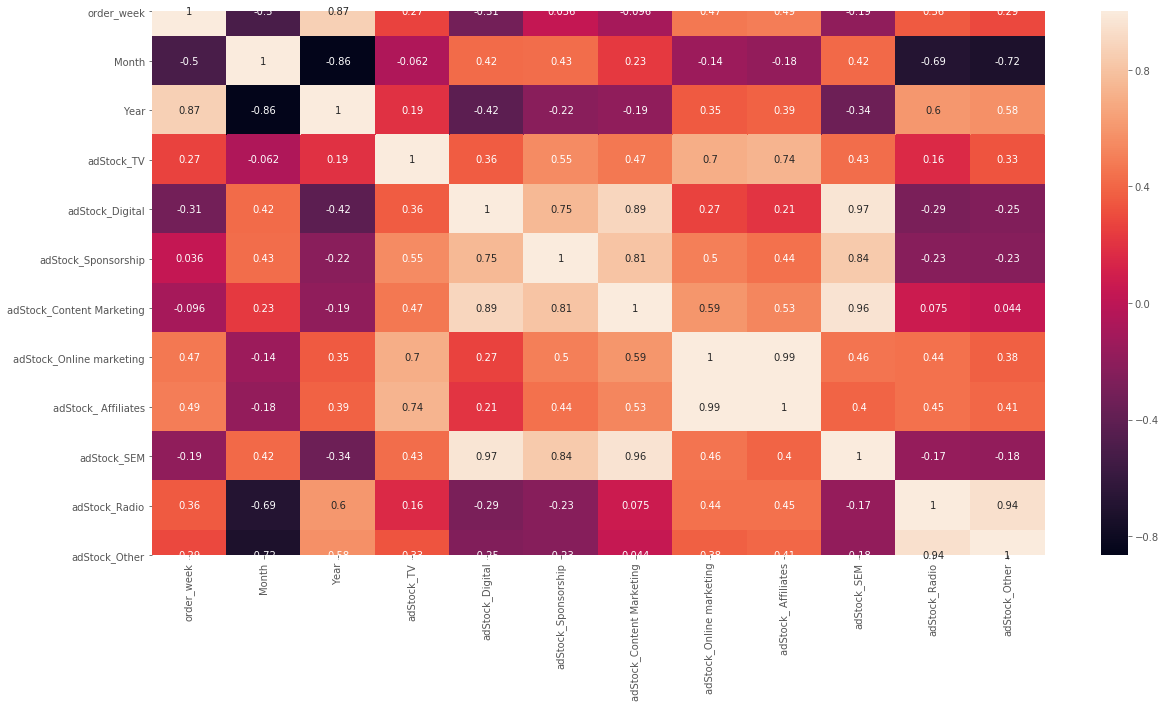

In [141]:
#Let's visualise the correlations b/w the adstocks again
plt.figure(figsize = (20,10))
sns.heatmap(final_adstock_data.corr(), annot = True)

As we see above, there is high correlation b/w 
- order_week & month, year & month, order_week & year
- adStock_Affiliates & adStock_Online marketing
- adStock_Other & adStock_Radio
- adStock_Digital & adStock_SEM
- adStock_Content Marketing & adStock_SEM
- Month & adstock_radio, Month & adstock_others
- adStock_TV & adStock_affiliates
- adStock_Sponsorship & adStock_Content Marketing

In [142]:
# preparing final_data for 3 categories by adding the adstock data
final_camera_data_with_adstock = pd.merge(final_adstock_data,final_camera_data, on = "order_week", how = 'right')
final_gaming_data_with_adstock = pd.merge(final_adstock_data,final_gaming_data, on = "order_week", how = 'right')
final_home_audio_data_with_adstock = pd.merge(final_adstock_data,final_home_audio_data, on = "order_week", how = 'right')

In [143]:
#Checking the shape of the final dataframes
print("Shape of Gaming Accessory DF",final_gaming_data_with_adstock.shape)
print("Shape of Camera Accessory DF",final_camera_data_with_adstock.shape)
print("Shape of Home Audio DF",final_home_audio_data_with_adstock.shape)

Shape of Gaming Accessory DF (53, 45)
Shape of Camera Accessory DF (52, 52)
Shape of Home Audio DF (50, 40)


### Exploratory Data Analysis - II

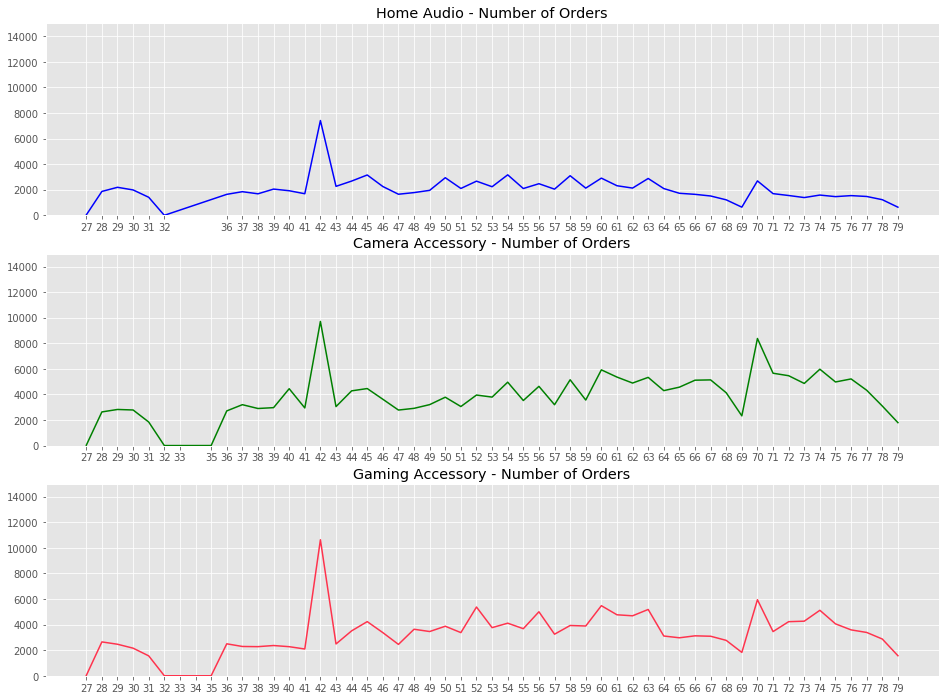

In [144]:
## No of Orders vs Week
fig, axes= plt.subplots(nrows=3, ncols=1,figsize=(16,12))

# subplot 1
ax1 = plt.subplot(3,1,1)
ax1.set_ylim(0,15000)
ax1 = plt.title('Home Audio - Number of Orders')
ax1 = plt.plot(final_home_audio_data_with_adstock['order_week'],final_home_audio_data_with_adstock['total_transactions'],color='blue')
plt.xticks(final_home_audio_data_with_adstock['order_week'])

# subplot 2
ax2 = plt.subplot(3,1,2)
ax2.set_ylim(0,15000)
ax2 = plt.title('Camera Accessory - Number of Orders')
ax2 = plt.plot(final_camera_data_with_adstock['order_week'],final_camera_data_with_adstock['total_transactions'],color='g')
plt.xticks(final_camera_data_with_adstock['order_week'])

# subplot 3
ax3 = plt.subplot(3,1,3)
ax3.set_ylim(0,15000)
ax3 = plt.title('Gaming Accessory - Number of Orders')
ax3 = plt.plot(final_gaming_data_with_adstock['order_week'],final_gaming_data_with_adstock['total_transactions'],color=(1.0,0.2,0.3))
plt.xticks(final_gaming_data_with_adstock['order_week'])

plt.show()

Highest orders - Week 42 for all categories. Gaming having highest orders

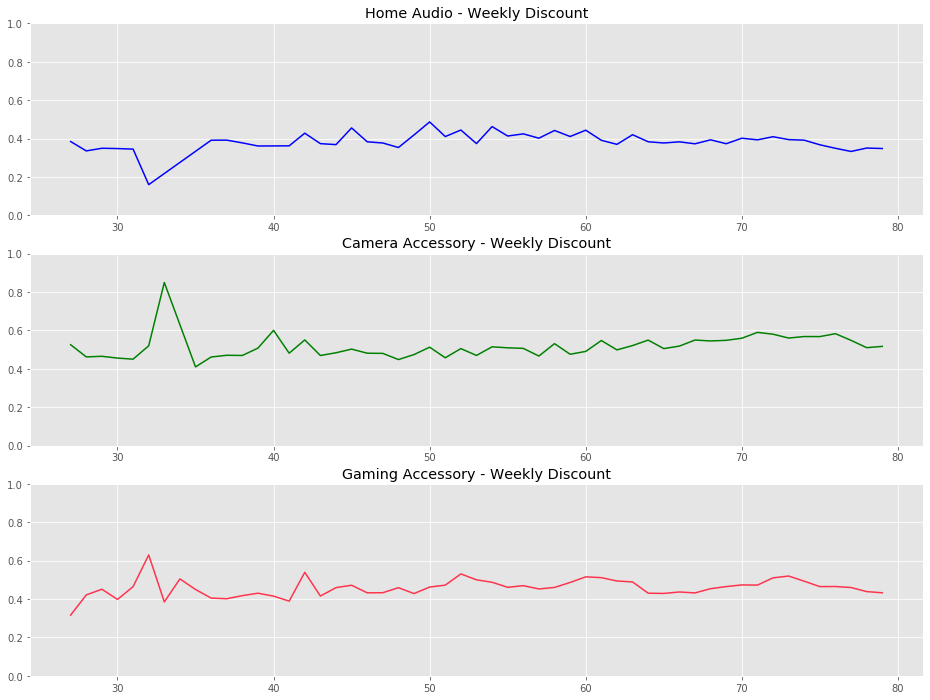

In [145]:
## Discount Analysis
fig, axes= plt.subplots(nrows=3, ncols=1,figsize=(16,12))

# subplot 1
ax1 = plt.subplot(3,1,1)
ax1.set_ylim(0,1)
ax1 = plt.title('Home Audio - Weekly Discount')
ax1 = plt.plot(final_home_audio_data_with_adstock['order_week'],final_home_audio_data_with_adstock['discount'],color='blue')

# subplot 2
ax2 = plt.subplot(3,1,2)
ax2.set_ylim(0,1)
ax2 = plt.title('Camera Accessory - Weekly Discount')
ax2 = plt.plot(final_camera_data_with_adstock['order_week'],final_camera_data_with_adstock['discount'],color='g')

# subplot 3
ax3 = plt.subplot(3,1,3)
ax3.set_ylim(0,1)
ax3 = plt.title('Gaming Accessory - Weekly Discount')
ax3 = plt.plot(final_gaming_data_with_adstock['order_week'],final_gaming_data_with_adstock['discount'],color=(1.0,0.2,0.3))

plt.show()

Highest Discounts for Camera Accessory

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c5af42550>],
      dtype=object)

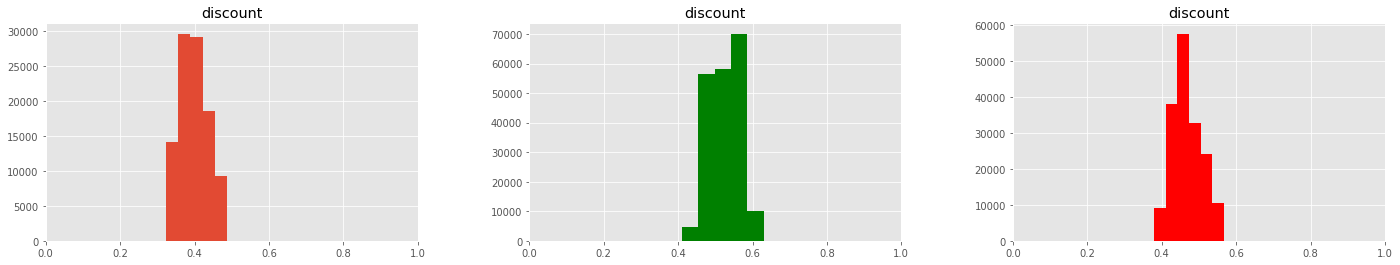

In [146]:
## Discount Analysis : Hist Plot of Discount vs No of tranactions
fig = plt.figure(figsize=(24,4))

ax1 = fig.add_subplot(131)
ax1.set_title('Home Audio - Discount Analysis')
ax1.set_xlim(0,1)
ax2 = fig.add_subplot(132)
ax2.set_title('Camera Accessory - Discount Analysis')
ax2.set_xlim(0,1)
ax3 = fig.add_subplot(133)
ax3.set_title('Gaming Accessory - Discount Analysis')
ax3.set_xlim(0,1)

final_home_audio_data_with_adstock.hist('discount',weights=final_home_audio_data_with_adstock['total_transactions'] ,ax = ax1)
final_camera_data_with_adstock.hist('discount',weights=final_camera_data_with_adstock['total_transactions'] ,ax = ax2,color = "green")
final_gaming_data_with_adstock.hist('discount',weights=final_gaming_data_with_adstock['total_transactions'] ,ax = ax3,color = "red")


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c4be9a590>],
      dtype=object)

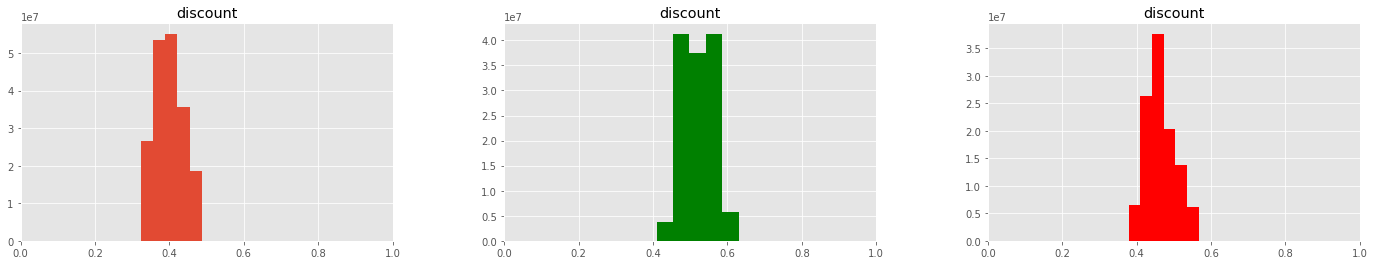

In [147]:
## Discount Analysis: Hist Plot of Discount vs GMV
fig = plt.figure(figsize=(24,4))

ax1 = fig.add_subplot(131)
ax1.set_title('Home Audio - Discount Analysis')
ax1.set_xlim(0,1)
ax2 = fig.add_subplot(132)
ax2.set_title('Camera Accessory - Discount Analysis')
ax2.set_xlim(0,1)
ax3 = fig.add_subplot(133)
ax3.set_title('Gaming Accessory - Discount Analysis')
ax3.set_xlim(0,1)

final_home_audio_data_with_adstock.hist('discount',weights=final_home_audio_data_with_adstock['gmv'] ,ax = ax1)
final_camera_data_with_adstock.hist('discount',weights=final_camera_data_with_adstock['gmv'] ,ax = ax2,color = "green")
final_gaming_data_with_adstock.hist('discount',weights=final_gaming_data_with_adstock['gmv'] ,ax = ax3,color = "red")

In [148]:
## Holiday week vs Average GMV
Holiday_week_sale_HA = final_home_audio_data_with_adstock.groupby('is_holiday')[['gmv']].mean().reset_index()
Holiday_week_sale_CA = final_camera_data_with_adstock.groupby('is_holiday')[['gmv']].mean().reset_index()
Holiday_week_sale_GA = final_gaming_data_with_adstock.groupby('is_holiday')[['gmv']].mean().reset_index()

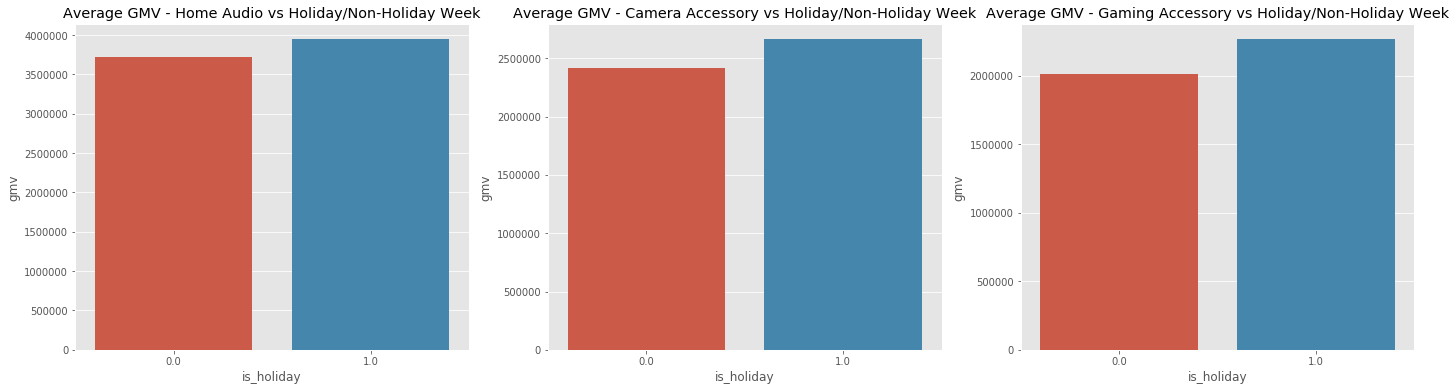

In [149]:
# increase figure size 
plt.figure(figsize=(24,6))

# subplot 1: Average GMV - Home Audio vs Holiday/Non-Holiday Week
ax1 = plt.subplot(1, 3, 1)
# ax1.set_ylim(0,8000000)
ax1 = sns.barplot(x='is_holiday', y='gmv', data=Holiday_week_sale_HA)
ax1 = plt.title("Average GMV - Home Audio vs Holiday/Non-Holiday Week")

# subplot 3: Average GMV - Camera Accessory vs Holiday/Non-Holiday Week
ax2 = plt.subplot(1, 3, 2)
# ax2.set_ylim(0,8000000)
ax2 = sns.barplot(x='is_holiday', y='gmv', data=Holiday_week_sale_CA)
ax2 = plt.title("Average GMV - Camera Accessory vs Holiday/Non-Holiday Week")

# subplot 5: Average GMV - Gaming Accessory vs Holiday/Non-Holiday Week
ax3 = plt.subplot(1, 3, 3)
# ax3.set_ylim(0,8000000)
ax3 = sns.barplot(x='is_holiday', y='gmv', data=Holiday_week_sale_GA)
ax3 = plt.title("Average GMV - Gaming Accessory vs Holiday/Non-Holiday Week")

plt.show()

In [150]:
## Holiday week vs Total GMV
Holiday_week_sale_HA = final_home_audio_data_with_adstock.groupby('is_holiday')[['gmv']].sum().reset_index()
Holiday_week_sale_CA = final_camera_data_with_adstock.groupby('is_holiday')[['gmv']].sum().reset_index()
Holiday_week_sale_GA = final_gaming_data_with_adstock.groupby('is_holiday')[['gmv']].sum().reset_index()

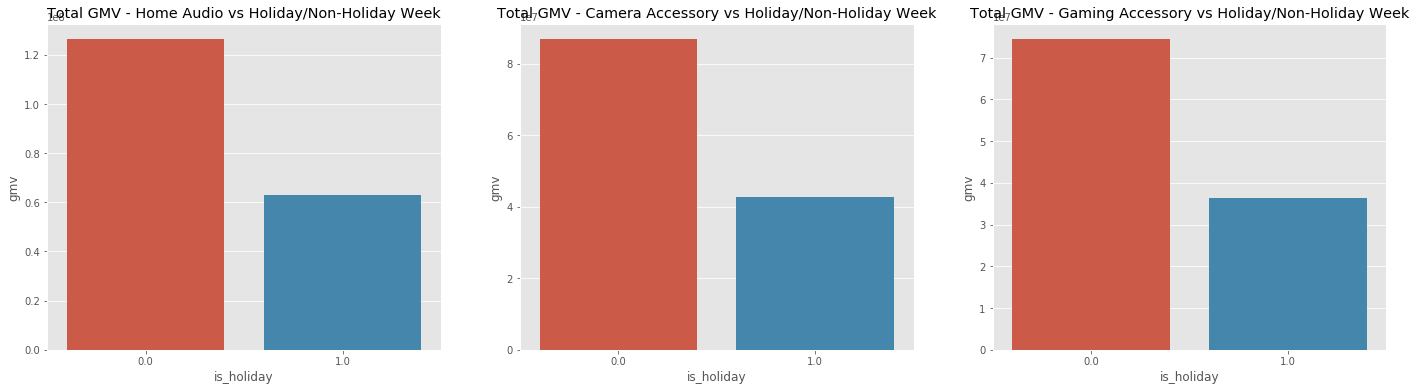

In [151]:
# increase figure size 
plt.figure(figsize=(24,6))

# subplot 1: Total GMV - Home Audio vs Holiday/Non-Holiday Week
ax1 = plt.subplot(1, 3, 1)
# ax1.set_ylim(0,8000000)
ax1 = sns.barplot(x='is_holiday', y='gmv', data=Holiday_week_sale_HA)
ax1 = plt.title("Total GMV - Home Audio vs Holiday/Non-Holiday Week")

# subplot 3: Total GMV - Camera Accessory vs Holiday/Non-Holiday Week
ax2 = plt.subplot(1, 3, 2)
# ax2.set_ylim(0,8000000)
ax2 = sns.barplot(x='is_holiday', y='gmv', data=Holiday_week_sale_CA)
ax2 = plt.title("Total GMV - Camera Accessory vs Holiday/Non-Holiday Week")

# subplot 5: Total GMV - Gaming Accessory vs Holiday/Non-Holiday Week
ax3 = plt.subplot(1, 3, 3)
# ax3.set_ylim(0,8000000)
ax3 = sns.barplot(x='is_holiday', y='gmv', data=Holiday_week_sale_GA)
ax3 = plt.title("Total GMV - Gaming Accessory vs Holiday/Non-Holiday Week")

plt.show()

#### From the above two graphs(mean and sum), overall, total gmv on weeks without holidays is more, however mean_gmv for weeks with holiday is higher.


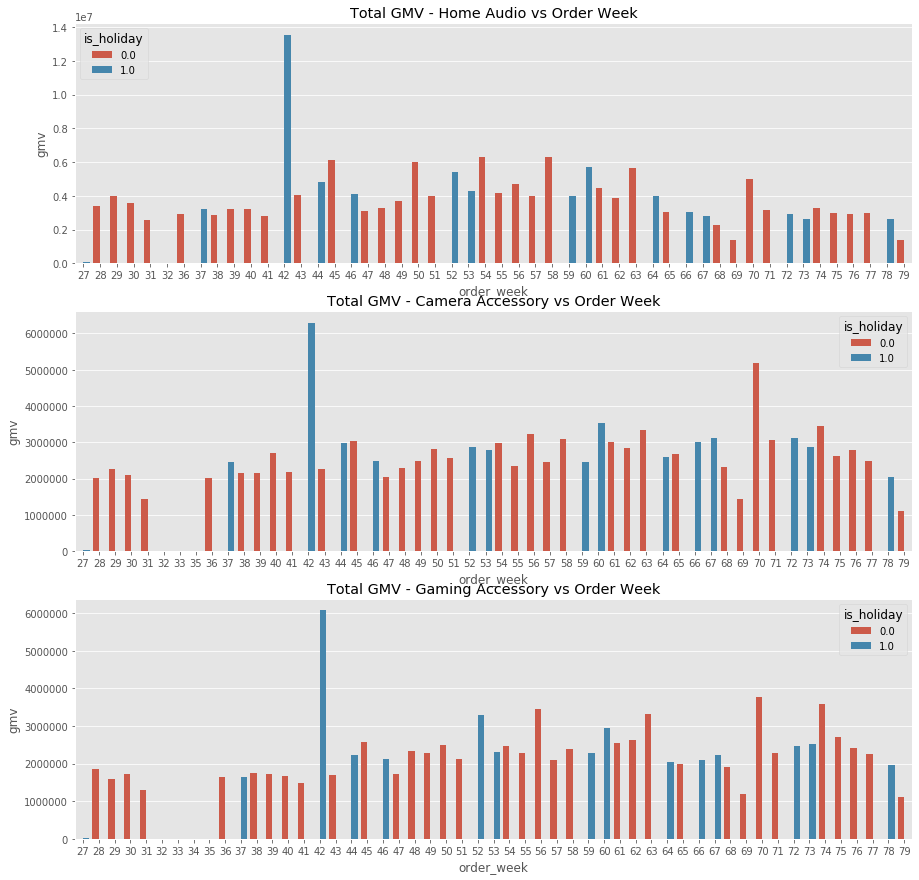

In [152]:
#Analyzing the total gmv over the weeks based upon whether the week contained a holiday or not for all the three categories
plt.figure(figsize = (15,15))
ax1 = plt.subplot(3, 1, 1)
ax1 = sns.barplot(x = 'order_week', y = 'gmv', data = final_home_audio_data_with_adstock, hue = 'is_holiday')
ax1 = plt.title("Total GMV - Home Audio vs Order Week")

ax1 = plt.subplot(3, 1, 2)
ax1 = sns.barplot(x = 'order_week', y = 'gmv', data = final_camera_data_with_adstock, hue = 'is_holiday')
ax1 = plt.title("Total GMV - Camera Accessory vs Order Week")

ax1 = plt.subplot(3, 1, 3)
ax1 = sns.barplot(x = 'order_week', y = 'gmv', data = final_gaming_data_with_adstock, hue = 'is_holiday')
ax1 = plt.title("Total GMV - Gaming Accessory vs Order Week")


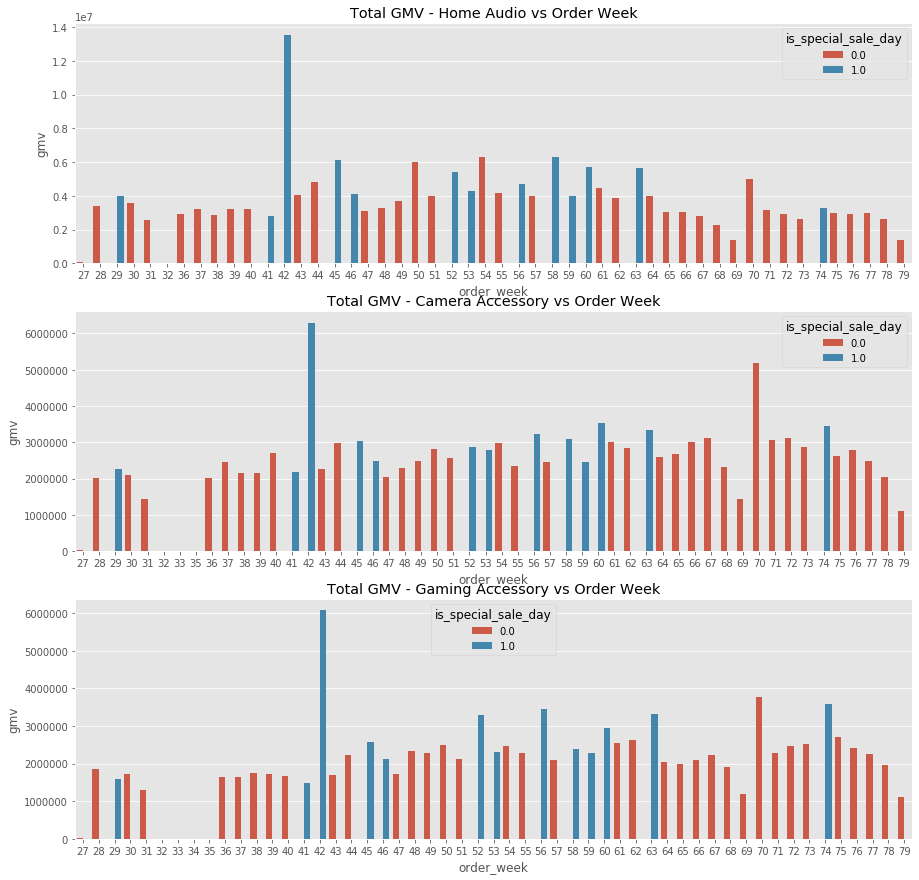

In [153]:
#Analyzing the total gmv over the weeks based upon whether the week contained a special sales day or not for all the three categories
plt.figure(figsize = (15,15))
ax1 = plt.subplot(3, 1, 1)
ax1 = sns.barplot(x = 'order_week', y = 'gmv', data = final_home_audio_data_with_adstock, hue = 'is_special_sale_day')
ax1 = plt.title("Total GMV - Home Audio vs Order Week")

ax1 = plt.subplot(3, 1, 2)
ax1 = sns.barplot(x = 'order_week', y = 'gmv', data = final_camera_data_with_adstock, hue = 'is_special_sale_day')
ax1 = plt.title("Total GMV - Camera Accessory vs Order Week")

ax1 = plt.subplot(3, 1, 3)
ax1 = sns.barplot(x = 'order_week', y = 'gmv', data = final_gaming_data_with_adstock, hue = 'is_special_sale_day')
ax1 = plt.title("Total GMV - Gaming Accessory vs Order Week")


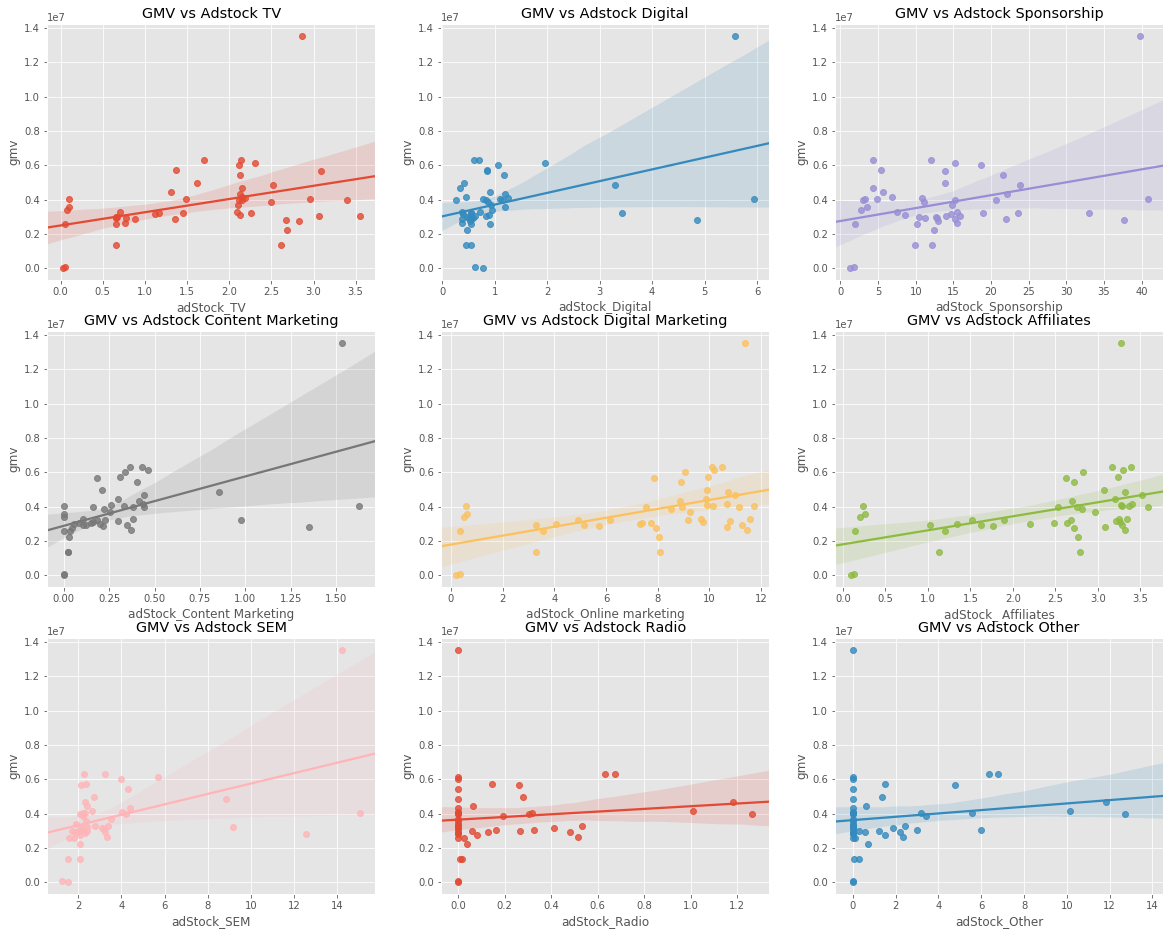

In [154]:
## Relationship between GMV and Adstocks of different channels for Home Audio
fig = plt.figure(figsize=(20,16))

ax1 = fig.add_subplot(331)
ax1.set_title('GMV vs Adstock TV')
ax2 = fig.add_subplot(332)
ax2.set_title('GMV vs Adstock Digital')
ax3 = fig.add_subplot(333)
ax3.set_title('GMV vs Adstock Sponsorship')
ax4 = fig.add_subplot(334)
ax4.set_title('GMV vs Adstock Content Marketing')
ax5 = fig.add_subplot(335)
ax5.set_title('GMV vs Adstock Digital Marketing')
ax6 = fig.add_subplot(336)
ax6.set_title('GMV vs Adstock Affiliates')
ax7 = fig.add_subplot(337)
ax7.set_title('GMV vs Adstock SEM')
ax8 = fig.add_subplot(338)
ax8.set_title('GMV vs Adstock Radio')
ax9 = fig.add_subplot(339)
ax9.set_title('GMV vs Adstock Other')

sns.regplot(final_home_audio_data_with_adstock['adStock_TV'],final_home_audio_data_with_adstock['gmv'],order=1,ax = ax1)
sns.regplot(final_home_audio_data_with_adstock['adStock_Digital'],final_home_audio_data_with_adstock['gmv'],order=1,ax = ax2)
sns.regplot(final_home_audio_data_with_adstock['adStock_Sponsorship'],final_home_audio_data_with_adstock['gmv'],order=1,ax = ax3)
sns.regplot(final_home_audio_data_with_adstock['adStock_Content Marketing'],final_home_audio_data_with_adstock['gmv'],order=1,ax = ax4)
sns.regplot(final_home_audio_data_with_adstock['adStock_Online marketing'],final_home_audio_data_with_adstock['gmv'],order=1,ax = ax5)
sns.regplot(final_home_audio_data_with_adstock['adStock_ Affiliates'],final_home_audio_data_with_adstock['gmv'],order=1,ax = ax6)
sns.regplot(final_home_audio_data_with_adstock['adStock_SEM'],final_home_audio_data_with_adstock['gmv'],order=1,ax = ax7)
sns.regplot(final_home_audio_data_with_adstock['adStock_Radio'],final_home_audio_data_with_adstock['gmv'],order=1,ax = ax8)
sns.regplot(final_home_audio_data_with_adstock['adStock_Other'],final_home_audio_data_with_adstock['gmv'],order=1,ax = ax9)

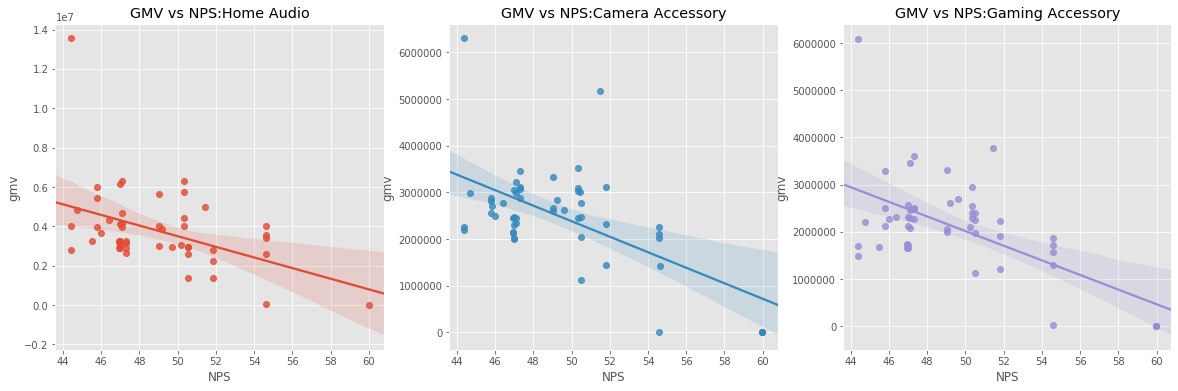

In [155]:
## Relationship between GMV and NPS for all three categories
fig = plt.figure(figsize=(20,6))

ax1 = fig.add_subplot(131)
ax1.set_title('GMV vs NPS:Home Audio')
ax2 = fig.add_subplot(132)
ax2.set_title('GMV vs NPS:Camera Accessory')
ax3 = fig.add_subplot(133)
ax3.set_title('GMV vs NPS:Gaming Accessory')

sns.regplot(final_home_audio_data_with_adstock['NPS'],final_home_audio_data_with_adstock['gmv'],ax = ax1)
sns.regplot(final_camera_data_with_adstock['NPS'],final_camera_data_with_adstock['gmv'],ax = ax2)
sns.regplot(final_gaming_data_with_adstock['NPS'],final_gaming_data_with_adstock['gmv'],ax = ax3) 

## Modelling

In [156]:
# function to calculate the elasticity of the important KPIs
def calculateElasticity(df_train, gmv, coefficient_df):
    elasticity = []
    for i in coefficient_df.feature:
        feature_mean = df_train[i].mean()
        elasticity.append((((coefficient_df.loc[coefficient_df['feature']==i]['coefficient'].mean())*feature_mean)/gmv.mean()))
    coefficient_df['elasticity'] = pd.Series(elasticity)
    return coefficient_df

## Building the Basic Linear Models

### 1. Gaming Accessory

In [161]:
final_gaming_data_with_adstock.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,adStock_Radio,adStock_Other,gmv,units,sla,product_procurement_sla,product_mrp,selling_price,discount,NPS,total_transactions,total_holiday,is_holiday,total_special_sale_day,is_special_sale_day,total_pay_days,is_pay_days,COD_count,Prepaid_count,pct_online_transactions,CoolingPad,GameControlMount,GamePad,GamingAccessoryKit,GamingAdapter,GamingChargingStation,GamingHeadset,GamingKeyboard,GamingMemoryCard,GamingMouse,GamingMousePad,GamingSpeaker,JoystickGamingWheel,MotionController,TVOutCableAccessory
0,27,7,2015,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0,2.234400e+04,24,3.458333,3.208333,3504.125000,931.000000,0.316250,54.599588,24,1.0,1.0,0.0,0.0,1.0,1.0,0.0,24.0,1.00,0.0,0.0,14.0,2.0,0.0,0.0,2.0,1.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0
1,28,7,2015,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,0.0,0.0,1.866719e+06,2767,5.375094,3.245660,1667.559623,685.125660,0.421543,54.599588,2650,0.0,0.0,0.0,0.0,0.0,0.0,1969.0,681.0,0.26,0.0,0.0,861.0,100.0,48.0,0.0,177.0,424.0,36.0,966.0,55.0,0.0,11.0,16.0,73.0
2,29,7,2015,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,0.0,0.0,1.585166e+06,2704,5.268747,2.721119,1638.086745,630.567636,0.451228,54.599588,2467,0.0,0.0,2.0,1.0,1.0,1.0,1901.0,566.0,0.23,0.0,0.0,1647.0,129.0,44.0,0.0,179.0,162.0,27.0,357.0,48.0,0.0,8.0,11.0,92.0
3,30,7,2015,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,0.0,0.0,1.722134e+06,2231,5.459259,2.592130,2139.344907,784.834954,0.398009,54.599588,2160,0.0,0.0,0.0,0.0,0.0,0.0,1680.0,480.0,0.22,0.0,0.0,921.0,166.0,35.0,0.0,283.0,170.0,28.0,448.0,67.0,0.0,9.0,11.0,93.0
4,31,8,2015,0.052078,0.913194,2.003552,0.000220,0.343392,0.146684,1.805811,0.0,0.0,1.298391e+06,1619,5.713094,3.237484,5311.397304,816.840180,0.464647,54.603046,1558,0.0,0.0,0.0,0.0,1.0,1.0,1250.0,308.0,0.20,0.0,0.0,611.0,95.0,31.0,0.0,424.0,71.0,11.0,232.0,39.0,1.0,17.0,8.0,79.0


In [169]:
# Creating lmGamingAccessoryDf by dropping the features which the company cannot control
gamingAccessoryDf = final_gaming_data_with_adstock.drop(
    ['selling_price','units','product_mrp','total_transactions','COD_count', 'Prepaid_count'], 
    axis = 1
)

In [170]:
gamingAccessoryDf.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_holiday',
       'is_holiday', 'total_special_sale_day', 'is_special_sale_day',
       'total_pay_days', 'is_pay_days', 'pct_online_transactions',
       'CoolingPad', 'GameControlMount', 'GamePad', 'GamingAccessoryKit',
       'GamingAdapter', 'GamingChargingStation', 'GamingHeadset',
       'GamingKeyboard', 'GamingMemoryCard', 'GamingMouse', 'GamingMousePad',
       'GamingSpeaker', 'JoystickGamingWheel', 'MotionController',
       'TVOutCableAccessory'],
      dtype='object')

In [171]:
# doing the test train split
np.random.seed(0)
df1_train, df1_test = train_test_split(gamingAccessoryDf, train_size = 0.8, test_size = 0.2, random_state = 100)

In [172]:
# Scaling the features
scaler=MinMaxScaler()

# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars1 = [
    'adStock_TV', 'adStock_Digital', 'adStock_Sponsorship', 'adStock_Content Marketing',
    'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM', 'adStock_Radio', 'adStock_Other', 
    'gmv', 'sla', 'product_procurement_sla', 'discount', 'NPS', 'total_holiday', 'total_special_sale_day',
    'total_pay_days', 'pct_online_transactions', 'CoolingPad', 'GameControlMount', 'GamePad', 'GamingAccessoryKit',
    'GamingAdapter', 'GamingChargingStation', 'GamingHeadset', 'GamingKeyboard', 'GamingMemoryCard', 'GamingMouse', 
    'GamingMousePad', 'GamingSpeaker', 'JoystickGamingWheel', 'MotionController', 'TVOutCableAccessory'
]
df1_train[num_vars1] = scaler.fit_transform(df1_train[num_vars1])
df1_test[num_vars1] = scaler.fit_transform(df1_test[num_vars1])

In [173]:
# assiging the values for x_train & y_train
y_train1 = df1_train.pop('gmv')
X_train1 = df1_train

## RFE

In [219]:
# Running RFE with the output number of the variable equal to 12
lm = LinearRegression()
lm.fit(X_train1, y_train1)

rfe = RFE(lm, 12)             # running RFE
rfe = rfe.fit(X_train1, y_train1)

In [220]:
## selecting the top 12 rfe features
col = X_train1.columns[rfe.support_]
col

Index(['adStock_TV', 'adStock_Digital', 'adStock_Sponsorship', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'GamePad', 'GamingAccessoryKit',
       'GamingHeadset', 'GamingMemoryCard', 'GamingMouse', 'GamingSpeaker'],
      dtype='object')

In [221]:
## checking the columns excluded by rfe
X_train1.columns[~rfe.support_]

Index(['order_week', 'Month', 'Year', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_holiday',
       'is_holiday', 'total_special_sale_day', 'is_special_sale_day',
       'total_pay_days', 'is_pay_days', 'pct_online_transactions',
       'CoolingPad', 'GameControlMount', 'GamingAdapter',
       'GamingChargingStation', 'GamingKeyboard', 'GamingMousePad',
       'JoystickGamingWheel', 'MotionController', 'TVOutCableAccessory'],
      dtype='object')

In [222]:
# Creating X_traun_rfel dataframe with RFE selected variables
X_train_rfe1 = X_train1[col]

# Add a constant
X_train_lm1 = sm.add_constant(X_train_rfe1)

# Create a first fitted model
lr = sm.OLS(y_train1, X_train_lm1).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1 .values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     195.7
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           2.26e-24
Time:                        13:55:27   Log-Likelihood:                 108.77
No. Observations:                  42   AIC:                            -191.5
Df Residuals:                      29   BIC:                            -168.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0635    

,Features,VIF
4,adStock_SEM,1132.16
2,adStock_Digital,868.31
5,adStock_Radio,519.89
6,adStock_Other,492.67
0,const,93.09
1,adStock_TV,29.53
3,adStock_Sponsorship,16.20
10,GamingMemoryCard,4.87
8,GamingAccessoryKit,4.32
7,GamePad,3.57


In [223]:
# removing feature on the basis of highest vif value
X_train1_new = X_train_rfe1.drop(["adStock_SEM"], axis = 1)

# Add a constant
X_train_lm1 = sm.add_constant(X_train1_new)
  
lr = sm.OLS(y_train1, X_train_lm1).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1.values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     177.7
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           3.63e-24
Time:                        13:59:08   Log-Likelihood:                 104.26
No. Observations:                  42   AIC:                            -184.5
Df Residuals:                      30   BIC:                            -163.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0176    

,Features,VIF
5,adStock_Other,35.77
4,adStock_Radio,32.30
0,const,9.62
3,adStock_Sponsorship,6.20
1,adStock_TV,4.82
7,GamingAccessoryKit,4.30
2,adStock_Digital,4.06
6,GamePad,3.50
8,GamingHeadset,3.10
10,GamingMouse,3.01


In [224]:
# removing the feature with highest p-values
X_train1_new1= X_train1_new.drop(["adStock_Radio"], axis = 1)
 # Add a constant
X_train_lm1 = sm.add_constant(X_train1_new1)

lr = sm.OLS(y_train1, X_train_lm1).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1.values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     200.1
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           2.85e-25
Time:                        13:59:18   Log-Likelihood:                 104.07
No. Observations:                  42   AIC:                            -186.1
Df Residuals:                      31   BIC:                            -167.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0172    

,Features,VIF
0,const,9.55
3,adStock_Sponsorship,5.65
6,GamingAccessoryKit,4.12
2,adStock_Digital,4.06
5,GamePad,3.40
7,GamingHeadset,3.09
9,GamingMouse,3.01
4,adStock_Other,2.98
1,adStock_TV,2.93
8,GamingMemoryCard,1.99


In [225]:
# removing the feature with highest p-value
X_train1_new2= X_train1_new1.drop(["adStock_TV"], axis = 1)

# Add a constant
X_train_lm1 = sm.add_constant(X_train1_new2)

lr = sm.OLS(y_train1, X_train_lm1).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1.values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     228.4
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.96e-26
Time:                        13:59:26   Log-Likelihood:                 103.97
No. Observations:                  42   AIC:                            -187.9
Df Residuals:                      32   BIC:                            -170.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0165    

,Features,VIF
0,const,9.35
1,adStock_Digital,3.88
5,GamingAccessoryKit,3.85
2,adStock_Sponsorship,3.84
4,GamePad,3.22
8,GamingMouse,3.01
6,GamingHeadset,2.95
3,adStock_Other,2.12
7,GamingMemoryCard,1.97
9,GamingSpeaker,1.49


In [226]:
# removing the feature with highest p-value
X_train1_new3= X_train1_new2.drop(["adStock_Sponsorship"], axis = 1)

# Add a constant
X_train_lm1 = sm.add_constant(X_train1_new3)
    # Create a first fitted model
lr = sm.OLS(y_train1, X_train_lm1).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1.values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     261.9
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.40e-27
Time:                        13:59:28   Log-Likelihood:                 103.73
No. Observations:                  42   AIC:                            -189.5
Df Residuals:                      33   BIC:                            -173.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0166      0

,Features,VIF
0,const,9.35
4,GamingAccessoryKit,3.38
3,GamePad,3.22
7,GamingMouse,2.97
5,GamingHeadset,2.91
2,adStock_Other,2.05
6,GamingMemoryCard,1.94
1,adStock_Digital,1.64
8,GamingSpeaker,1.42


In [227]:
# removing the feature with highest p-value
X_train1_new4 = X_train1_new3.drop(["GamingMemoryCard"], axis = 1)

# Add a constant
X_train_lm1 = sm.add_constant(X_train1_new4)
    # Create a first fitted model
lr = sm.OLS(y_train1, X_train_lm1).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1.values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     302.7
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.04e-28
Time:                        13:59:28   Log-Likelihood:                 103.34
No. Observations:                  42   AIC:                            -190.7
Df Residuals:                      34   BIC:                            -176.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0175      0

,Features,VIF
0,const,9.26
4,GamingAccessoryKit,3.33
3,GamePad,3.21
6,GamingMouse,2.97
5,GamingHeadset,2.88
1,adStock_Digital,1.64
7,GamingSpeaker,1.42
2,adStock_Other,1.31


In [228]:
# removing the feature with highest p-value
X_train1_new5 = X_train1_new4.drop(["adStock_Digital"], axis = 1)
 
# Add a constant
X_train_lm1 = sm.add_constant(X_train1_new5)
    
# Create a first fitted model
lr = sm.OLS(y_train1, X_train_lm1).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm1.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm1.values, i) for i in range(X_train_lm1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     344.5
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.31e-29
Time:                        13:59:33   Log-Likelihood:                 102.23
No. Observations:                  42   AIC:                            -190.5
Df Residuals:                      35   BIC:                            -178.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0150      0

,Features,VIF
0,const,9.00
3,GamingAccessoryKit,3.20
2,GamePad,3.12
4,GamingHeadset,2.78
5,GamingMouse,2.28
6,GamingSpeaker,1.34
1,adStock_Other,1.28


In [229]:
# Dropping the feature to see if the model is able to explain much variance with one less feature
X_train1_new6= X_train1_new5.drop(["GamingAccessoryKit"], axis = 1)
 
# Add a constant
X_train_lm2 = sm.add_constant(X_train1_new6)

lr2= sm.OLS(y_train1, X_train_lm2).fit()

lr2.params
print(lr2.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     247.2
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           8.29e-27
Time:                        14:01:01   Log-Likelihood:                 91.088
No. Observations:                  42   AIC:                            -170.2
Df Residuals:                      36   BIC:                            -159.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0342      0.013      2.652

,Features,VIF
0,const,7.83
3,GamingHeadset,2.36
4,GamingMouse,2.27
2,GamePad,1.80
5,GamingSpeaker,1.34
1,adStock_Other,1.20


In [230]:
# Dropping the feature to see if the model is able to explain much variance with one less feature
X_train1_new7= X_train1_new6.drop(["adStock_Other"], axis = 1)
 
# Add a constant
X_train_lm3 = sm.add_constant(X_train1_new7)

# Create a first fitted model
lr3 = sm.OLS(y_train1, X_train_lm3).fit()

lr3.params
print(lr3.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm3.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm3.values, i) for i in range(X_train_lm3.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     287.5
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           2.58e-27
Time:                        14:01:01   Log-Likelihood:                 89.059
No. Observations:                  42   AIC:                            -168.1
Df Residuals:                      37   BIC:                            -159.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0360      0.013      2.703

,Features,VIF
0,const,7.78
3,GamingMouse,2.19
2,GamingHeadset,2.11
1,GamePad,1.79
4,GamingSpeaker,1.32


In [231]:
# checking performance of top 3 models finding Adjusted R-squared

x_trains = [X_train_lm1, X_train_lm2, X_train_lm3]
for i in range(0,len(x_trains)):
    scores = cross_val_score(lm, x_trains[i], y_train1 , scoring='r2', cv=5)
    print("lr model",i+1,"r2_score", scores.mean())

lr model 1 r2_score 0.9558011549226396
lr model 2 r2_score 0.9235382044327016
lr model 3 r2_score 0.9151438752785449


#### model 3 is the best model as one less feature can still explain 91% variance of the model

### Model Evaluation

In [236]:
y_test = df1_test.pop('gmv')
X_test = df1_test

In [237]:
X_test.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'sla', 'product_procurement_sla',
       'discount', 'NPS', 'total_holiday', 'is_holiday',
       'total_special_sale_day', 'is_special_sale_day', 'total_pay_days',
       'is_pay_days', 'pct_online_transactions', 'CoolingPad',
       'GameControlMount', 'GamePad', 'GamingAccessoryKit', 'GamingAdapter',
       'GamingChargingStation', 'GamingHeadset', 'GamingKeyboard',
       'GamingMemoryCard', 'GamingMouse', 'GamingMousePad', 'GamingSpeaker',
       'JoystickGamingWheel', 'MotionController', 'TVOutCableAccessory'],
      dtype='object')

In [238]:
X_test.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,adStock_Radio,adStock_Other,sla,product_procurement_sla,discount,NPS,total_holiday,is_holiday,total_special_sale_day,is_special_sale_day,total_pay_days,is_pay_days,pct_online_transactions,CoolingPad,GameControlMount,GamePad,GamingAccessoryKit,GamingAdapter,GamingChargingStation,GamingHeadset,GamingKeyboard,GamingMemoryCard,GamingMouse,GamingMousePad,GamingSpeaker,JoystickGamingWheel,MotionController,TVOutCableAccessory
25,52,12,2015,0.623447,0.505849,1.000000,0.865790,0.772951,0.797967,0.679923,0.000000,0.000000,0.316001,0.793003,0.596103,0.000000,1.0,1.0,1.000000,1.0,0.0,0.0,0.0,0.166667,0.0,1.000000,0.931193,0.547170,1.0,0.856222,0.649635,1.000000,0.610843,0.720,0.236364,0.156627,0.823529,0.653631
48,75,6,2016,0.192129,0.056635,0.569889,0.429084,0.634075,0.643276,0.241883,0.420988,0.190226,0.213578,0.000000,0.326134,0.268451,0.0,0.0,0.000000,0.0,1.0,1.0,0.3,0.166667,0.0,0.925957,1.000000,0.613208,0.0,0.511881,0.890511,0.108374,0.516867,0.464,1.000000,1.000000,0.352941,0.893855
52,79,6,2016,0.189369,0.111151,0.438248,0.050530,0.277200,0.319957,0.029384,0.013580,0.006136,0.000000,0.257192,0.194722,0.332463,0.0,0.0,0.000000,0.0,0.0,0.0,0.1,0.000000,0.0,0.339434,0.472477,0.320755,0.0,0.220701,0.503650,0.013136,0.159036,0.128,0.145455,0.518072,0.647059,0.340782
37,64,3,2016,1.000000,0.290729,0.691260,0.347230,0.653390,0.742328,0.164123,0.481185,0.878996,0.342602,0.755439,0.186088,0.227006,0.5,1.0,0.000000,0.0,1.0,1.0,0.4,0.000000,0.0,0.816140,0.972477,0.754717,0.0,0.361257,0.992701,0.070608,0.331325,0.448,0.145455,0.192771,0.529412,1.000000
6,33,8,2015,0.000000,0.200688,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.427926,0.656000,0.000000,1.000000,0.0,0.0,0.666667,1.0,1.0,1.0,1.0,0.000000,0.0,0.000832,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000


In [239]:
X_test = X_test[X_train_lm3.drop('const', axis = 1).columns]
X_test = sm.add_constant(X_test)
X_test

,const,GamePad,GamingHeadset,GamingMouse,GamingSpeaker
25,1.0,1.000000,0.856222,0.610843,0.236364
48,1.0,0.925957,0.511881,0.516867,1.000000
52,1.0,0.339434,0.220701,0.159036,0.145455
37,1.0,0.816140,0.361257,0.331325,0.145455
6,1.0,0.000832,0.000000,0.000000,0.000000
18,1.0,0.973378,0.415224,1.000000,0.054545
20,1.0,0.600666,0.326621,0.236747,0.018182
46,1.0,0.766223,0.801047,0.371084,0.581818
5,1.0,0.000000,0.000000,0.000000,0.000000
31,1.0,0.718802,0.643576,0.433133,0.363636


In [240]:
# Making predictions using the final model
y_pred = lr3.predict(X_test)

Text(0, 0.5, 'y_pred')

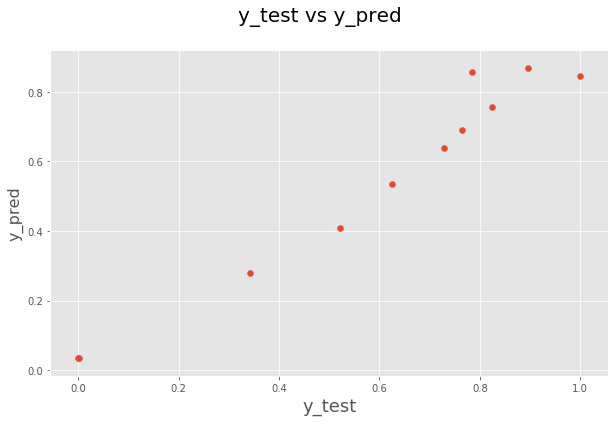

In [241]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      

### Elasticity - Gaming Accessory - Basic Linear Model

In [242]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr3.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_lm3, y_train1, coefficients_df)

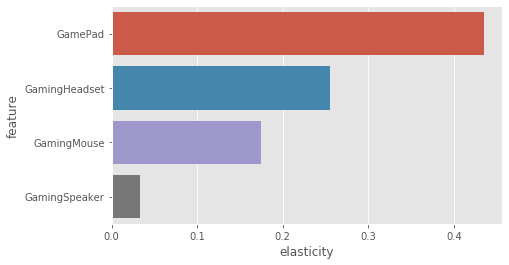

In [243]:
plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

### 2. Camera Accessory

In [244]:
# taking the final camera accessory data for basic linear mode
final_camera_data_with_adstock.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,adStock_Radio,adStock_Other,gmv,units,sla,product_procurement_sla,product_mrp,selling_price,discount,NPS,total_transactions,total_holiday,is_holiday,total_special_sale_day,is_special_sale_day,total_pay_days,is_pay_days,COD_count,Prepaid_count,pct_online_transactions,Binoculars,CameraAccessory,CameraBag,CameraBattery,CameraBatteryCharger,CameraBatteryGrip,CameraEyeCup,CameraFilmRolls,CameraHousing,CameraMicrophone,CameraMount,CameraRemoteControl,CameraTripod,ExtensionTube,Filter,Flash,FlashShoeAdapter,Lens,ReflectorUmbrella,Softbox,Strap,Telescope
0,27,7,2015,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0,15375.0,25,2.280000,2.960000,1456.840000,615.000000,0.525600,54.599588,25,1.0,1.0,0.0,0.0,1.0,1.0,0.0,25.0,1.00,1.0,1.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1,28,7,2015,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,0.0,0.0,2019042.0,2752,7.156274,2.742586,1646.428137,751.233460,0.462194,54.599588,2630,0.0,0.0,0.0,0.0,0.0,0.0,1796.0,834.0,0.32,193.0,45.0,328.0,735.0,224.0,11.0,0.0,0.0,0.0,0.0,4.0,141.0,433.0,0.0,226.0,17.0,0.0,366.0,0.0,0.0,13.0,16.0
2,29,7,2015,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,0.0,0.0,2249245.0,2917,6.491321,2.764789,1630.936238,783.509033,0.465349,54.599588,2823,0.0,0.0,2.0,1.0,1.0,1.0,1906.0,917.0,0.32,247.0,30.0,351.0,770.0,228.0,5.0,0.0,0.0,0.0,0.0,11.0,145.0,491.0,0.0,188.0,23.0,0.0,382.0,0.0,0.0,24.0,22.0
3,30,7,2015,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,0.0,0.0,2105858.0,2888,6.488138,2.831776,1560.504313,740.930625,0.455913,54.599588,2782,0.0,0.0,0.0,0.0,0.0,0.0,1914.0,868.0,0.31,209.0,44.0,284.0,812.0,270.0,9.0,0.0,0.0,0.0,0.0,7.0,108.0,457.0,0.0,194.0,18.0,0.0,423.0,0.0,0.0,23.0,30.0
4,31,8,2015,0.052078,0.913194,2.003552,0.000220,0.343392,0.146684,1.805811,0.0,0.0,1426134.0,1932,6.470684,2.777959,1524.232356,756.820304,0.450456,54.605438,1842,0.0,0.0,0.0,0.0,1.0,1.0,1315.0,527.0,0.29,144.0,41.0,175.0,516.0,194.0,8.0,0.0,0.0,0.0,0.0,2.0,82.0,363.0,0.0,112.0,26.0,0.0,233.0,0.0,0.0,23.0,13.0


In [245]:
# dropping the attributes that are not controllable
cameraAccessoryDf = final_camera_data_with_adstock.drop(
    ['selling_price','units','product_mrp','total_transactions','COD_count', 'Prepaid_count'], 
    axis = 1
)

In [247]:
cameraAccessoryDf.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_holiday',
       'is_holiday', 'total_special_sale_day', 'is_special_sale_day',
       'total_pay_days', 'is_pay_days', 'pct_online_transactions',
       'Binoculars', 'CameraAccessory', 'CameraBag', 'CameraBattery',
       'CameraBatteryCharger', 'CameraBatteryGrip', 'CameraEyeCup',
       'CameraFilmRolls', 'CameraHousing', 'CameraMicrophone', 'CameraMount',
       'CameraRemoteControl', 'CameraTripod', 'ExtensionTube', 'Filter',
       'Flash', 'FlashShoeAdapter', 'Lens', 'ReflectorUmbrella', 'Softbox',
       'Strap', 'Telescope'],
      dtype='object')

In [246]:
# splitting the data into test and train set
np.random.seed(0)
df_train, df_test = train_test_split(cameraAccessoryDf, train_size = 0.8, test_size = 0.2, random_state = 100)

In [248]:
scaler = MinMaxScaler()

# Apply scaler() to all the columns except the categorical variables
num_vars = [
    'adStock_TV', 'adStock_Digital','adStock_Sponsorship', 'adStock_Content Marketing', 'adStock_Online marketing', 
    'adStock_ Affiliates', 'adStock_SEM', 'adStock_Radio', 'adStock_Other', 'gmv', 'sla', 'product_procurement_sla', 
    'discount', 'NPS', 'total_holiday', 'total_special_sale_day', 'total_pay_days', 'pct_online_transactions', 
    'Binoculars', 'CameraAccessory', 'CameraBag', 'CameraBattery', 'CameraBatteryCharger', 'CameraBatteryGrip',
    'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing', 'CameraMicrophone', 'CameraMount', 'CameraRemoteControl', 
    'CameraTripod', 'ExtensionTube', 'Filter', 'Flash', 'FlashShoeAdapter', 'Lens', 'ReflectorUmbrella',
    'Softbox', 'Strap', 'Telescope'
]

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [249]:
# assigning the x_train and y_train values
y_train = df_train.pop('gmv')
X_train = df_train

## RFE

In [250]:
# Running RFE with the output number of the variable equal to 12
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 12)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [251]:
# selecting  the top 12 features selected by rfe
col = X_train.columns[rfe.support_]
col

Index(['adStock_TV', 'adStock_Content Marketing', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'discount', 'NPS',
       'pct_online_transactions', 'CameraBag', 'CameraBattery', 'CameraTripod',
       'Flash'],
      dtype='object')

In [252]:
#checking  the features which are not included in the top 20 
X_train.columns[~rfe.support_]

Index(['order_week', 'Month', 'Year', 'adStock_Digital', 'adStock_Sponsorship',
       'adStock_Online marketing', 'adStock_ Affiliates', 'sla',
       'product_procurement_sla', 'total_holiday', 'is_holiday',
       'total_special_sale_day', 'is_special_sale_day', 'total_pay_days',
       'is_pay_days', 'Binoculars', 'CameraAccessory', 'CameraBatteryCharger',
       'CameraBatteryGrip', 'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing',
       'CameraMicrophone', 'CameraMount', 'CameraRemoteControl',
       'ExtensionTube', 'Filter', 'FlashShoeAdapter', 'Lens',
       'ReflectorUmbrella', 'Softbox', 'Strap', 'Telescope'],
      dtype='object')

In [253]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [254]:
# Add a constant
X_train_lm = sm.add_constant(X_train_rfe)

# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     186.0
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           2.21e-23
Time:                        20:28:46   Log-Likelihood:                 106.91
No. Observations:                  41   AIC:                            -187.8
Df Residuals:                      28   BIC:                            -165.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
3,adStock_SEM,82.60
0,const,80.14
2,adStock_Content Marketing,78.62
5,adStock_Other,56.81
4,adStock_Radio,52.72
1,adStock_TV,11.21
12,Flash,8.97
7,NPS,8.31
9,CameraBag,6.73
10,CameraBattery,5.63


In [255]:
# removing the feature with highest p-values
X_train_new = X_train_rfe.drop(["adStock_TV"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     203.9
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           2.26e-24
Time:                        20:30:01   Log-Likelihood:                 106.30
No. Observations:                  41   AIC:                            -188.6
Df Residuals:                      29   BIC:                            -168.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
1,adStock_Content Marketing,65.39
2,adStock_SEM,64.41
0,const,29.58
3,adStock_Radio,26.73
4,adStock_Other,18.99
8,CameraBag,6.34
11,Flash,6.05
9,CameraBattery,5.62
5,discount,4.36
10,CameraTripod,4.21


In [256]:
# removing the feature with highest p-values
X_train_new1 = X_train_new.drop(["adStock_Radio"], axis = 1)

X_train_lm = sm.add_constant(X_train_new1)

# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     227.5
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.92e-25
Time:                        20:30:51   Log-Likelihood:                 105.91
No. Observations:                  41   AIC:                            -189.8
Df Residuals:                      30   BIC:                            -171.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
1,adStock_Content Marketing,51.46
2,adStock_SEM,49.76
0,const,29.44
10,Flash,5.98
4,discount,4.35
7,CameraBag,4.25
8,CameraBattery,4.18
9,CameraTripod,4.15
3,adStock_Other,3.78
5,NPS,2.49


In [257]:
# removing the feature with highest p-values
X_train_new2 = X_train_new1.drop(["adStock_SEM"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new2)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     236.6
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           5.18e-26
Time:                        20:32:32   Log-Likelihood:                 103.90
No. Observations:                  41   AIC:                            -187.8
Df Residuals:                      31   BIC:                            -170.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
0,const,29.28
9,Flash,5.97
3,discount,4.32
6,CameraBag,4.24
7,CameraBattery,4.17
8,CameraTripod,4.15
4,NPS,2.43
1,adStock_Content Marketing,2.42
5,pct_online_transactions,1.76
2,adStock_Other,1.54


In [258]:
# dropping feature based on the highest p-value
X_train_new3 = X_train_new2.drop(["adStock_Content Marketing"], axis = 1)

X_train_lm = sm.add_constant(X_train_new3)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     261.6
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           6.50e-27
Time:                        20:33:06   Log-Likelihood:                 102.91
No. Observations:                  41   AIC:                            -187.8
Df Residuals:                      32   BIC:                            -172.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [259]:
#removing the feature with highest p-values
X_train_new4 = X_train_new3.drop(["adStock_Other"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new4)
 
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     294.1
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           7.60e-28
Time:                        20:34:16   Log-Likelihood:                 101.96
No. Observations:                  41   AIC:                            -187.9
Df Residuals:                      33   BIC:                            -174.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

,Features,VIF
0,const,21.22
7,Flash,4.59
1,discount,3.85
5,CameraBattery,3.77
4,CameraBag,3.74
6,CameraTripod,3.38
2,NPS,1.93
3,pct_online_transactions,1.72


In [261]:
# removing the feature with highest vif-values
X_train_new5 = X_train_new4.drop(["Flash"], axis = 1)

# Add a constant
X_train_lm = sm.add_constant(X_train_new5)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     94.31
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           9.86e-20
Time:                        20:35:02   Log-Likelihood:                 75.740
No. Observations:                  41   AIC:                            -137.5
Df Residuals:                      34   BIC:                            -125.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

,Features,VIF
0,const,17.47
4,CameraBag,3.52
5,CameraBattery,3.17
2,NPS,1.92
6,CameraTripod,1.81
3,pct_online_transactions,1.70
1,discount,1.52


In [262]:
# removing the feature with highest p-values
X_train_new6 = X_train_new5.drop(["pct_online_transactions"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new6)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     113.7
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.28e-20
Time:                        20:35:49   Log-Likelihood:                 75.273
No. Observations:                  41   AIC:                            -138.5
Df Residuals:                      35   BIC:                            -128.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0571      0.027      2.102

,Features,VIF
0,const,17.36
3,CameraBag,3.45
4,CameraBattery,3.16
5,CameraTripod,1.80
2,NPS,1.37
1,discount,1.36


In [263]:
# removing the feature with highest p-values
X_train_new7 = X_train_new6.drop(["discount"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new7)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     135.7
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           3.47e-21
Time:                        20:36:17   Log-Likelihood:                 73.838
No. Observations:                  41   AIC:                            -137.7
Df Residuals:                      36   BIC:                            -129.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0740      0.026      2.893

,Features,VIF
0,const,14.73
3,CameraBattery,2.99
2,CameraBag,2.94
4,CameraTripod,1.71
1,NPS,1.37


In [266]:
# Dropping another feature to see if the model is able to explain the variance with one less feature or 
# not based upon minimum loss in adjusted r-squared

X_train_new8 = X_train_new7.drop(["CameraBattery"], axis = 1)

# Add a constant
X_train_lm2 = sm.add_constant(X_train_new8)
    
# Create a first fitted model
lr2 = sm.OLS(y_train, X_train_lm2).fit()

lr2.params
print(lr2.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     129.1
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.19e-19
Time:                        20:41:39   Log-Likelihood:                 66.910
No. Observations:                  41   AIC:                            -125.8
Df Residuals:                      37   BIC:                            -119.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1141      0.027      4.194   

,Features,VIF
0,const,12.23
3,CameraTripod,1.65
1,NPS,1.37
2,CameraBag,1.35


In [268]:
# k-fold CV - adjusted R-squared
lm = LinearRegression()

#Checking performance of top 2 models finding Adjusted R-squared
x_trains = [X_train_lm, X_train_lm2]
for i in range(0,len(x_trains)):
    x_test = cameraAccessoryDf[x_trains[i].drop('const',axis = 1).columns]
    x_test = sm.add_constant(x_test)
    y_test = cameraAccessoryDf['gmv']
    scores = cross_val_score(lm, x_test, y_test , scoring='r2', cv=5)
    print("lr model",i+1,"r2_score", scores.mean())

lr model 1 r2_score 0.41838876232518096
lr model 2 r2_score 0.1412479234717896


#### Based upon the above adjusted r-squared from cross-validation, the first model seems the best model

## Model Evaluation

In [269]:
y_test = df_test.pop('gmv')
X_test = df_test

In [270]:
X_test.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'sla', 'product_procurement_sla',
       'discount', 'NPS', 'total_holiday', 'is_holiday',
       'total_special_sale_day', 'is_special_sale_day', 'total_pay_days',
       'is_pay_days', 'pct_online_transactions', 'Binoculars',
       'CameraAccessory', 'CameraBag', 'CameraBattery', 'CameraBatteryCharger',
       'CameraBatteryGrip', 'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing',
       'CameraMicrophone', 'CameraMount', 'CameraRemoteControl',
       'CameraTripod', 'ExtensionTube', 'Filter', 'Flash', 'FlashShoeAdapter',
       'Lens', 'ReflectorUmbrella', 'Softbox', 'Strap', 'Telescope'],
      dtype='object')

In [271]:
X_test.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,adStock_Radio,adStock_Other,sla,product_procurement_sla,discount,NPS,total_holiday,is_holiday,total_special_sale_day,is_special_sale_day,total_pay_days,is_pay_days,pct_online_transactions,Binoculars,CameraAccessory,CameraBag,CameraBattery,CameraBatteryCharger,CameraBatteryGrip,CameraEyeCup,CameraFilmRolls,CameraHousing,CameraMicrophone,CameraMount,CameraRemoteControl,CameraTripod,ExtensionTube,Filter,Flash,FlashShoeAdapter,Lens,ReflectorUmbrella,Softbox,Strap,Telescope
6,33,8,2015,0.000000,0.387803,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.752212,0.000000,1.000000,1.000000,0.0,0.0,0.333333,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
32,60,2,2016,0.440584,0.588921,0.211609,0.718614,0.866206,0.972552,0.329271,0.218750,0.218750,0.979147,0.565428,0.055216,0.288647,1.0,1.0,0.500000,1.0,1.0,1.0,0.370370,0.876866,1.000000,0.697674,1.000000,1.000000,0.4,0.3,0.411765,0.0,0.285714,1.000000,1.000000,0.969427,0.0,0.692308,0.686877,0.0,0.626277,0.0,0.0,0.767442,0.460317
38,66,4,2016,0.990971,0.300736,0.617353,0.191557,0.671023,0.790947,0.230894,0.241667,0.441460,0.524385,0.484511,0.128248,0.296878,1.0,1.0,0.000000,0.0,1.0,1.0,1.000000,0.925373,0.355932,0.739535,0.746073,0.914596,0.4,0.3,0.403361,0.0,1.000000,0.269231,0.860294,0.713376,0.4,0.720000,0.627544,0.0,0.600000,0.0,0.5,0.720930,0.666667
35,63,3,2016,1.000000,0.579623,0.611897,0.418960,0.681721,0.785803,0.251681,0.386667,0.706336,0.843206,0.500063,0.135462,0.192408,0.0,0.0,0.500000,1.0,0.0,0.0,0.481481,0.910448,0.711864,0.806977,0.749346,0.732919,0.3,0.1,0.319328,0.0,0.714286,0.750000,0.985294,0.791083,1.0,1.000000,0.657861,0.0,0.681752,1.0,0.0,0.976744,0.746032
33,61,2,2016,0.422372,0.644730,0.222695,0.696666,0.857921,0.963873,0.336290,0.093750,0.093750,1.000000,0.442266,0.204454,0.288647,0.0,0.0,0.000000,0.0,0.0,0.0,0.333333,0.985075,0.949153,0.727907,0.545812,0.472050,0.3,0.5,0.327731,0.0,0.857143,0.980769,0.963235,0.960510,0.6,0.649231,0.879168,0.0,0.551825,0.0,0.5,0.976744,0.682540


In [272]:
X_test = X_test[X_train_lm.drop('const', axis = 1).columns]
X_test = sm.add_constant(X_test)
X_test

,const,NPS,CameraBag,CameraBattery,CameraTripod
6,1.0,1.000000,0.000000,0.000000,0.000000
32,1.0,0.288647,0.697674,1.000000,0.969427
38,1.0,0.296878,0.739535,0.746073,0.713376
35,1.0,0.192408,0.806977,0.749346,0.791083
33,1.0,0.288647,0.727907,0.545812,0.960510
51,1.0,0.302585,0.455814,0.165576,0.110828
5,1.0,1.000000,0.000000,0.000000,0.000000
26,1.0,0.050463,0.616279,0.363874,1.000000
25,1.0,0.000000,0.662791,0.419503,0.854777
45,1.0,0.066216,1.000000,0.496073,0.537580


In [273]:
# Making predictions using the final model
y_pred = lr.predict(X_test)

Text(0, 0.5, 'y_pred')

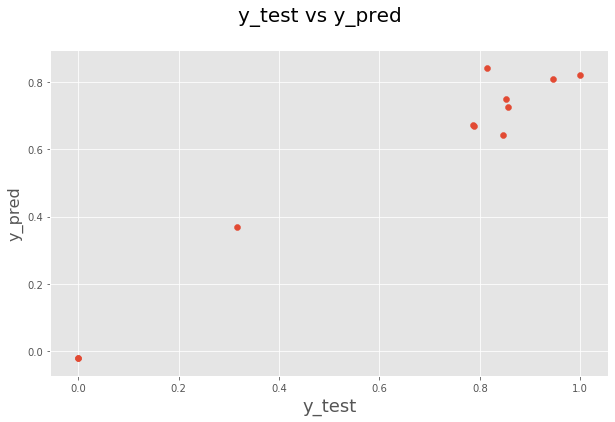

In [274]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      

### Elasticity - Camera Accessory

In [277]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_lm, y_train, coefficients_df)

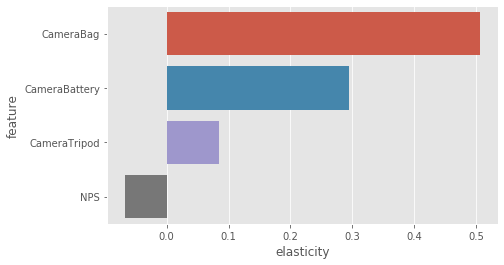

In [278]:
plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

### 3. Home Audio

In [279]:
final_home_audio_data_with_adstock.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,adStock_Radio,adStock_Other,gmv,units,sla,product_procurement_sla,product_mrp,selling_price,discount,NPS,total_transactions,total_holiday,is_holiday,total_special_sale_day,is_special_sale_day,total_pay_days,is_pay_days,COD_count,Prepaid_count,pct_online_transactions,BoomBox,DJController,Dock,DockingStation,FMRadio,HiFiSystem,HomeAudioSpeaker,SlingBox,SoundMixer,VoiceRecorder
0,27,7,2015,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0,7.366000e+04,32,3.093750,3.718750,4108.406250,2301.875000,0.384688,54.599588,32,1.0,1.0,0.0,0.0,1.0,1.0,1.0,31,0.97,4.0,0.0,0.0,0.0,2.0,0.0,26.0,0.0,0.0,0.0
1,28,7,2015,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,0.0,0.0,3.394594e+06,1888,7.618513,2.797753,3024.204387,1810.233886,0.335811,54.599588,1869,0.0,0.0,0.0,0.0,0.0,0.0,1442.0,427,0.23,60.0,0.0,30.0,1.0,478.0,13.0,1281.0,0.0,0.0,25.0
2,29,7,2015,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,0.0,0.0,4.012062e+06,2204,7.157391,2.723084,3158.978558,1824.581204,0.349612,54.599588,2192,0.0,0.0,2.0,1.0,1.0,1.0,1718.0,474,0.22,57.0,0.0,50.0,1.0,532.0,27.0,1511.0,0.0,0.0,26.0
3,30,7,2015,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,0.0,0.0,3.560271e+06,2004,7.137966,2.802618,3155.295065,1781.471803,0.348036,54.599588,1986,0.0,0.0,0.0,0.0,0.0,0.0,1588.0,398,0.20,65.0,0.0,56.0,0.0,509.0,20.0,1332.0,0.0,0.0,22.0
4,31,8,2015,0.052078,0.913194,2.003552,0.000220,0.343392,0.146684,1.805811,0.0,0.0,2.588403e+06,1419,7.291076,2.683428,3180.561615,1827.348442,0.345241,54.599588,1412,0.0,0.0,0.0,0.0,1.0,1.0,1117.0,295,0.21,37.0,0.0,44.0,0.0,372.0,11.0,939.0,0.0,0.0,16.0


In [282]:
# Dropping the unnecessary features which the company cannot control from the Home Audio data frame with KPIs
homeAudioDf = final_home_audio_data_with_adstock.drop(
    ['selling_price','units','product_mrp','total_transactions','COD_count', 'Prepaid_count'], 
    axis = 1
)

homeAudioDf.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_holiday',
       'is_holiday', 'total_special_sale_day', 'is_special_sale_day',
       'total_pay_days', 'is_pay_days', 'pct_online_transactions', 'BoomBox',
       'DJController', 'Dock', 'DockingStation', 'FMRadio', 'HiFiSystem',
       'HomeAudioSpeaker', 'SlingBox', 'SoundMixer', 'VoiceRecorder'],
      dtype='object')

In [283]:
# Doing the test-train split
np.random.seed(0)
df2_train, df2_test = train_test_split(homeAudioDf, train_size = 0.8, test_size = 0.2, random_state = 100)

In [284]:
scaler = MinMaxScaler()

# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars2 = [
    'adStock_TV', 'adStock_Digital', 'adStock_Sponsorship', 'adStock_Content Marketing', 'adStock_Online marketing',
    'adStock_ Affiliates', 'adStock_SEM', 'adStock_Radio', 'adStock_Other', 'gmv', 'sla', 'product_procurement_sla',
    'discount', 'NPS', 'total_holiday', 'total_special_sale_day', 'total_pay_days', 'pct_online_transactions', 
    'BoomBox', 'DJController', 'Dock', 'DockingStation', 'FMRadio', 'HiFiSystem', 'HomeAudioSpeaker', 'SlingBox', 
    'SoundMixer', 'VoiceRecorder'
]

df2_train[num_vars2] = scaler.fit_transform(df2_train[num_vars2])
df2_test[num_vars2] = scaler.fit_transform(df2_test[num_vars2])

In [285]:
# Splitting into X_train & y_train
y_train2 = df2_train.pop('gmv')
X_train2 = df2_train

### RFE

In [286]:
# Running RFE with the output number of the variable equal to 12
lm = LinearRegression()
lm.fit(X_train2, y_train2)

rfe = RFE(lm, 12)             # running RFE
rfe = rfe.fit(X_train2, y_train2)

In [287]:
# selecting the top 20 features given by rfe
col = X_train2.columns[rfe.support_]
col

Index(['adStock_TV', 'adStock_Digital', 'adStock_Sponsorship',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Other', 'pct_online_transactions', 'BoomBox', 'FMRadio',
       'HomeAudioSpeaker', 'VoiceRecorder'],
      dtype='object')

In [288]:
# checking the features not selected in top 12
X_train2.columns[~rfe.support_]

Index(['order_week', 'Month', 'Year', 'adStock_Content Marketing',
       'adStock_Radio', 'sla', 'product_procurement_sla', 'discount', 'NPS',
       'total_holiday', 'is_holiday', 'total_special_sale_day',
       'is_special_sale_day', 'total_pay_days', 'is_pay_days', 'DJController',
       'Dock', 'DockingStation', 'HiFiSystem', 'SlingBox', 'SoundMixer'],
      dtype='object')

In [289]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe2 = X_train2[col]

# Add a constant
X_train_lm2 = sm.add_constant(X_train_rfe2)

# Create a first fitted model
lr = sm.OLS(y_train2, X_train_lm2).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1863.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           3.97e-36
Time:                        20:49:54   Log-Likelihood:                 155.29
No. Observations:                  40   AIC:                            -284.6
Df Residuals:                      27   BIC:                            -262.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
4,adStock_Online marketing,1304.67
5,adStock_ Affiliates,1259.08
6,adStock_SEM,197.28
2,adStock_Digital,131.60
3,adStock_Sponsorship,47.30
0,const,33.78
1,adStock_TV,31.04
9,BoomBox,6.45
10,FMRadio,5.74
7,adStock_Other,5.47


In [290]:
# removing the feature based on the highest p-value
X_train2_new= X_train_rfe2.drop(["adStock_TV"], axis = 1)

# Add a constant
X_train_lm2 = sm.add_constant(X_train2_new)
   
lr = sm.OLS(y_train2, X_train_lm2).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     2061.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.14e-37
Time:                        20:50:43   Log-Likelihood:                 154.85
No. Observations:                  40   AIC:                            -285.7
Df Residuals:                      28   BIC:                            -265.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
3,adStock_Online marketing,385.10
4,adStock_ Affiliates,290.31
5,adStock_SEM,192.89
1,adStock_Digital,127.52
0,const,32.91
2,adStock_Sponsorship,6.25
9,FMRadio,5.68
8,BoomBox,3.93
10,HomeAudioSpeaker,3.61
11,VoiceRecorder,1.88


In [291]:
# removing the feature based on the highest p-value
X_train2_new1= X_train2_new.drop(["FMRadio"], axis = 1)
 
# Add a constant
X_train_lm2 = sm.add_constant(X_train2_new1)
    
lr = sm.OLS(y_train2, X_train_lm2).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     2172.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           7.04e-39
Time:                        20:51:27   Log-Likelihood:                 153.29
No. Observations:                  40   AIC:                            -284.6
Df Residuals:                      29   BIC:                            -266.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
3,adStock_Online marketing,340.42
4,adStock_ Affiliates,253.08
5,adStock_SEM,190.12
1,adStock_Digital,127.28
0,const,29.10
2,adStock_Sponsorship,6.18
8,BoomBox,3.35
9,HomeAudioSpeaker,2.71
6,adStock_Other,1.64
10,VoiceRecorder,1.57


In [292]:
# removing the feature on the basis of highest p-value
X_train2_new2 = X_train2_new1.drop(["adStock_Sponsorship"], axis = 1)
 
# Add a constant
X_train_lm2 = sm.add_constant(X_train2_new2)
   
lr = sm.OLS(y_train2, X_train_lm2).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     2250.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           6.46e-40
Time:                        20:52:12   Log-Likelihood:                 151.21
No. Observations:                  40   AIC:                            -282.4
Df Residuals:                      30   BIC:                            -265.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
2,adStock_Online marketing,334.69
3,adStock_ Affiliates,249.03
4,adStock_SEM,178.59
1,adStock_Digital,124.34
0,const,28.95
7,BoomBox,2.82
8,HomeAudioSpeaker,2.38
5,adStock_Other,1.53
6,pct_online_transactions,1.51
9,VoiceRecorder,1.45


In [293]:
# removing the feature based on highest p-value
X_train2_new3 = X_train2_new2.drop(["adStock_Other"], axis = 1)
 
# Add a constant
X_train_lm2 = sm.add_constant(X_train2_new3)
    # Create a first fitted model
lr = sm.OLS(y_train2, X_train_lm2).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     2331.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           7.18e-41
Time:                        20:53:00   Log-Likelihood:                 148.92
No. Observations:                  40   AIC:                            -279.8
Df Residuals:                      31   BIC:                            -264.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
2,adStock_Online marketing,332.28
3,adStock_ Affiliates,248.09
4,adStock_SEM,176.65
1,adStock_Digital,123.69
0,const,28.94
6,BoomBox,2.72
7,HomeAudioSpeaker,2.30
5,pct_online_transactions,1.49
8,VoiceRecorder,1.45


In [295]:
# removing the feature on the basis of highest vif values
X_train2_new4 = X_train2_new3.drop(["adStock_Online marketing"], axis = 1)
 
# Add a constant
X_train_lm2 = sm.add_constant(X_train2_new4)
    
lr = sm.OLS(y_train2, X_train_lm2).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1857.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           6.91e-40
Time:                        20:54:31   Log-Likelihood:                 141.08
No. Observations:                  40   AIC:                            -266.2
Df Residuals:                      32   BIC:                            -252.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

,Features,VIF
3,adStock_SEM,52.65
1,adStock_Digital,46.04
0,const,21.69
2,adStock_ Affiliates,3.69
5,BoomBox,2.62
6,HomeAudioSpeaker,2.28
7,VoiceRecorder,1.30
4,pct_online_transactions,1.20


In [296]:
# removing the features in the basis of highest p-values
X_train2_new5 = X_train2_new4.drop(["adStock_ Affiliates"], axis = 1)
 
# Add a constant
X_train_lm2 = sm.add_constant(X_train2_new5)
  
lr = sm.OLS(y_train2, X_train_lm2).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2230.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.44e-41
Time:                        20:55:19   Log-Likelihood:                 141.05
No. Observations:                  40   AIC:                            -268.1
Df Residuals:                      33   BIC:                            -256.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

,Features,VIF
1,adStock_Digital,25.24
2,adStock_SEM,24.63
0,const,9.76
5,HomeAudioSpeaker,1.87
4,BoomBox,1.82
6,VoiceRecorder,1.27
3,pct_online_transactions,1.17


In [297]:
# removing column on the bsis of highest p-value
X_train2_new6= X_train2_new5.drop(["adStock_SEM"], axis = 1)
 
# Add a constant
X_train_lm2 = sm.add_constant(X_train2_new6)
   
lr = sm.OLS(y_train2, X_train_lm2).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2754.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           2.63e-43
Time:                        20:55:47   Log-Likelihood:                 141.02
No. Observations:                  40   AIC:                            -270.0
Df Residuals:                      34   BIC:                            -259.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

,Features,VIF
0,const,9.73
4,HomeAudioSpeaker,1.79
3,BoomBox,1.77
1,adStock_Digital,1.60
5,VoiceRecorder,1.26
2,pct_online_transactions,1.16


In [299]:
# dropping feature on the basis of highest p-values
X_train2_new7 = X_train2_new6.drop(["adStock_Digital"], axis = 1)
 
# Add a constant
X_train_lm2 = sm.add_constant(X_train2_new7)
    
lr = sm.OLS(y_train2, X_train_lm2).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2.values, i) for i in range(X_train_lm2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     3360.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.05e-44
Time:                        20:56:49   Log-Likelihood:                 139.96
No. Observations:                  40   AIC:                            -269.9
Df Residuals:                      35   BIC:                            -261.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

,Features,VIF
0,const,9.73
2,BoomBox,1.63
3,HomeAudioSpeaker,1.60
4,VoiceRecorder,1.17
1,pct_online_transactions,1.16


In [300]:
## removing features on the basis of features which give lesser drop in adj. r2 values 
X_train2_new8 = X_train2_new7.drop(["pct_online_transactions"], axis = 1)

# Add a constant
X_train_lm2_2 = sm.add_constant(X_train2_new8)

lr = sm.OLS(y_train2, X_train_lm2_2).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2_2.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2_2.values, i) for i in range(X_train_lm2_2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     3882.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           3.07e-45
Time:                        20:58:47   Log-Likelihood:                 136.54
No. Observations:                  40   AIC:                            -265.1
Df Residuals:                      36   BIC:                            -258.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0202      0.004  

,Features,VIF
0,const,7.98
1,BoomBox,1.60
2,HomeAudioSpeaker,1.51
3,VoiceRecorder,1.17


In [302]:
# removing features to get lesser drop in adj r2 square value
X_train2_new9 = X_train2_new8.drop(["BoomBox"], axis = 1)
 
# Add a constant
X_train_lm2_3 = sm.add_constant(X_train2_new9)

lr3 = sm.OLS(y_train2, X_train_lm2_3).fit()

lr3.params
print(lr3.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm2_3.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm2_3.values, i) for i in range(X_train_lm2_3.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     4162.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           2.82e-44
Time:                        20:59:30   Log-Likelihood:                 129.30
No. Observations:                  40   AIC:                            -252.6
Df Residuals:                      37   BIC:                            -247.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0271      0.004  

,Features,VIF
0,const,6.23
1,HomeAudioSpeaker,1.01
2,VoiceRecorder,1.01


In [303]:
# Checking performance of top 3 models finding Adjusted R-squared
x_trains = [X_train_lm2, X_train_lm2_2, X_train_lm2_3]
for i in range(0,len(x_trains)):
    scores = cross_val_score(lm, x_trains[i], y_train2 , scoring='r2', cv=5)
    print("lr model",i+1,"r2_score", scores.mean())

lr model 1 r2_score 0.9784752105143552
lr model 2 r2_score 0.9738550597877802
lr model 3 r2_score 0.9717518881355973


#### Based upon the lowest number of features & the best model performance, we select model 3 as the best basic linear model for Home Audio Category

### Model Evaluation

In [306]:
y_test = df2_test.pop('gmv')
X_test = df2_test

In [307]:
X_test.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'sla', 'product_procurement_sla',
       'discount', 'NPS', 'total_holiday', 'is_holiday',
       'total_special_sale_day', 'is_special_sale_day', 'total_pay_days',
       'is_pay_days', 'pct_online_transactions', 'BoomBox', 'DJController',
       'Dock', 'DockingStation', 'FMRadio', 'HiFiSystem', 'HomeAudioSpeaker',
       'SlingBox', 'SoundMixer', 'VoiceRecorder'],
      dtype='object')

In [308]:
X_test = X_test[X_train_lm2_3.drop('const', axis = 1).columns]
X_test = sm.add_constant(X_test)
X_test

,const,HomeAudioSpeaker,VoiceRecorder
6,1.0,0.416162,0.375000
36,1.0,0.446061,0.894231
37,1.0,0.379394,0.894231
28,1.0,1.000000,0.730769
43,1.0,0.381414,1.000000
49,1.0,0.194343,0.240385
5,1.0,0.000000,0.000000
33,1.0,0.871515,0.798077
20,1.0,0.960000,0.394231
42,1.0,0.426263,0.932692


In [309]:
# Making predictions using the final model
y_pred = lr3.predict(X_test)

Text(0, 0.5, 'y_pred')

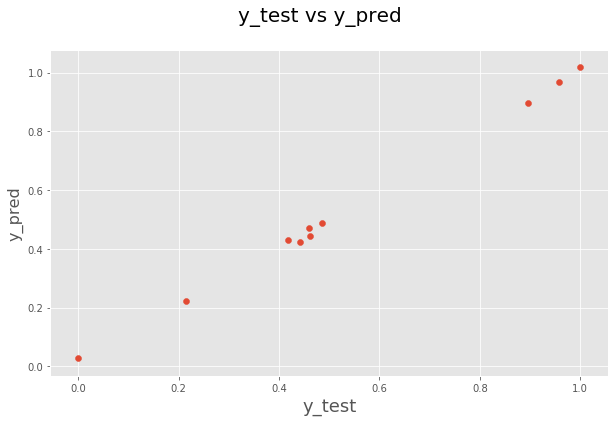

In [310]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      

### Elasticity - Home Audio - Basic Linear model

In [311]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr3.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_lm2_3, y_train2, coefficients_df)

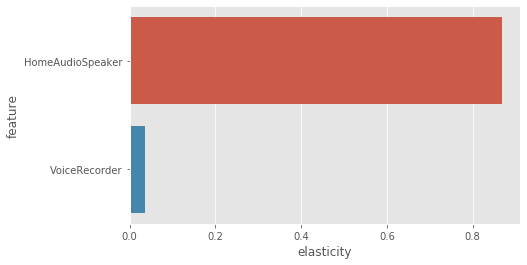

In [312]:
plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

### Building Multiplicative Models

### I. Gaming Accessory - Multiplicative model

In [343]:
final_gaming_data_with_adstock.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,adStock_Radio,adStock_Other,gmv,units,sla,product_procurement_sla,product_mrp,selling_price,discount,NPS,total_transactions,total_holiday,is_holiday,total_special_sale_day,is_special_sale_day,total_pay_days,is_pay_days,COD_count,Prepaid_count,pct_online_transactions,CoolingPad,GameControlMount,GamePad,GamingAccessoryKit,GamingAdapter,GamingChargingStation,GamingHeadset,GamingKeyboard,GamingMemoryCard,GamingMouse,GamingMousePad,GamingSpeaker,JoystickGamingWheel,MotionController,TVOutCableAccessory
0,27,7,2015,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0,2.234400e+04,24,3.458333,3.208333,3504.125000,931.000000,0.316250,54.599588,24,1.0,1.0,0.0,0.0,1.0,1.0,0.0,24.0,1.00,0.0,0.0,14.0,2.0,0.0,0.0,2.0,1.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0
1,28,7,2015,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,0.0,0.0,1.866719e+06,2767,5.375094,3.245660,1667.559623,685.125660,0.421543,54.599588,2650,0.0,0.0,0.0,0.0,0.0,0.0,1969.0,681.0,0.26,0.0,0.0,861.0,100.0,48.0,0.0,177.0,424.0,36.0,966.0,55.0,0.0,11.0,16.0,73.0
2,29,7,2015,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,0.0,0.0,1.585166e+06,2704,5.268747,2.721119,1638.086745,630.567636,0.451228,54.599588,2467,0.0,0.0,2.0,1.0,1.0,1.0,1901.0,566.0,0.23,0.0,0.0,1647.0,129.0,44.0,0.0,179.0,162.0,27.0,357.0,48.0,0.0,8.0,11.0,92.0
3,30,7,2015,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,0.0,0.0,1.722134e+06,2231,5.459259,2.592130,2139.344907,784.834954,0.398009,54.599588,2160,0.0,0.0,0.0,0.0,0.0,0.0,1680.0,480.0,0.22,0.0,0.0,921.0,166.0,35.0,0.0,283.0,170.0,28.0,448.0,67.0,0.0,9.0,11.0,93.0
4,31,8,2015,0.052078,0.913194,2.003552,0.000220,0.343392,0.146684,1.805811,0.0,0.0,1.298391e+06,1619,5.713094,3.237484,5311.397304,816.840180,0.464647,54.603046,1558,0.0,0.0,0.0,0.0,1.0,1.0,1250.0,308.0,0.20,0.0,0.0,611.0,95.0,31.0,0.0,424.0,71.0,11.0,232.0,39.0,1.0,17.0,8.0,79.0


In [344]:
# replacing '0.0' with '0.0000001' and taking log of the dataset to avaoid the nana values for log 0
df = np.log(
    final_gaming_data_with_adstock.replace(0.0, 0.000001).drop(
        ['selling_price','units','product_mrp','total_transactions','COD_count', 'Prepaid_count'], 
        axis = 1
    )
)

In [345]:
df.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,adStock_Radio,adStock_Other,gmv,sla,product_procurement_sla,discount,NPS,total_holiday,is_holiday,total_special_sale_day,is_special_sale_day,total_pay_days,is_pay_days,pct_online_transactions,CoolingPad,GameControlMount,GamePad,GamingAccessoryKit,GamingAdapter,GamingChargingStation,GamingHeadset,GamingKeyboard,GamingMemoryCard,GamingMouse,GamingMousePad,GamingSpeaker,JoystickGamingWheel,MotionController,TVOutCableAccessory
0,3.295837,1.945910,7.608374,-2.921877,-0.456885,0.617112,-8.363510,-1.103164,-1.989137,0.227872,-13.815511,-13.815511,10.014313,1.240787,1.165752,-1.151222,4.000026,0.000000,0.000000,-13.815511,-13.815511,0.000000,0.000000,0.000000,-13.815511,-13.815511,2.639057,0.693147,-13.815511,-13.815511,0.693147,0.000000,-13.815511,1.386294,0.000000,-13.815511,-13.815511,-13.815511,-13.815511
1,3.332205,1.945910,7.608374,-2.516412,-0.051419,1.022577,-7.958044,-0.697699,-1.583672,0.633337,-13.815511,-13.815511,14.439693,1.681776,1.177319,-0.863833,4.000026,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-1.347074,-13.815511,-13.815511,6.758095,4.605170,3.871201,-13.815511,5.176150,6.049733,3.583519,6.873164,4.007333,-13.815511,2.397895,2.772589,4.290459
2,3.367296,1.945910,7.608374,-2.362261,0.102731,1.176728,-7.803894,-0.543549,-1.429521,0.787488,-13.815511,-13.815511,14.276200,1.661793,1.001043,-0.795782,4.000026,-13.815511,-13.815511,0.693147,0.000000,0.000000,0.000000,-1.469676,-13.815511,-13.815511,7.406711,4.859812,3.784190,-13.815511,5.187386,5.087596,3.295837,5.877736,3.871201,-13.815511,2.079442,2.397895,4.521789
3,3.401197,1.945910,7.608374,-2.293268,0.171724,1.245721,-7.734901,-0.474556,-1.360528,0.856481,-13.815511,-13.815511,14.359075,1.697313,0.952480,-0.921280,4.000026,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-1.514128,-13.815511,-13.815511,6.825460,5.111988,3.555348,-13.815511,5.645447,5.135798,3.332205,6.104793,4.204693,-13.815511,2.197225,2.397895,4.532599
4,3.433987,2.079442,7.608374,-2.955022,-0.090807,0.694922,-8.420842,-1.068883,-1.919477,0.591010,-13.815511,-13.815511,14.076636,1.742761,1.174796,-0.766477,4.000090,-13.815511,-13.815511,-13.815511,-13.815511,0.000000,0.000000,-1.609438,-13.815511,-13.815511,6.415097,4.553877,3.433987,-13.815511,6.049733,4.262680,2.397895,5.446737,3.663562,0.000000,2.833213,2.079442,4.369448


In [346]:
# Test-train split
df_train, df_test = train_test_split(df, train_size = 0.8, test_size = 0.20, random_state = 100)

In [347]:
# initialising scaler
scaler = MinMaxScaler()

In [348]:
# checking the columns
df.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_holiday',
       'is_holiday', 'total_special_sale_day', 'is_special_sale_day',
       'total_pay_days', 'is_pay_days', 'pct_online_transactions',
       'CoolingPad', 'GameControlMount', 'GamePad', 'GamingAccessoryKit',
       'GamingAdapter', 'GamingChargingStation', 'GamingHeadset',
       'GamingKeyboard', 'GamingMemoryCard', 'GamingMouse', 'GamingMousePad',
       'GamingSpeaker', 'JoystickGamingWheel', 'MotionController',
       'TVOutCableAccessory'],
      dtype='object')

In [349]:
# Apply scaler() to all the columns except the categorical features
num_vars = [
    'adStock_TV', 'adStock_Digital',
    'adStock_Sponsorship', 'adStock_Content Marketing',
    'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
    'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
    'product_procurement_sla', 'discount', 'NPS', 'total_holiday',
    'total_special_sale_day',
    'total_pay_days', 'pct_online_transactions',
    'CoolingPad', 'GameControlMount', 'GamePad', 'GamingAccessoryKit',
    'GamingAdapter', 'GamingChargingStation', 'GamingHeadset',
    'GamingKeyboard', 'GamingMemoryCard', 'GamingMouse', 'GamingMousePad',
    'GamingSpeaker', 'JoystickGamingWheel', 'MotionController',
    'TVOutCableAccessory'
]

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [350]:
# assigning the values for x_train and y_train
y_train = df_train.pop('gmv')
X_train = df_train

In [351]:
# Running RFE for selecting top 12 features
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 12)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [352]:
# selecting the top 12 features given by rfe
col = X_train.columns[rfe.support_]
col

Index(['Year', 'adStock_Online marketing', 'adStock_ Affiliates',
       'pct_online_transactions', 'GamePad', 'GamingAccessoryKit',
       'GamingAdapter', 'GamingHeadset', 'GamingKeyboard', 'GamingMouse',
       'JoystickGamingWheel', 'TVOutCableAccessory'],
      dtype='object')

In [353]:
# neglecting the features not selected in top 12 by rfe
X_train.columns[~rfe.support_]

Index(['order_week', 'Month', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'sla', 'product_procurement_sla',
       'discount', 'NPS', 'total_holiday', 'is_holiday',
       'total_special_sale_day', 'is_special_sale_day', 'total_pay_days',
       'is_pay_days', 'CoolingPad', 'GameControlMount',
       'GamingChargingStation', 'GamingMemoryCard', 'GamingMousePad',
       'GamingSpeaker', 'MotionController'],
      dtype='object')

In [354]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [355]:
# Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    
# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2330.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           7.10e-40
Time:                        22:15:15   Log-Likelihood:                 154.40
No. Observations:                  42   AIC:                            -282.8
Df Residuals:                      29   BIC:                            -260.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,2.689631e+09
3,adStock_ Affiliates,2.235860e+03
2,adStock_Online marketing,2.166350e+03
7,GamingAdapter,3.520000e+02
9,GamingKeyboard,3.409500e+02
6,GamingAccessoryKit,1.881200e+02
12,TVOutCableAccessory,1.863600e+02
8,GamingHeadset,8.307000e+01
4,pct_online_transactions,8.183000e+01
10,GamingMouse,7.885000e+01


In [356]:
# Let's drop feature  with highest p-value
X_train_new = X_train_rfe.drop(["Year"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2606.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.53e-41
Time:                        22:15:16   Log-Likelihood:                 154.21
No. Observations:                  42   AIC:                            -284.4
Df Residuals:                      30   BIC:                            -263.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
2,adStock_ Affiliates,1830.82
1,adStock_Online marketing,1801.03
0,const,1352.96
6,GamingAdapter,343.51
8,GamingKeyboard,305.23
11,TVOutCableAccessory,183.49
5,GamingAccessoryKit,179.62
7,GamingHeadset,83.06
3,pct_online_transactions,80.29
9,GamingMouse,78.65


In [357]:
# Let's drop with highest p-value
X_train_new1 = X_train_new.drop(["adStock_ Affiliates"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new1)
    
# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2873.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           4.37e-43
Time:                        22:15:17   Log-Likelihood:                 153.57
No. Observations:                  42   AIC:                            -285.1
Df Residuals:                      31   BIC:                            -266.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,1167.08
7,GamingKeyboard,286.89
5,GamingAdapter,217.51
10,TVOutCableAccessory,174.72
4,GamingAccessoryKit,112.06
8,GamingMouse,70.10
6,GamingHeadset,68.80
3,GamePad,63.80
2,pct_online_transactions,51.50
9,JoystickGamingWheel,33.69


In [358]:
# Let's drop feature with highest p-value
X_train_new2 = X_train_new1.drop(["adStock_Online marketing"], axis = 1)

# Add a constant
X_train_lm = sm.add_constant(X_train_new2)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3287.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           7.64e-45
Time:                        22:15:17   Log-Likelihood:                 153.52
No. Observations:                  42   AIC:                            -287.0
Df Residuals:                      32   BIC:                            -269.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

,Features,VIF
0,const,370.56
4,GamingAdapter,214.64
9,TVOutCableAccessory,173.82
3,GamingAccessoryKit,110.58
6,GamingKeyboard,108.32
2,GamePad,62.84
1,pct_online_transactions,36.35
8,JoystickGamingWheel,32.62
7,GamingMouse,22.26
5,GamingHeadset,21.26


In [359]:
# Let's remove feature  with highest p-value
X_train_new3 = X_train_new2.drop(["GamingAdapter"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new3)
    
# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3782.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.36e-46
Time:                        22:15:18   Log-Likelihood:                 153.35
No. Observations:                  42   AIC:                            -288.7
Df Residuals:                      33   BIC:                            -273.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

,Features,VIF
0,const,347.99
3,GamingAccessoryKit,106.43
5,GamingKeyboard,102.64
2,GamePad,61.98
8,TVOutCableAccessory,49.32
1,pct_online_transactions,35.47
7,JoystickGamingWheel,25.08
6,GamingMouse,20.98
4,GamingHeadset,19.50


In [360]:
# Let's drop feature  with higest p-value
X_train_new4 = X_train_new3.drop(["TVOutCableAccessory"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new4)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     4298.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           3.58e-48
Time:                        22:15:19   Log-Likelihood:                 152.60
No. Observations:                  42   AIC:                            -289.2
Df Residuals:                      34   BIC:                            -275.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

,Features,VIF
0,const,336.96
3,GamingAccessoryKit,105.96
5,GamingKeyboard,101.91
2,GamePad,46.18
1,pct_online_transactions,34.29
6,GamingMouse,20.37
4,GamingHeadset,19.49
7,JoystickGamingWheel,14.14


In [361]:
# dropping the feature with highest vig values
X_train_new5 = X_train_new4.drop(["GamingAccessoryKit"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new5)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     3720.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.45e-47
Time:                        22:15:19   Log-Likelihood:                 145.73
No. Observations:                  42   AIC:                            -277.5
Df Residuals:                      35   BIC:                            -265.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

,Features,VIF
0,const,237.68
4,GamingKeyboard,100.55
2,GamePad,40.74
1,pct_online_transactions,23.33
3,GamingHeadset,14.63
5,GamingMouse,14.15
6,JoystickGamingWheel,13.91


In [362]:
# dropping the feature with highest vif values
X_train_new6 = X_train_new5.drop(["GamingKeyboard"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new6)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     3859.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           4.59e-48
Time:                        22:15:20   Log-Likelihood:                 142.09
No. Observations:                  42   AIC:                            -272.2
Df Residuals:                      36   BIC:                            -261.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

,Features,VIF
0,const,163.25
2,GamePad,28.84
5,JoystickGamingWheel,13.71
3,GamingHeadset,12.35
4,GamingMouse,9.44
1,pct_online_transactions,6.96


In [363]:
# dropping the feature with highest vif values
X_train_new7 = X_train_new6.drop(["GamePad"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new7)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     1292.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           3.49e-39
Time:                        22:15:21   Log-Likelihood:                 113.96
No. Observations:                  42   AIC:                            -217.9
Df Residuals:                      37   BIC:                            -209.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

,Features,VIF
0,const,138.05
4,JoystickGamingWheel,8.63
3,GamingMouse,7.69
2,GamingHeadset,7.61
1,pct_online_transactions,6.96


In [364]:
# dropping the feature with highest vif values
X_train_new8 = X_train_new7.drop(["JoystickGamingWheel"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new8)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     945.7
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           9.98e-36
Time:                        22:15:21   Log-Likelihood:                 100.93
No. Observations:                  42   AIC:                            -193.9
Df Residuals:                      38   BIC:                            -186.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

,Features,VIF
0,const,54.43
1,pct_online_transactions,5.12
3,GamingMouse,2.98
2,GamingHeadset,2.69


In [365]:
# dropping the feature with highest vif values
X_train_new9 = X_train_new8.drop(["pct_online_transactions"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new9)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     919.8
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.54e-33
Time:                        22:15:22   Log-Likelihood:                 91.452
No. Observations:                  42   AIC:                            -176.9
Df Residuals:                      39   BIC:                            -171.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.3794      0.029    -13.111

,Features,VIF
0,const,43.44
1,GamingHeadset,1.53
2,GamingMouse,1.53


In [366]:
# k-fold Cross Validation - Adjusted R-squared
lm = LinearRegression()

# Checking performance of above models by finding Adjusted R-squared
x_trains = [X_train_lm]
for i in range(0,len(x_trains)):
    x_test = x_trains[i]
    scores = cross_val_score(lm, x_test, y_train , scoring='r2', cv=5)
    print("lr model",i+1,"r2_score", scores.mean())

lr model 1 r2_score 0.6431453826742386


### Elasticity

In [367]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_lm, y_train, coefficients_df)

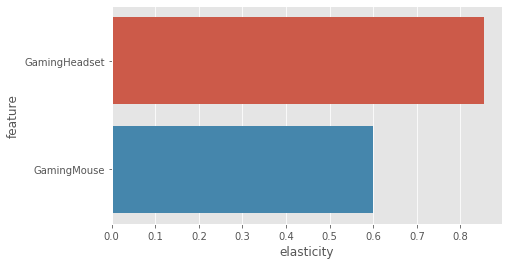

In [368]:
plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

### Model Evaluation

In [369]:
y_test = df_test.pop('gmv')
X_test = df_test

In [370]:
X_test = X_test[X_train_lm.drop('const', axis = 1).columns]
X_test = sm.add_constant(X_test)
X_test.head()

,const,GamingHeadset,GamingMouse
25,1.0,0.980153,0.976782
48,1.0,0.914388,0.968914
52,1.0,0.806907,0.913395
37,1.0,0.869851,0.947967
6,1.0,0.000000,0.000000


In [371]:
# Making predictions using the model
y_pred = lr.predict(X_test)

Text(0, 0.5, 'y_pred')

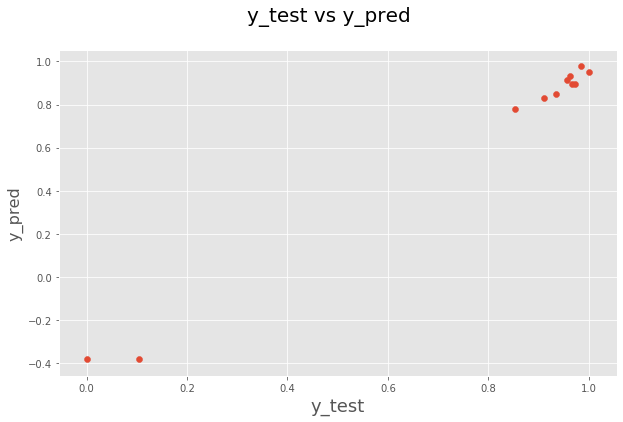

In [372]:
# Plotting y_test and y_pred to understand the spread
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)

### II. Camera Accessory - Multiplicative model

In [373]:
# taking the camera accessory dataset
final_camera_data_with_adstock.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,adStock_Radio,adStock_Other,gmv,units,sla,product_procurement_sla,product_mrp,selling_price,discount,NPS,total_transactions,total_holiday,is_holiday,total_special_sale_day,is_special_sale_day,total_pay_days,is_pay_days,COD_count,Prepaid_count,pct_online_transactions,Binoculars,CameraAccessory,CameraBag,CameraBattery,CameraBatteryCharger,CameraBatteryGrip,CameraEyeCup,CameraFilmRolls,CameraHousing,CameraMicrophone,CameraMount,CameraRemoteControl,CameraTripod,ExtensionTube,Filter,Flash,FlashShoeAdapter,Lens,ReflectorUmbrella,Softbox,Strap,Telescope
0,27,7,2015,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0,15375.0,25,2.280000,2.960000,1456.840000,615.000000,0.525600,54.599588,25,1.0,1.0,0.0,0.0,1.0,1.0,0.0,25.0,1.00,1.0,1.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1,28,7,2015,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,0.0,0.0,2019042.0,2752,7.156274,2.742586,1646.428137,751.233460,0.462194,54.599588,2630,0.0,0.0,0.0,0.0,0.0,0.0,1796.0,834.0,0.32,193.0,45.0,328.0,735.0,224.0,11.0,0.0,0.0,0.0,0.0,4.0,141.0,433.0,0.0,226.0,17.0,0.0,366.0,0.0,0.0,13.0,16.0
2,29,7,2015,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,0.0,0.0,2249245.0,2917,6.491321,2.764789,1630.936238,783.509033,0.465349,54.599588,2823,0.0,0.0,2.0,1.0,1.0,1.0,1906.0,917.0,0.32,247.0,30.0,351.0,770.0,228.0,5.0,0.0,0.0,0.0,0.0,11.0,145.0,491.0,0.0,188.0,23.0,0.0,382.0,0.0,0.0,24.0,22.0
3,30,7,2015,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,0.0,0.0,2105858.0,2888,6.488138,2.831776,1560.504313,740.930625,0.455913,54.599588,2782,0.0,0.0,0.0,0.0,0.0,0.0,1914.0,868.0,0.31,209.0,44.0,284.0,812.0,270.0,9.0,0.0,0.0,0.0,0.0,7.0,108.0,457.0,0.0,194.0,18.0,0.0,423.0,0.0,0.0,23.0,30.0
4,31,8,2015,0.052078,0.913194,2.003552,0.000220,0.343392,0.146684,1.805811,0.0,0.0,1426134.0,1932,6.470684,2.777959,1524.232356,756.820304,0.450456,54.605438,1842,0.0,0.0,0.0,0.0,1.0,1.0,1315.0,527.0,0.29,144.0,41.0,175.0,516.0,194.0,8.0,0.0,0.0,0.0,0.0,2.0,82.0,363.0,0.0,112.0,26.0,0.0,233.0,0.0,0.0,23.0,13.0


In [374]:
# replacing '0' with '0.0000001' to avaoid NAN values when we take log of the dataset
final_camera_data_with_adstock.replace(0.0, 0.000001).head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,adStock_Radio,adStock_Other,gmv,units,sla,product_procurement_sla,product_mrp,selling_price,discount,NPS,total_transactions,total_holiday,is_holiday,total_special_sale_day,is_special_sale_day,total_pay_days,is_pay_days,COD_count,Prepaid_count,pct_online_transactions,Binoculars,CameraAccessory,CameraBag,CameraBattery,CameraBatteryCharger,CameraBatteryGrip,CameraEyeCup,CameraFilmRolls,CameraHousing,CameraMicrophone,CameraMount,CameraRemoteControl,CameraTripod,ExtensionTube,Filter,Flash,FlashShoeAdapter,Lens,ReflectorUmbrella,Softbox,Strap,Telescope
0,27,7,2015,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.000001,0.000001,15375.0,25,2.280000,2.960000,1456.840000,615.000000,0.525600,54.599588,25,1.000000,1.000000,0.000001,0.000001,1.000000,1.000000,0.000001,25.0,1.00,1.0,1.0,2.0,4.0,1.0,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,1.0,13.0,0.000001,0.000001,0.000001,0.000001,2.0,0.000001,0.000001,0.000001,0.000001
1,28,7,2015,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,0.000001,0.000001,2019042.0,2752,7.156274,2.742586,1646.428137,751.233460,0.462194,54.599588,2630,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,1796.000000,834.0,0.32,193.0,45.0,328.0,735.0,224.0,11.000000,0.000001,0.000001,0.000001,0.000001,4.000000,141.0,433.0,0.000001,226.000000,17.000000,0.000001,366.0,0.000001,0.000001,13.000000,16.000000
2,29,7,2015,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,0.000001,0.000001,2249245.0,2917,6.491321,2.764789,1630.936238,783.509033,0.465349,54.599588,2823,0.000001,0.000001,2.000000,1.000000,1.000000,1.000000,1906.000000,917.0,0.32,247.0,30.0,351.0,770.0,228.0,5.000000,0.000001,0.000001,0.000001,0.000001,11.000000,145.0,491.0,0.000001,188.000000,23.000000,0.000001,382.0,0.000001,0.000001,24.000000,22.000000
3,30,7,2015,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,0.000001,0.000001,2105858.0,2888,6.488138,2.831776,1560.504313,740.930625,0.455913,54.599588,2782,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,1914.000000,868.0,0.31,209.0,44.0,284.0,812.0,270.0,9.000000,0.000001,0.000001,0.000001,0.000001,7.000000,108.0,457.0,0.000001,194.000000,18.000000,0.000001,423.0,0.000001,0.000001,23.000000,30.000000
4,31,8,2015,0.052078,0.913194,2.003552,0.000220,0.343392,0.146684,1.805811,0.000001,0.000001,1426134.0,1932,6.470684,2.777959,1524.232356,756.820304,0.450456,54.605438,1842,0.000001,0.000001,0.000001,0.000001,1.000000,1.000000,1315.000000,527.0,0.29,144.0,41.0,175.0,516.0,194.0,8.000000,0.000001,0.000001,0.000001,0.000001,2.000000,82.0,363.0,0.000001,112.000000,26.000000,0.000001,233.0,0.000001,0.000001,23.000000,13.000000


In [375]:
# taking log and dropping the uncotrollable featues
df = np.log(
    final_camera_data_with_adstock.replace(0.0, 0.000001).drop(
        ['selling_price','units','product_mrp','total_transactions','COD_count', 'Prepaid_count'], 
        axis = 1
    )
)

In [376]:
# Test-train split
df_train, df_test = train_test_split(df, train_size = 0.8, test_size = 0.2, random_state = 100)

In [377]:
# scaling 
scaler = MinMaxScaler()

In [378]:
# checking the features in the dataset
df.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_holiday',
       'is_holiday', 'total_special_sale_day', 'is_special_sale_day',
       'total_pay_days', 'is_pay_days', 'pct_online_transactions',
       'Binoculars', 'CameraAccessory', 'CameraBag', 'CameraBattery',
       'CameraBatteryCharger', 'CameraBatteryGrip', 'CameraEyeCup',
       'CameraFilmRolls', 'CameraHousing', 'CameraMicrophone', 'CameraMount',
       'CameraRemoteControl', 'CameraTripod', 'ExtensionTube', 'Filter',
       'Flash', 'FlashShoeAdapter', 'Lens', 'ReflectorUmbrella', 'Softbox',
       'Strap', 'Telescope'],
      dtype='object')

In [379]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables

num_vars = [
    'adStock_TV', 'adStock_Digital',
    'adStock_Sponsorship', 'adStock_Content Marketing',
    'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
    'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
    'product_procurement_sla', 'discount', 'NPS', 'total_holiday',
    'total_special_sale_day',
    'total_pay_days', 'pct_online_transactions',
    'Binoculars', 'CameraAccessory', 'CameraBag', 'CameraBattery',
    'CameraBatteryCharger', 'CameraBatteryGrip', 'CameraEyeCup',
    'CameraFilmRolls', 'CameraHousing', 'CameraMicrophone', 'CameraMount',
    'CameraRemoteControl', 'CameraTripod', 'ExtensionTube', 'Filter',
    'Flash', 'FlashShoeAdapter', 'Lens', 'ReflectorUmbrella', 'Softbox',
    'Strap', 'Telescope'
]

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [380]:
# assigning x_traim amd y_train values
y_train = df_train.pop('gmv')
X_train = df_train

In [381]:
# Running RFE for selecting top 12 features
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 12)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [382]:
# selecting the top 12 features given by rfe
col = X_train.columns[rfe.support_]
col

Index(['Year', 'adStock_Radio', 'sla', 'Binoculars', 'CameraAccessory',
       'CameraBatteryCharger', 'CameraMount', 'CameraRemoteControl',
       'CameraTripod', 'Flash', 'Lens', 'Telescope'],
      dtype='object')

In [383]:
# neglecting the features other than top 20 features given by rfe
X_train.columns[~rfe.support_]

Index(['order_week', 'Month', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Other', 'product_procurement_sla', 'discount', 'NPS',
       'total_holiday', 'is_holiday', 'total_special_sale_day',
       'is_special_sale_day', 'total_pay_days', 'is_pay_days',
       'pct_online_transactions', 'CameraBag', 'CameraBattery',
       'CameraBatteryGrip', 'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing',
       'CameraMicrophone', 'ExtensionTube', 'Filter', 'FlashShoeAdapter',
       'ReflectorUmbrella', 'Softbox', 'Strap'],
      dtype='object')

In [384]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [385]:
# Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    
# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1438.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           9.86e-36
Time:                        22:20:06   Log-Likelihood:                 146.97
No. Observations:                  41   AIC:                            -267.9
Df Residuals:                      28   BIC:                            -245.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  821.8660 

,Features,VIF
0,const,1.081907e+11
8,CameraRemoteControl,3.468500e+02
6,CameraBatteryCharger,3.250000e+02
4,Binoculars,2.748900e+02
9,CameraTripod,1.930200e+02
12,Telescope,1.346100e+02
5,CameraAccessory,1.242400e+02
1,Year,1.133000e+02
7,CameraMount,1.066400e+02
2,adStock_Radio,8.835000e+01


In [386]:
# drop feature units with highest p-value 
X_train_new = X_train_rfe.drop(["Binoculars"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new)
   
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1622.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           2.44e-37
Time:                        22:24:38   Log-Likelihood:                 146.93
No. Observations:                  41   AIC:                            -269.9
Df Residuals:                      29   BIC:                            -249.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  804.0198 

,Features,VIF
0,const,1.048214e+11
7,CameraRemoteControl,3.272300e+02
5,CameraBatteryCharger,2.866200e+02
8,CameraTripod,1.640500e+02
11,Telescope,1.308300e+02
4,CameraAccessory,1.242400e+02
1,Year,1.097700e+02
6,CameraMount,1.066300e+02
2,adStock_Radio,8.574000e+01
9,Flash,5.212000e+01


In [387]:
# Let's drop featuree with highest p-value
X_train_new1 = X_train_new.drop(["Telescope"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new1)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1838.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           5.84e-39
Time:                        22:25:06   Log-Likelihood:                 146.85
No. Observations:                  41   AIC:                            -271.7
Df Residuals:                      30   BIC:                            -252.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  832.5679 

,Features,VIF
0,const,1.002761e+11
7,CameraRemoteControl,3.149200e+02
5,CameraBatteryCharger,2.577900e+02
8,CameraTripod,1.601800e+02
4,CameraAccessory,1.138900e+02
1,Year,1.050100e+02
2,adStock_Radio,8.018000e+01
6,CameraMount,7.873000e+01
9,Flash,5.139000e+01
10,Lens,2.253000e+01


In [388]:
# Let's drop feature  with highest p-value
X_train_new2 = X_train_new1.drop(["CameraRemoteControl"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new2)
   
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     2074.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.60e-40
Time:                        22:25:38   Log-Likelihood:                 146.49
No. Observations:                  41   AIC:                            -273.0
Df Residuals:                      31   BIC:                            -255.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  809.1293 

,Features,VIF
0,const,9.957988e+10
7,CameraTripod,1.447600e+02
5,CameraBatteryCharger,1.295000e+02
1,Year,1.042800e+02
4,CameraAccessory,1.011300e+02
2,adStock_Radio,7.978000e+01
6,CameraMount,7.600000e+01
8,Flash,5.028000e+01
9,Lens,2.251000e+01
3,sla,2.015000e+01


In [389]:
# Let's remove feature with highest p-value
X_train_new3 = X_train_new2.drop(["Flash"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new3)
    
# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     2359.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           4.37e-42
Time:                        22:26:14   Log-Likelihood:                 146.07
No. Observations:                  41   AIC:                            -274.1
Df Residuals:                      32   BIC:                            -258.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  762.3575 

,Features,VIF
0,const,9.732147e+10
7,CameraTripod,1.419500e+02
5,CameraBatteryCharger,1.272400e+02
1,Year,1.019100e+02
4,CameraAccessory,9.959000e+01
2,adStock_Radio,7.953000e+01
6,CameraMount,4.839000e+01
3,sla,1.971000e+01
8,Lens,1.564000e+01


In [390]:
# drop feature  with higest p-value
X_train_new4 = X_train_new3.drop(["sla"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new4)
    
# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     2525.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           3.87e-43
Time:                        22:26:47   Log-Likelihood:                 144.10
No. Observations:                  41   AIC:                            -272.2
Df Residuals:                      33   BIC:                            -258.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1178.3530 

,Features,VIF
0,const,6.089402e+10
4,CameraBatteryCharger,1.191400e+02
3,CameraAccessory,7.814000e+01
6,CameraTripod,6.517000e+01
1,Year,6.378000e+01
2,adStock_Radio,5.971000e+01
5,CameraMount,1.495000e+01
7,Lens,1.264000e+01


In [391]:
# dropping the feature with highest vif values
X_train_new5 = X_train_new4.drop(["CameraBatteryCharger"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new5)
    
# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2597.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           9.48e-44
Time:                        22:27:29   Log-Likelihood:                 140.90
No. Observations:                  41   AIC:                            -267.8
Df Residuals:                      34   BIC:                            -255.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             916.5787    307.558     

,Features,VIF
0,const,5.306249e+10
2,adStock_Radio,5.571000e+01
1,Year,5.557000e+01
5,CameraTripod,4.871000e+01
3,CameraAccessory,4.864000e+01
4,CameraMount,1.442000e+01
6,Lens,1.199000e+01


In [392]:
# dropping the feature with highest p-value
X_train_new6 = X_train_new5.drop(["CameraAccessory"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new6)
    
# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     3125.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           2.50e-45
Time:                        22:27:55   Log-Likelihood:                 140.36
No. Observations:                  41   AIC:                            -268.7
Df Residuals:                      35   BIC:                            -258.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           924.1195    307.013      3.010

,Features,VIF
0,const,5.302719e+10
2,adStock_Radio,5.567000e+01
1,Year,5.554000e+01
3,CameraMount,1.439000e+01
5,Lens,1.190000e+01
4,CameraTripod,2.970000e+00


In [393]:
# dropping the feature with highest vif values
X_train_new7= X_train_new6.drop(["adStock_Radio"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new7)
    
# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     3065.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           4.73e-45
Time:                        22:28:21   Log-Likelihood:                 134.83
No. Observations:                  41   AIC:                            -259.7
Df Residuals:                      36   BIC:                            -251.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -76.6973     49.255     -1.557   

,Features,VIF
0,const,1.071727e+09
2,CameraMount,1.417000e+01
4,Lens,1.173000e+01
3,CameraTripod,2.970000e+00
1,Year,1.120000e+00


In [394]:
# dropping the feature with highest p-value
X_train_new8= X_train_new7.drop(["Year"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new8)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     3934.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           2.23e-46
Time:                        22:33:29   Log-Likelihood:                 133.50
No. Observations:                  41   AIC:                            -259.0
Df Residuals:                      37   BIC:                            -252.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0235      0.010     -2.398   

,Features,VIF
0,const,40.71
1,CameraMount,13.88
3,Lens,11.73
2,CameraTripod,2.84


In [396]:
# dropping the feature with highest vif values
X_train_new9= X_train_new8.drop(["CameraMount"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new9)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     2086.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.43e-39
Time:                        22:34:06   Log-Likelihood:                 111.75
No. Observations:                  41   AIC:                            -217.5
Df Residuals:                      38   BIC:                            -212.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0404      0.016     -2.518   

,Features,VIF
0,const,38.96
1,CameraTripod,2.40
2,Lens,2.40


In [397]:
# k-fold Cross Validation - Adjusted R-squared
lm = LinearRegression()
#Checking performance of top 4 models finding Adjusted R-squared
x_trains = [X_train_lm]
for i in range(0,len(x_trains)):
    x_test = x_trains[i]
    scores = cross_val_score(lm, x_test, y_train , scoring='r2', cv=5)
    print("lr model",i+1,"r2_score", scores.mean())

lr model 1 r2_score 0.8579969745741632


### Residual Analysis

In [398]:
y_train_price = lr.predict(X_train_lm)

Text(0.5, 0, 'Errors')

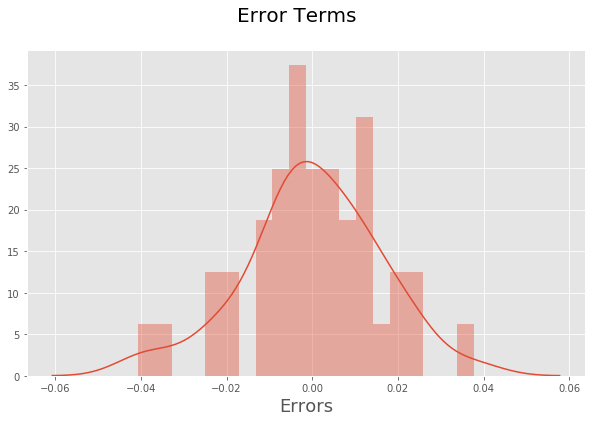

In [399]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

### Model Evaluation

In [400]:
y_test = df_test.pop('gmv')
X_test = df_test

In [401]:
X_test.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'sla', 'product_procurement_sla',
       'discount', 'NPS', 'total_holiday', 'is_holiday',
       'total_special_sale_day', 'is_special_sale_day', 'total_pay_days',
       'is_pay_days', 'pct_online_transactions', 'Binoculars',
       'CameraAccessory', 'CameraBag', 'CameraBattery', 'CameraBatteryCharger',
       'CameraBatteryGrip', 'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing',
       'CameraMicrophone', 'CameraMount', 'CameraRemoteControl',
       'CameraTripod', 'ExtensionTube', 'Filter', 'Flash', 'FlashShoeAdapter',
       'Lens', 'ReflectorUmbrella', 'Softbox', 'Strap', 'Telescope'],
      dtype='object')

In [402]:
X_test.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,adStock_Radio,adStock_Other,sla,product_procurement_sla,discount,NPS,total_holiday,is_holiday,total_special_sale_day,is_special_sale_day,total_pay_days,is_pay_days,pct_online_transactions,Binoculars,CameraAccessory,CameraBag,CameraBattery,CameraBatteryCharger,CameraBatteryGrip,CameraEyeCup,CameraFilmRolls,CameraHousing,CameraMicrophone,CameraMount,CameraRemoteControl,CameraTripod,ExtensionTube,Filter,Flash,FlashShoeAdapter,Lens,ReflectorUmbrella,Softbox,Strap,Telescope
6,3.496508,2.079442,7.608374,0.000000,0.528047,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.773305,0.000000,1.000000,1.000000,0.0,-13.815511,0.929609,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
32,4.094345,0.693147,7.608871,0.848092,0.712667,0.562074,0.963253,0.968376,0.993137,0.467760,0.886770,0.903370,0.981382,0.715486,0.073731,0.315912,1.0,0.000000,0.955588,0.000000,1.0,0.000000,0.924750,0.993229,1.000000,0.981891,1.000000,1.000000,0.943151,0.925303,0.952282,0.0,0.920517,1.000000,1.000000,0.995349,0.000000,0.981238,0.982579,0.0,0.976999,0.0,0.000000,0.984941,0.956799
38,4.189655,1.386294,7.608871,0.998315,0.434195,0.858298,0.816250,0.912312,0.942289,0.352485,0.894193,0.948013,0.553607,0.647430,0.166549,0.324555,1.0,0.000000,0.000000,-13.815511,1.0,0.000000,1.000000,0.996003,0.942267,0.984822,0.986148,0.995599,0.943151,0.925303,0.951173,0.0,1.000000,0.926144,0.991965,0.949417,0.940597,0.983239,0.978389,0.0,0.974892,0.0,0.952225,0.981384,0.977422
35,4.143135,1.098612,7.608871,1.000000,0.704939,0.855724,0.903255,0.915779,0.940687,0.378158,0.929209,0.977896,0.857967,0.661018,0.175447,0.213403,0.0,-13.815511,0.955588,0.000000,0.0,-13.815511,0.944627,0.995166,0.981006,0.989212,0.986355,0.984681,0.925303,0.857143,0.938609,0.0,0.978652,0.983808,0.999209,0.964899,1.000000,1.000000,0.980577,0.0,0.981170,1.0,0.000000,0.998661,0.983685
33,4.110874,0.693147,7.608871,0.840296,0.757672,0.575356,0.959803,0.966262,0.990927,0.475426,0.823645,0.849500,1.000000,0.609173,0.258246,0.315912,0.0,-13.815511,0.000000,-13.815511,0.0,-13.815511,0.916768,0.999225,0.997083,0.984024,0.971368,0.962991,0.925303,0.956996,0.940006,0.0,0.990220,0.998907,0.998000,0.993964,0.966883,0.977960,0.994027,0.0,0.970778,0.0,0.952225,0.998661,0.978733


In [404]:
X_test = X_test[X_train_lm.drop('const', axis = 1).columns]
X_test = sm.add_constant(X_test)
X_test

,const,CameraTripod,Lens
6,1.0,0.000000,0.000000
32,1.0,0.995349,0.976999
38,1.0,0.949417,0.974892
35,1.0,0.964899,0.981170
33,1.0,0.993964,0.970778
51,1.0,0.671571,0.956027
5,1.0,0.000000,0.000000
26,1.0,1.000000,0.981798
25,1.0,0.976496,0.982417
45,1.0,0.907066,0.989744


In [405]:
# Making predictions using the final model
y_pred = lr.predict(X_test)

Text(0, 0.5, 'y_pred')

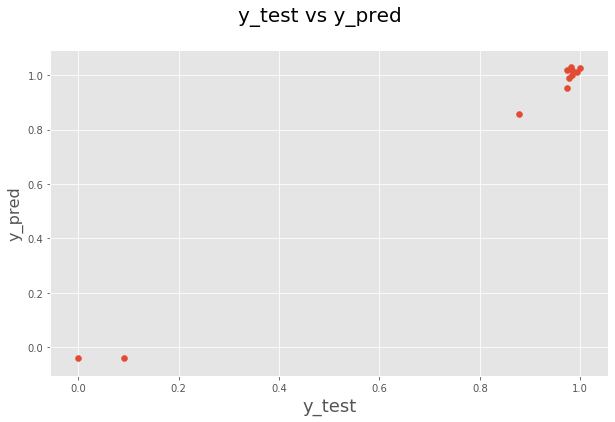

In [406]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)

### Elasticity Analysis

In [408]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_lm, y_train, coefficients_df)

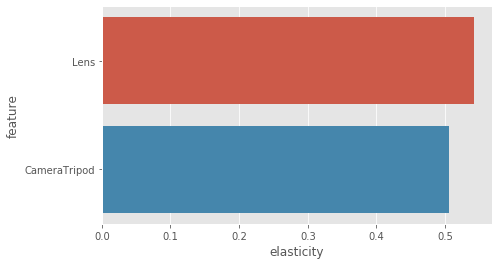

In [409]:
plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

### III. Home Audio - Multiplicative model

In [437]:
final_home_audio_data_with_adstock.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,adStock_Radio,adStock_Other,gmv,units,sla,product_procurement_sla,product_mrp,selling_price,discount,NPS,total_transactions,total_holiday,is_holiday,total_special_sale_day,is_special_sale_day,total_pay_days,is_pay_days,COD_count,Prepaid_count,pct_online_transactions,BoomBox,DJController,Dock,DockingStation,FMRadio,HiFiSystem,HomeAudioSpeaker,SlingBox,SoundMixer,VoiceRecorder
0,27,7,2015,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0,7.366000e+04,32,3.093750,3.718750,4108.406250,2301.875000,0.384688,54.599588,32,1.0,1.0,0.0,0.0,1.0,1.0,1.0,31,0.97,4.0,0.0,0.0,0.0,2.0,0.0,26.0,0.0,0.0,0.0
1,28,7,2015,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,0.0,0.0,3.394594e+06,1888,7.618513,2.797753,3024.204387,1810.233886,0.335811,54.599588,1869,0.0,0.0,0.0,0.0,0.0,0.0,1442.0,427,0.23,60.0,0.0,30.0,1.0,478.0,13.0,1281.0,0.0,0.0,25.0
2,29,7,2015,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,0.0,0.0,4.012062e+06,2204,7.157391,2.723084,3158.978558,1824.581204,0.349612,54.599588,2192,0.0,0.0,2.0,1.0,1.0,1.0,1718.0,474,0.22,57.0,0.0,50.0,1.0,532.0,27.0,1511.0,0.0,0.0,26.0
3,30,7,2015,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,0.0,0.0,3.560271e+06,2004,7.137966,2.802618,3155.295065,1781.471803,0.348036,54.599588,1986,0.0,0.0,0.0,0.0,0.0,0.0,1588.0,398,0.20,65.0,0.0,56.0,0.0,509.0,20.0,1332.0,0.0,0.0,22.0
4,31,8,2015,0.052078,0.913194,2.003552,0.000220,0.343392,0.146684,1.805811,0.0,0.0,2.588403e+06,1419,7.291076,2.683428,3180.561615,1827.348442,0.345241,54.599588,1412,0.0,0.0,0.0,0.0,1.0,1.0,1117.0,295,0.21,37.0,0.0,44.0,0.0,372.0,11.0,939.0,0.0,0.0,16.0


In [438]:
# Creating df with removal of features uncontrollable by the company, also, replacing 0.0 with lowest value to handle infinity given by log
df = np.log(
    final_home_audio_data_with_adstock.replace(0.0, 0.000001).drop(
        ['selling_price','units','product_mrp','total_transactions','COD_count', 'Prepaid_count'], 
        axis = 1
    )
)

In [439]:
# Test-train split
df_train, df_test = train_test_split(df, train_size = 0.8, test_size = 0.2, random_state = 100)

In [440]:
scaler = MinMaxScaler()

In [441]:
# Checking columns
df.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_holiday',
       'is_holiday', 'total_special_sale_day', 'is_special_sale_day',
       'total_pay_days', 'is_pay_days', 'pct_online_transactions', 'BoomBox',
       'DJController', 'Dock', 'DockingStation', 'FMRadio', 'HiFiSystem',
       'HomeAudioSpeaker', 'SlingBox', 'SoundMixer', 'VoiceRecorder'],
      dtype='object')

In [442]:
# Apply scaler() to all the columns except the categorical ones
num_vars = [
    'adStock_TV', 'adStock_Digital',
    'adStock_Sponsorship', 'adStock_Content Marketing',
    'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
    'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
    'product_procurement_sla', 'discount', 'NPS', 'total_holiday',
    'total_special_sale_day',
    'total_pay_days', 'pct_online_transactions', 'BoomBox',
    'DJController', 'Dock', 'DockingStation', 'FMRadio', 'HiFiSystem',
    'HomeAudioSpeaker', 'SlingBox', 'SoundMixer', 'VoiceRecorder'
]

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [443]:
y_train = df_train.pop('gmv')
X_train = df_train

In [444]:
# Running RFE for selecting top 12 features
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 12)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [445]:
# Extracting selected columns by RFE into a list
col = X_train.columns[rfe.support_]
col

Index(['Year', 'adStock_TV', 'adStock_Sponsorship', 'adStock_Online marketing',
       'adStock_ Affiliates', 'adStock_Radio', 'adStock_Other', 'sla',
       'FMRadio', 'HiFiSystem', 'HomeAudioSpeaker', 'VoiceRecorder'],
      dtype='object')

In [446]:
#Columns not supported by RFE
X_train.columns[~rfe.support_]

Index(['order_week', 'Month', 'adStock_Digital', 'adStock_Content Marketing',
       'adStock_SEM', 'product_procurement_sla', 'discount', 'NPS',
       'total_holiday', 'is_holiday', 'total_special_sale_day',
       'is_special_sale_day', 'total_pay_days', 'is_pay_days',
       'pct_online_transactions', 'BoomBox', 'DJController', 'Dock',
       'DockingStation', 'SlingBox', 'SoundMixer'],
      dtype='object')

In [447]:
# Creating dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [448]:
# Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    
# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3093.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           4.26e-39
Time:                        22:52:49   Log-Likelihood:                 167.80
No. Observations:                  40   AIC:                            -309.6
Df Residuals:                      27   BIC:                            -287.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
0,const,1.771571e+11
5,adStock_ Affiliates,2.599730e+03
4,adStock_Online marketing,2.426360e+03
7,adStock_Other,1.947590e+03
6,adStock_Radio,1.485630e+03
1,Year,1.878700e+02
10,HiFiSystem,8.265000e+01
12,VoiceRecorder,7.282000e+01
2,adStock_TV,6.799000e+01
9,FMRadio,3.254000e+01


In [449]:
# Let's drop feature with highest p-value
X_train_new = X_train_rfe.drop(["adStock_Online marketing"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new)
    
# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3483.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           7.43e-41
Time:                        22:53:01   Log-Likelihood:                 167.71
No. Observations:                  40   AIC:                            -311.4
Df Residuals:                      28   BIC:                            -291.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1144.7600    

,Features,VIF
0,const,1.544312e+11
6,adStock_Other,1.931170e+03
5,adStock_Radio,1.406040e+03
1,Year,1.637700e+02
9,HiFiSystem,7.207000e+01
11,VoiceRecorder,6.699000e+01
2,adStock_TV,5.600000e+01
4,adStock_ Affiliates,4.232000e+01
8,FMRadio,3.251000e+01
10,HomeAudioSpeaker,1.164000e+01


In [450]:
# Let's drop feature with highest p-value
X_train_new1 = X_train_new.drop(["VoiceRecorder"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new1)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3926.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.33e-42
Time:                        22:53:10   Log-Likelihood:                 167.49
No. Observations:                  40   AIC:                            -313.0
Df Residuals:                      29   BIC:                            -294.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1215.6608    

,Features,VIF
0,const,1.198387e+11
6,adStock_Other,1.515870e+03
5,adStock_Radio,1.156130e+03
1,Year,1.270900e+02
2,adStock_TV,4.728000e+01
4,adStock_ Affiliates,3.618000e+01
8,FMRadio,3.002000e+01
9,HiFiSystem,1.509000e+01
10,HomeAudioSpeaker,1.100000e+01
7,sla,8.780000e+00


In [451]:
# Let's drop feature with highest vif values
X_train_new2 = X_train_new1.drop(["adStock_Other"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new2)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     2846.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.91e-41
Time:                        22:53:40   Log-Likelihood:                 158.28
No. Observations:                  40   AIC:                            -296.6
Df Residuals:                      30   BIC:                            -279.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -672.2293    

,Features,VIF
0,const,8.244878e+10
1,Year,8.744000e+01
5,adStock_Radio,8.217000e+01
7,FMRadio,2.517000e+01
4,adStock_ Affiliates,1.611000e+01
8,HiFiSystem,1.431000e+01
2,adStock_TV,1.388000e+01
9,HomeAudioSpeaker,1.047000e+01
6,sla,8.090000e+00
3,adStock_Sponsorship,3.490000e+00


In [452]:
# Let's remove feature with highest p-value
X_train_new3 = X_train_new2.drop(["adStock_Sponsorship"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new3)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3308.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           3.21e-43
Time:                        22:53:51   Log-Likelihood:                 158.28
No. Observations:                  40   AIC:                            -298.6
Df Residuals:                      31   BIC:                            -283.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -672.7360    

,Features,VIF
0,const,8.237262e+10
1,Year,8.735000e+01
4,adStock_Radio,8.167000e+01
6,FMRadio,2.242000e+01
3,adStock_ Affiliates,1.609000e+01
7,HiFiSystem,1.395000e+01
2,adStock_TV,1.269000e+01
8,HomeAudioSpeaker,9.430000e+00
5,sla,6.260000e+00


In [453]:
# Let's drop feature with higest p-value
X_train_new4 = X_train_new3.drop(["adStock_ Affiliates"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new4)
    
# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3900.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           4.95e-45
Time:                        22:54:20   Log-Likelihood:                 158.27
No. Observations:                  40   AIC:                            -300.5
Df Residuals:                      32   BIC:                            -287.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -665.0947    227.033  

,Features,VIF
0,const,7.701884e+10
1,Year,8.168000e+01
3,adStock_Radio,7.513000e+01
5,FMRadio,2.235000e+01
6,HiFiSystem,1.314000e+01
7,HomeAudioSpeaker,9.360000e+00
4,sla,5.650000e+00
2,adStock_TV,1.840000e+00


In [454]:
X_train_new5 = X_train_new4.drop(["HiFiSystem"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new5)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     4460.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.59e-46
Time:                        22:54:41   Log-Likelihood:                 157.25
No. Observations:                  40   AIC:                            -300.5
Df Residuals:                      33   BIC:                            -288.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -802.5969    202.518  

,Features,VIF
0,const,6.007002e+10
1,Year,6.370000e+01
3,adStock_Radio,6.247000e+01
5,FMRadio,1.657000e+01
6,HomeAudioSpeaker,8.710000e+00
4,sla,5.500000e+00
2,adStock_TV,1.790000e+00


In [455]:
# Let's drop feature with higest p-value
X_train_new6 = X_train_new5.drop(["Year"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new6)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     3734.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.51e-45
Time:                        22:55:04   Log-Likelihood:                 149.47
No. Observations:                  40   AIC:                            -286.9
Df Residuals:                      34   BIC:                            -276.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0061      0.006  

,Features,VIF
0,const,34.57
4,FMRadio,14.63
5,HomeAudioSpeaker,7.47
3,sla,5.02
1,adStock_TV,1.78
2,adStock_Radio,1.43


In [456]:
# Let's drop feature with higest p-value
X_train_new7= X_train_new6.drop(["adStock_Radio"], axis = 1)

# Add a constant
X_train_lm = sm.add_constant(X_train_new7)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     4401.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           9.43e-47
Time:                        22:55:15   Log-Likelihood:                 147.72
No. Observations:                  40   AIC:                            -285.4
Df Residuals:                      35   BIC:                            -277.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0079      0.006  

,Features,VIF
0,const,33.57
3,FMRadio,14.29
4,HomeAudioSpeaker,7.46
2,sla,4.08
1,adStock_TV,1.77


In [457]:
# dropping the feature with highest vif values
X_train_new8= X_train_new7.drop(["FMRadio"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new8)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     2200.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           8.04e-41
Time:                        22:55:32   Log-Likelihood:                 127.61
No. Observations:                  40   AIC:                            -247.2
Df Residuals:                      36   BIC:                            -240.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0225      0.009  

,Features,VIF
0,const,30.17
3,HomeAudioSpeaker,2.01
2,sla,1.58
1,adStock_TV,1.46


In [458]:
# Let's drop feature with higest VIF
X_train_new9= X_train_new8.drop(["adStock_TV"], axis = 1)

# Add a constant
X_train_lm = sm.add_constant(X_train_new9)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     3352.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.52e-42
Time:                        22:55:51   Log-Likelihood:                 127.37
No. Observations:                  40   AIC:                            -248.7
Df Residuals:                      37   BIC:                            -243.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0233      0.009  

,Features,VIF
0,const,29.64
1,sla,1.38
2,HomeAudioSpeaker,1.38


In [459]:
# k-fold Cross validation
lm = LinearRegression()
scores = cross_val_score(lm, X_train_lm, y_train, scoring='r2', cv=10)
scores.mean()

0.8849813801208593

#### Residual Analysis

In [461]:
y_train_price = lr.predict(X_train_lm)

Text(0.5, 0, 'Errors')

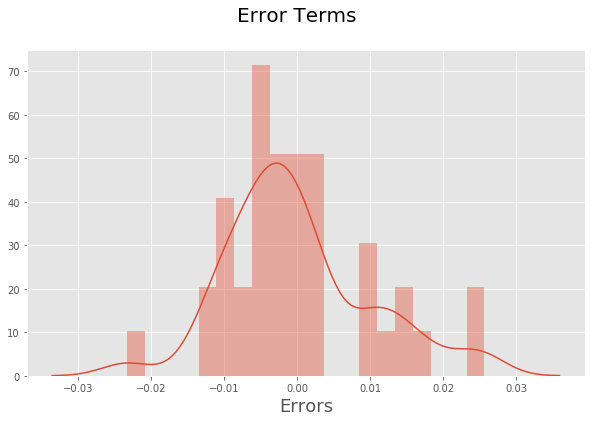

In [462]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

### Elasticity

In [463]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_lm, y_train, coefficients_df)

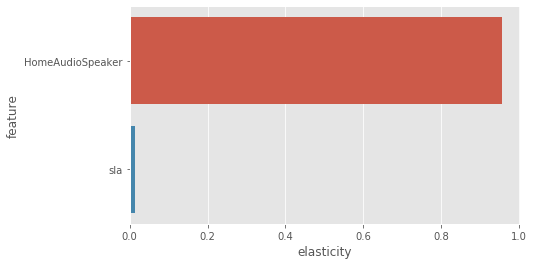

In [464]:
plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

### Model Evaluation

In [465]:
X_test = df_test
y_test = df_test.pop('gmv')

In [466]:
X_test = X_test[X_train_lm.drop('const', axis = 1).columns]
X_test = sm.add_constant(X_test)
X_test

,const,sla,HomeAudioSpeaker
6,1.0,0.429915,0.887885
36,1.0,0.390431,0.896755
37,1.0,0.473084,0.876060
28,1.0,0.255891,1.000000
43,1.0,0.291969,0.876738
49,1.0,0.000000,0.790585
5,1.0,1.000000,0.000000
33,1.0,0.363384,0.982409
20,1.0,0.268393,0.994778
42,1.0,0.302368,0.890951


In [467]:
# Making predictions using the fourth model
y_pred = lr.predict(X_test)

Text(0, 0.5, 'y_pred')

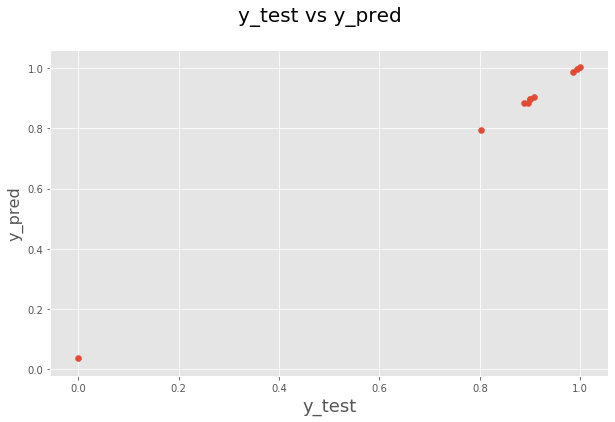

In [468]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)

### Building the Kyock's Models

In [469]:
# Function to create lagged GMV for each of the categories for creating this model
def createKyockKPI(df):
    df['gmv_lag'] = df['gmv'].shift(1)
    return df.fillna(0)

### I. Gaming Accessory - Kyock's model

In [470]:
# Creating the lagged KPI i.e. lagged_GMV for Kyock Model
df = createKyockKPI(final_gaming_data_with_adstock)

In [471]:
# Keeping only those features which can be controlled by the company 
df = df.drop(['selling_price','units','product_mrp','total_transactions','COD_count', 'Prepaid_count'], axis = 1)

In [472]:
df.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,adStock_Radio,adStock_Other,gmv,sla,product_procurement_sla,discount,NPS,total_holiday,is_holiday,total_special_sale_day,is_special_sale_day,total_pay_days,is_pay_days,pct_online_transactions,CoolingPad,GameControlMount,GamePad,GamingAccessoryKit,GamingAdapter,GamingChargingStation,GamingHeadset,GamingKeyboard,GamingMemoryCard,GamingMouse,GamingMousePad,GamingSpeaker,JoystickGamingWheel,MotionController,TVOutCableAccessory,gmv_lag
0,27,7,2015,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0,2.234400e+04,3.458333,3.208333,0.316250,54.599588,1.0,1.0,0.0,0.0,1.0,1.0,1.00,0.0,0.0,14.0,2.0,0.0,0.0,2.0,1.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.000000e+00
1,28,7,2015,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,0.0,0.0,1.866719e+06,5.375094,3.245660,0.421543,54.599588,0.0,0.0,0.0,0.0,0.0,0.0,0.26,0.0,0.0,861.0,100.0,48.0,0.0,177.0,424.0,36.0,966.0,55.0,0.0,11.0,16.0,73.0,2.234400e+04
2,29,7,2015,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,0.0,0.0,1.585166e+06,5.268747,2.721119,0.451228,54.599588,0.0,0.0,2.0,1.0,1.0,1.0,0.23,0.0,0.0,1647.0,129.0,44.0,0.0,179.0,162.0,27.0,357.0,48.0,0.0,8.0,11.0,92.0,1.866719e+06
3,30,7,2015,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,0.0,0.0,1.722134e+06,5.459259,2.592130,0.398009,54.599588,0.0,0.0,0.0,0.0,0.0,0.0,0.22,0.0,0.0,921.0,166.0,35.0,0.0,283.0,170.0,28.0,448.0,67.0,0.0,9.0,11.0,93.0,1.585166e+06
4,31,8,2015,0.052078,0.913194,2.003552,0.000220,0.343392,0.146684,1.805811,0.0,0.0,1.298391e+06,5.713094,3.237484,0.464647,54.603046,0.0,0.0,0.0,0.0,1.0,1.0,0.20,0.0,0.0,611.0,95.0,31.0,0.0,424.0,71.0,11.0,232.0,39.0,1.0,17.0,8.0,79.0,1.722134e+06


In [473]:
df_train, df_test = train_test_split(df, train_size = 0.8, test_size = 0.20, random_state = 100)

In [474]:
scaler = MinMaxScaler()

In [475]:
df.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_holiday',
       'is_holiday', 'total_special_sale_day', 'is_special_sale_day',
       'total_pay_days', 'is_pay_days', 'pct_online_transactions',
       'CoolingPad', 'GameControlMount', 'GamePad', 'GamingAccessoryKit',
       'GamingAdapter', 'GamingChargingStation', 'GamingHeadset',
       'GamingKeyboard', 'GamingMemoryCard', 'GamingMouse', 'GamingMousePad',
       'GamingSpeaker', 'JoystickGamingWheel', 'MotionController',
       'TVOutCableAccessory', 'gmv_lag'],
      dtype='object')

In [476]:
num_vars = [
    'adStock_TV', 'adStock_Digital',
    'adStock_Sponsorship', 'adStock_Content Marketing',
    'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
    'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
    'product_procurement_sla', 'discount', 'NPS', 'total_holiday',
    'total_special_sale_day', 
    'total_pay_days','pct_online_transactions',
    'CoolingPad', 'GameControlMount', 'GamePad', 'GamingAccessoryKit',
    'GamingAdapter', 'GamingChargingStation', 'GamingHeadset',
    'GamingKeyboard', 'GamingMemoryCard', 'GamingMouse', 'GamingMousePad',
    'GamingSpeaker', 'JoystickGamingWheel', 'MotionController',
    'TVOutCableAccessory', 'gmv_lag'
]

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [477]:
y_train = df_train.pop('gmv')
X_train = df_train

In [478]:
# Running RFE for selecting top 12 features
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 12)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [479]:
#Columns which are supported by RFE
col = X_train.columns[rfe.support_]
col

Index(['adStock_TV', 'adStock_Digital', 'adStock_Sponsorship',
       'adStock_Online marketing', 'adStock_SEM', 'adStock_Radio',
       'adStock_Other', 'NPS', 'GamingAccessoryKit', 'GamingHeadset',
       'GamingMemoryCard', 'GamingMouse'],
      dtype='object')

In [480]:
#Columns which are not supported by RFE
X_train.columns[~rfe.support_]

Index(['order_week', 'Month', 'Year', 'adStock_Content Marketing',
       'adStock_ Affiliates', 'sla', 'product_procurement_sla', 'discount',
       'total_holiday', 'is_holiday', 'total_special_sale_day',
       'is_special_sale_day', 'total_pay_days', 'is_pay_days',
       'pct_online_transactions', 'CoolingPad', 'GameControlMount', 'GamePad',
       'GamingAdapter', 'GamingChargingStation', 'GamingKeyboard',
       'GamingMousePad', 'GamingSpeaker', 'JoystickGamingWheel',
       'MotionController', 'TVOutCableAccessory', 'gmv_lag'],
      dtype='object')

In [481]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [482]:
# Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    
# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     85.50
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           2.75e-19
Time:                        23:03:52   Log-Likelihood:                 91.701
No. Observations:                  42   AIC:                            -157.4
Df Residuals:                      29   BIC:                            -134.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
5,adStock_SEM,1290.35
2,adStock_Digital,1010.65
6,adStock_Radio,781.09
7,adStock_Other,753.52
0,const,146.82
1,adStock_TV,74.03
4,adStock_Online marketing,51.26
3,adStock_Sponsorship,17.48
8,NPS,10.07
10,GamingHeadset,7.75


In [483]:
# Let's drop feature with highest p-value
X_train_new= X_train_rfe.drop(["adStock_Online marketing"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new)
   
# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     91.68
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           5.69e-20
Time:                        23:04:36   Log-Likelihood:                 90.657
No. Observations:                  42   AIC:                            -157.3
Df Residuals:                      30   BIC:                            -136.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0627    

,Features,VIF
4,adStock_SEM,1282.70
2,adStock_Digital,996.65
5,adStock_Radio,552.89
6,adStock_Other,531.83
0,const,108.55
1,adStock_TV,32.16
3,adStock_Sponsorship,15.06
7,NPS,5.95
10,GamingMemoryCard,4.85
9,GamingHeadset,3.34


In [484]:
# Let's drop feature with highest p-value
X_train_new1 = X_train_new.drop(["NPS"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new1)
    
# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     103.0
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           6.45e-21
Time:                        23:05:05   Log-Likelihood:                 90.410
No. Observations:                  42   AIC:                            -158.8
Df Residuals:                      31   BIC:                            -139.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0750    

,Features,VIF
4,adStock_SEM,1100.32
2,adStock_Digital,849.72
5,adStock_Radio,490.77
6,adStock_Other,470.03
0,const,92.13
1,adStock_TV,29.24
3,adStock_Sponsorship,14.83
9,GamingMemoryCard,4.85
8,GamingHeadset,3.26
10,GamingMouse,2.54


In [485]:
# Let's drop feature with highest p-value
X_train_new2 = X_train_new1.drop(["adStock_TV"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new2)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     108.1
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           2.22e-21
Time:                        23:05:39   Log-Likelihood:                 88.620
No. Observations:                  42   AIC:                            -157.2
Df Residuals:                      32   BIC:                            -139.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0037    

,Features,VIF
3,adStock_SEM,166.90
1,adStock_Digital,125.49
4,adStock_Radio,40.34
5,adStock_Other,31.75
0,const,19.77
2,adStock_Sponsorship,9.97
7,GamingHeadset,2.75
9,GamingMouse,2.51
6,GamingAccessoryKit,2.46
8,GamingMemoryCard,2.39


In [486]:
# Let's remove feature with highest VIF
X_train_new3 = X_train_new2.drop(["GamingMemoryCard"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new3)
    
# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     121.2
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           3.30e-22
Time:                        23:06:13   Log-Likelihood:                 87.917
No. Observations:                  42   AIC:                            -157.8
Df Residuals:                      33   BIC:                            -142.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0051    

,Features,VIF
3,adStock_SEM,138.11
1,adStock_Digital,103.19
4,adStock_Radio,36.69
5,adStock_Other,26.10
0,const,17.13
2,adStock_Sponsorship,9.24
7,GamingHeadset,2.73
8,GamingMouse,2.51
6,GamingAccessoryKit,2.46


In [487]:
# Let's drop feature with higest p-value
X_train_new4 = X_train_new3.drop(["adStock_Digital"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new4)
    
# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     130.3
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.17e-22
Time:                        23:06:46   Log-Likelihood:                 86.070
No. Observations:                  42   AIC:                            -156.1
Df Residuals:                      34   BIC:                            -142.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0320    

,Features,VIF
3,adStock_Radio,11.67
4,adStock_Other,11.32
0,const,8.31
1,adStock_Sponsorship,4.94
2,adStock_SEM,4.60
6,GamingHeadset,2.67
7,GamingMouse,2.46
5,GamingAccessoryKit,2.34


In [488]:
# Let's drop feature with highest p-value
X_train_new5 = X_train_new4.drop(["adStock_Other"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new5)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     153.5
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.22e-23
Time:                        23:07:07   Log-Likelihood:                 85.688
No. Observations:                  42   AIC:                            -157.4
Df Residuals:                      35   BIC:                            -145.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0306    

,Features,VIF
0,const,8.20
1,adStock_Sponsorship,4.90
2,adStock_SEM,4.56
5,GamingHeadset,2.67
6,GamingMouse,2.45
4,GamingAccessoryKit,2.29
3,adStock_Radio,1.34


In [489]:
# Let's drop feature with highest p-value
X_train_new6 = X_train_new5.drop(["adStock_Sponsorship"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new6)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     177.9
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           2.49e-24
Time:                        23:07:32   Log-Likelihood:                 84.413
No. Observations:                  42   AIC:                            -156.8
Df Residuals:                      36   BIC:                            -146.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0345      0

,Features,VIF
0,const,7.94
4,GamingHeadset,2.66
5,GamingMouse,2.39
3,GamingAccessoryKit,1.83
1,adStock_SEM,1.49
2,adStock_Radio,1.27


In [493]:
# k-fold Cross validation
lm = LinearRegression()
scores = cross_val_score(lm, X_train_lm, y_train, scoring='r2', cv=5)
scores.mean()

0.9075828566415727

### Residual Analysis

In [494]:
y_train_price = lr.predict(X_train_lm)

Text(0.5, 0, 'Errors')

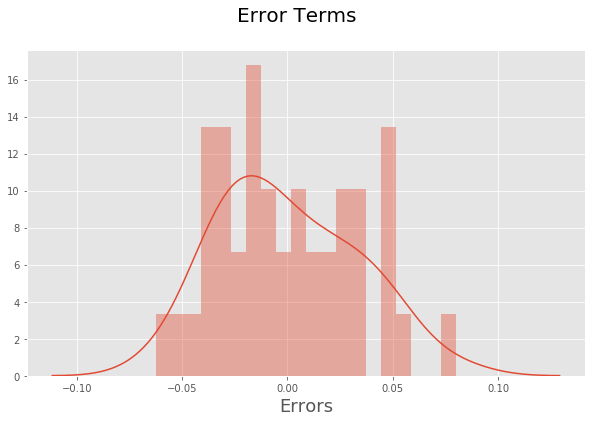

In [495]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

### Model Evaluation

In [496]:
X_test = df_test
y_test = df_test.pop('gmv')

In [497]:
X_test = X_test[X_train_lm.drop('const', axis = 1).columns]
X_test = sm.add_constant(X_test)
X_test.head()

,const,adStock_SEM,adStock_Radio,GamingAccessoryKit,GamingHeadset,GamingMouse
25,1.0,0.679923,0.000000,0.931193,0.856222,0.610843
48,1.0,0.241883,0.420988,1.000000,0.511881,0.516867
52,1.0,0.029384,0.013580,0.472477,0.220701,0.159036
37,1.0,0.164123,0.481185,0.972477,0.361257,0.331325
6,1.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [498]:
# Making predictions using the fourth model
y_pred = lr.predict(X_test)

Text(0, 0.5, 'y_pred')

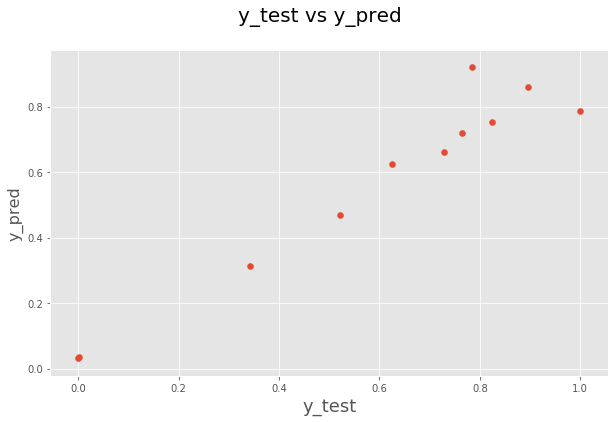

In [499]:
## Plotting y_test and y_pred to understand the spread
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)

### Elasticity

In [501]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_lm, y_train, coefficients_df)

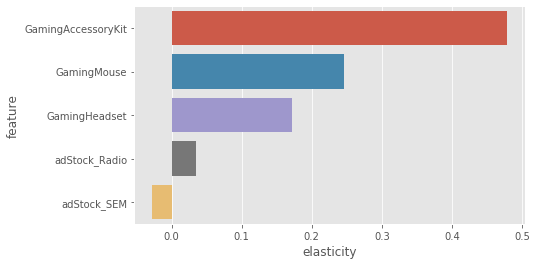

In [502]:
plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

### II. Camera Accessory - Kyock's Model

In [503]:
# adding lag variable in the camera data set
df = createKyockKPI(final_camera_data_with_adstock)
df.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,adStock_Radio,adStock_Other,gmv,units,sla,product_procurement_sla,product_mrp,selling_price,discount,NPS,total_transactions,total_holiday,is_holiday,total_special_sale_day,is_special_sale_day,total_pay_days,is_pay_days,COD_count,Prepaid_count,pct_online_transactions,Binoculars,CameraAccessory,CameraBag,CameraBattery,CameraBatteryCharger,CameraBatteryGrip,CameraEyeCup,CameraFilmRolls,CameraHousing,CameraMicrophone,CameraMount,CameraRemoteControl,CameraTripod,ExtensionTube,Filter,Flash,FlashShoeAdapter,Lens,ReflectorUmbrella,Softbox,Strap,Telescope,gmv_lag
0,27,7,2015,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0,15375.0,25,2.280000,2.960000,1456.840000,615.000000,0.525600,54.599588,25,1.0,1.0,0.0,0.0,1.0,1.0,0.0,25.0,1.00,1.0,1.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
1,28,7,2015,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,0.0,0.0,2019042.0,2752,7.156274,2.742586,1646.428137,751.233460,0.462194,54.599588,2630,0.0,0.0,0.0,0.0,0.0,0.0,1796.0,834.0,0.32,193.0,45.0,328.0,735.0,224.0,11.0,0.0,0.0,0.0,0.0,4.0,141.0,433.0,0.0,226.0,17.0,0.0,366.0,0.0,0.0,13.0,16.0,15375.0
2,29,7,2015,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,0.0,0.0,2249245.0,2917,6.491321,2.764789,1630.936238,783.509033,0.465349,54.599588,2823,0.0,0.0,2.0,1.0,1.0,1.0,1906.0,917.0,0.32,247.0,30.0,351.0,770.0,228.0,5.0,0.0,0.0,0.0,0.0,11.0,145.0,491.0,0.0,188.0,23.0,0.0,382.0,0.0,0.0,24.0,22.0,2019042.0
3,30,7,2015,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,0.0,0.0,2105858.0,2888,6.488138,2.831776,1560.504313,740.930625,0.455913,54.599588,2782,0.0,0.0,0.0,0.0,0.0,0.0,1914.0,868.0,0.31,209.0,44.0,284.0,812.0,270.0,9.0,0.0,0.0,0.0,0.0,7.0,108.0,457.0,0.0,194.0,18.0,0.0,423.0,0.0,0.0,23.0,30.0,2249245.0
4,31,8,2015,0.052078,0.913194,2.003552,0.000220,0.343392,0.146684,1.805811,0.0,0.0,1426134.0,1932,6.470684,2.777959,1524.232356,756.820304,0.450456,54.605438,1842,0.0,0.0,0.0,0.0,1.0,1.0,1315.0,527.0,0.29,144.0,41.0,175.0,516.0,194.0,8.0,0.0,0.0,0.0,0.0,2.0,82.0,363.0,0.0,112.0,26.0,0.0,233.0,0.0,0.0,23.0,13.0,2105858.0


In [504]:
# Dropping the features which cannot be handled by the company
df = df.drop(
    ['selling_price','units','product_mrp','total_transactions','COD_count', 'Prepaid_count'], 
    axis = 1
)

In [505]:
# Test-train split
df_train, df_test = train_test_split(df, train_size = 0.8, test_size = 0.2, random_state = 100)

In [506]:
scaler = MinMaxScaler()

In [507]:
df.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_holiday',
       'is_holiday', 'total_special_sale_day', 'is_special_sale_day',
       'total_pay_days', 'is_pay_days', 'pct_online_transactions',
       'Binoculars', 'CameraAccessory', 'CameraBag', 'CameraBattery',
       'CameraBatteryCharger', 'CameraBatteryGrip', 'CameraEyeCup',
       'CameraFilmRolls', 'CameraHousing', 'CameraMicrophone', 'CameraMount',
       'CameraRemoteControl', 'CameraTripod', 'ExtensionTube', 'Filter',
       'Flash', 'FlashShoeAdapter', 'Lens', 'ReflectorUmbrella', 'Softbox',
       'Strap', 'Telescope', 'gmv_lag'],
      dtype='object')

In [508]:
# Apply scaler() to all the columns except the categoriacal variables
num_vars=[
    'adStock_TV', 'adStock_Digital',
    'adStock_Sponsorship', 'adStock_Content Marketing',
    'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
    'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
    'product_procurement_sla', 'discount', 'NPS', 'total_holiday',
    'total_special_sale_day', 
    'total_pay_days', 'pct_online_transactions',
    'Binoculars', 'CameraAccessory', 'CameraBag', 'CameraBattery',
    'CameraBatteryCharger', 'CameraBatteryGrip', 'CameraEyeCup',
    'CameraFilmRolls', 'CameraHousing', 'CameraMicrophone', 'CameraMount',
    'CameraRemoteControl', 'CameraTripod', 'ExtensionTube', 'Filter',
    'Flash', 'FlashShoeAdapter', 'Lens', 'ReflectorUmbrella', 'Softbox',
    'Strap', 'Telescope', 'gmv_lag'
]

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [509]:
y_train = df_train.pop('gmv')
X_train = df_train

In [510]:
# Running RFE for selecting top 12 features
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 12)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [511]:
# selecting the features given by rfe
col = X_train.columns[rfe.support_]
col

Index(['adStock_Digital', 'adStock_Online marketing', 'adStock_ Affiliates',
       'adStock_SEM', 'adStock_Radio', 'adStock_Other',
       'product_procurement_sla', 'discount', 'CameraBag', 'CameraBattery',
       'CameraTripod', 'Flash'],
      dtype='object')

In [512]:
# negelecting features not selected by rfe
X_train.columns[~rfe.support_]

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Sponsorship',
       'adStock_Content Marketing', 'sla', 'NPS', 'total_holiday',
       'is_holiday', 'total_special_sale_day', 'is_special_sale_day',
       'total_pay_days', 'is_pay_days', 'pct_online_transactions',
       'Binoculars', 'CameraAccessory', 'CameraBatteryCharger',
       'CameraBatteryGrip', 'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing',
       'CameraMicrophone', 'CameraMount', 'CameraRemoteControl',
       'ExtensionTube', 'Filter', 'FlashShoeAdapter', 'Lens',
       'ReflectorUmbrella', 'Softbox', 'Strap', 'Telescope', 'gmv_lag'],
      dtype='object')

In [513]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [514]:
# Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    
# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     261.3
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           2.02e-25
Time:                        23:16:03   Log-Likelihood:                 113.81
No. Observations:                  41   AIC:                            -201.6
Df Residuals:                      28   BIC:                            -179.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Features,VIF
2,adStock_Online marketing,543.46
4,adStock_SEM,405.26
3,adStock_ Affiliates,388.02
1,adStock_Digital,294.86
0,const,51.97
5,adStock_Radio,49.34
6,adStock_Other,43.94
12,Flash,8.51
10,CameraBattery,7.14
9,CameraBag,6.91


In [515]:
# Let's drop feature with highest vif values
X_train_new = X_train_rfe.drop(["adStock_Online marketing"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new)
    
# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     257.6
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           8.04e-26
Time:                        23:17:15   Log-Likelihood:                 111.04
No. Observations:                  41   AIC:                            -198.1
Df Residuals:                      29   BIC:                            -177.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

,Features,VIF
3,adStock_SEM,194.17
1,adStock_Digital,168.37
0,const,46.07
4,adStock_Radio,43.03
5,adStock_Other,40.97
11,Flash,8.50
2,adStock_ Affiliates,7.69
8,CameraBag,6.24
9,CameraBattery,5.65
10,CameraTripod,4.48


In [516]:
# # Let's drop feature  with highest p-value 
X_train_new1 = X_train_new.drop(["adStock_ Affiliates"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new1)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     291.7
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           4.87e-27
Time:                        23:17:42   Log-Likelihood:                 110.94
No. Observations:                  41   AIC:                            -199.9
Df Residuals:                      30   BIC:                            -181.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

,Features,VIF
2,adStock_SEM,57.92
1,adStock_Digital,56.57
0,const,32.82
3,adStock_Radio,30.72
4,adStock_Other,26.83
10,Flash,7.69
7,CameraBag,5.98
8,CameraBattery,5.51
9,CameraTripod,4.47
6,discount,4.14


In [517]:
# Let's drop feature  with highest p-value
X_train_new2 = X_train_new1.drop(["adStock_SEM"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new2)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     237.9
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           4.76e-26
Time:                        23:18:14   Log-Likelihood:                 104.01
No. Observations:                  41   AIC:                            -188.0
Df Residuals:                      31   BIC:                            -170.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

,Features,VIF
0,const,31.82
2,adStock_Radio,20.26
3,adStock_Other,18.54
9,Flash,6.66
6,CameraBag,5.89
7,CameraBattery,5.42
5,discount,4.07
8,CameraTripod,3.77
1,adStock_Digital,1.90
4,product_procurement_sla,1.68


In [518]:
# Let's drop feature  with highest p-value 
X_train_new3 = X_train_new2.drop(["adStock_Digital"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new3)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     276.3
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           2.76e-27
Time:                        23:19:47   Log-Likelihood:                 104.01
No. Observations:                  41   AIC:                            -190.0
Df Residuals:                      32   BIC:                            -174.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

,Features,VIF
0,const,31.10
1,adStock_Radio,19.17
2,adStock_Other,17.90
8,Flash,6.65
5,CameraBag,5.45
6,CameraBattery,4.97
4,discount,3.89
7,CameraTripod,2.94
3,product_procurement_sla,1.68


In [519]:
# Let's drop feature  with highest p-value 
X_train_new4 = X_train_new3.drop(["CameraBattery"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new4)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     303.8
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           4.49e-28
Time:                        23:20:24   Log-Likelihood:                 102.62
No. Observations:                  41   AIC:                            -189.2
Df Residuals:                      33   BIC:                            -175.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

,Features,VIF
0,const,27.51
1,adStock_Radio,14.90
2,adStock_Other,14.44
7,Flash,5.56
4,discount,3.41
5,CameraBag,3.29
6,CameraTripod,2.62
3,product_procurement_sla,1.64


In [520]:
# Let's drop feature  with highest vif values
X_train_new5 = X_train_new4.drop(["adStock_Radio"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new5)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     298.2
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           6.58e-28
Time:                        23:21:10   Log-Likelihood:                 98.531
No. Observations:                  41   AIC:                            -183.1
Df Residuals:                      34   BIC:                            -171.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

,Features,VIF
0,const,26.57
6,Flash,5.52
3,discount,3.21
4,CameraBag,2.91
5,CameraTripod,2.39
2,product_procurement_sla,1.64
1,adStock_Other,1.46


In [521]:
# Let's drop feature  with highest  vif
X_train_new6 = X_train_new5.drop(["adStock_Other"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new6)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     353.7
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           6.51e-29
Time:                        23:21:40   Log-Likelihood:                 97.711
No. Observations:                  41   AIC:                            -183.4
Df Residuals:                      35   BIC:                            -173.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

,Features,VIF
0,const,24.97
5,Flash,4.15
2,discount,2.89
3,CameraBag,2.67
4,CameraTripod,2.33
1,product_procurement_sla,1.64


In [524]:
# Let's drop feature  with highest  vif
X_train_new7 = X_train_new6.drop(["Flash"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new7)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     81.48
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.56e-17
Time:                        23:24:23   Log-Likelihood:                 64.211
No. Observations:                  41   AIC:                            -118.4
Df Residuals:                      36   BIC:                            -109.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

,Features,VIF
0,const,24.97
2,discount,1.71
4,CameraTripod,1.69
3,CameraBag,1.51
1,product_procurement_sla,1.47


In [525]:
# Let's drop feature  with highest p-values
X_train_new8 = X_train_new7.drop(["product_procurement_sla"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new8)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     111.4
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.40e-18
Time:                        23:25:16   Log-Likelihood:                 64.167
No. Observations:                  41   AIC:                            -120.3
Df Residuals:                      37   BIC:                            -113.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0632      0.023      2.768   

,Features,VIF
0,const,7.54
2,CameraBag,1.50
3,CameraTripod,1.39
1,discount,1.29


In [526]:
# Let's drop feature  with highest p-values
X_train_new9 = X_train_new8.drop(["discount"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new9)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     170.6
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.04e-19
Time:                        23:25:47   Log-Likelihood:                 64.059
No. Observations:                  41   AIC:                            -122.1
Df Residuals:                      38   BIC:                            -117.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0680      0.020      3.412   

,Features,VIF
0,const,5.86
1,CameraBag,1.34
2,CameraTripod,1.34


In [527]:
# k-fold Cross validation
lm = LinearRegression()
scores = cross_val_score(lm, X_train_lm, y_train, scoring='r2', cv=5)
scores.mean()

0.7864078742131128

#### Residual Analysis

In [528]:
y_train_price = lr.predict(X_train_lm)

Text(0.5, 0, 'Errors')

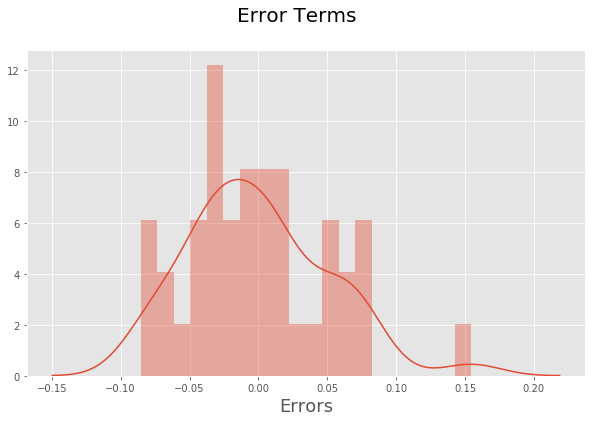

In [529]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

### Model Evaluation

In [530]:
y_test = df_test.pop('gmv')
X_test = df_test

In [531]:
X_test.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'sla', 'product_procurement_sla',
       'discount', 'NPS', 'total_holiday', 'is_holiday',
       'total_special_sale_day', 'is_special_sale_day', 'total_pay_days',
       'is_pay_days', 'pct_online_transactions', 'Binoculars',
       'CameraAccessory', 'CameraBag', 'CameraBattery', 'CameraBatteryCharger',
       'CameraBatteryGrip', 'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing',
       'CameraMicrophone', 'CameraMount', 'CameraRemoteControl',
       'CameraTripod', 'ExtensionTube', 'Filter', 'Flash', 'FlashShoeAdapter',
       'Lens', 'ReflectorUmbrella', 'Softbox', 'Strap', 'Telescope',
       'gmv_lag'],
      dtype='object')

In [532]:
X_test = X_test[X_train_lm.drop('const', axis = 1).columns]
X_test = sm.add_constant(X_test)
X_test

,const,CameraBag,CameraTripod
6,1.0,0.000000,0.000000
32,1.0,0.697674,0.969427
38,1.0,0.739535,0.713376
35,1.0,0.806977,0.791083
33,1.0,0.727907,0.960510
51,1.0,0.455814,0.110828
5,1.0,0.000000,0.000000
26,1.0,0.616279,1.000000
25,1.0,0.662791,0.854777
45,1.0,1.000000,0.537580


In [533]:
# Making predictions using the final model
y_pred = lr.predict(X_test)

Text(0, 0.5, 'y_pred')

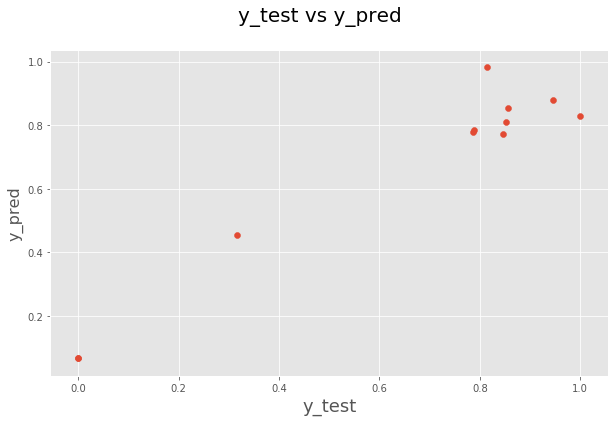

In [534]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)

### Elasticity

In [535]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_lm, y_train, coefficients_df)

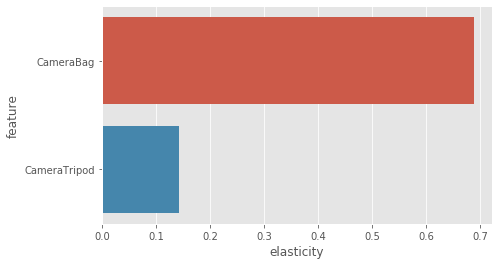

In [536]:
plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

### III. Home Audio - Kyock's model

In [537]:
# creating dataset with lag gmv feature
df = createKyockKPI(final_home_audio_data_with_adstock)
df.head()

,order_week,Month,Year,adStock_TV,adStock_Digital,adStock_Sponsorship,adStock_Content Marketing,adStock_Online marketing,adStock_ Affiliates,adStock_SEM,adStock_Radio,adStock_Other,gmv,units,sla,product_procurement_sla,product_mrp,selling_price,discount,NPS,total_transactions,total_holiday,is_holiday,total_special_sale_day,is_special_sale_day,total_pay_days,is_pay_days,COD_count,Prepaid_count,pct_online_transactions,BoomBox,DJController,Dock,DockingStation,FMRadio,HiFiSystem,HomeAudioSpeaker,SlingBox,SoundMixer,VoiceRecorder,gmv_lag
0,27,7,2015,0.053833,0.633253,1.853567,0.000233,0.331819,0.136813,1.255924,0.0,0.0,7.366000e+04,32,3.093750,3.718750,4108.406250,2301.875000,0.384688,54.599588,32,1.0,1.0,0.0,0.0,1.0,1.0,1.0,31,0.97,4.0,0.0,0.0,0.0,2.0,0.0,26.0,0.0,0.0,0.0,0.000000e+00
1,28,7,2015,0.080749,0.949880,2.780351,0.000350,0.497729,0.205220,1.883887,0.0,0.0,3.394594e+06,1888,7.618513,2.797753,3024.204387,1810.233886,0.335811,54.599588,1869,0.0,0.0,0.0,0.0,0.0,0.0,1442.0,427,0.23,60.0,0.0,30.0,1.0,478.0,13.0,1281.0,0.0,0.0,25.0,7.366000e+04
2,29,7,2015,0.094207,1.108193,3.243743,0.000408,0.580684,0.239424,2.197868,0.0,0.0,4.012062e+06,2204,7.157391,2.723084,3158.978558,1824.581204,0.349612,54.599588,2192,0.0,0.0,2.0,1.0,1.0,1.0,1718.0,474,0.22,57.0,0.0,50.0,1.0,532.0,27.0,1511.0,0.0,0.0,26.0,3.394594e+06
3,30,7,2015,0.100936,1.187350,3.475439,0.000437,0.622161,0.256525,2.354858,0.0,0.0,3.560271e+06,2004,7.137966,2.802618,3155.295065,1781.471803,0.348036,54.599588,1986,0.0,0.0,0.0,0.0,0.0,0.0,1588.0,398,0.20,65.0,0.0,56.0,0.0,509.0,20.0,1332.0,0.0,0.0,22.0,4.012062e+06
4,31,8,2015,0.052078,0.913194,2.003552,0.000220,0.343392,0.146684,1.805811,0.0,0.0,2.588403e+06,1419,7.291076,2.683428,3180.561615,1827.348442,0.345241,54.599588,1412,0.0,0.0,0.0,0.0,1.0,1.0,1117.0,295,0.21,37.0,0.0,44.0,0.0,372.0,11.0,939.0,0.0,0.0,16.0,3.560271e+06


In [538]:
# dropping the uncrollable feature
df = df.drop(
    ['selling_price','units','product_mrp','total_transactions','COD_count', 'Prepaid_count'], 
    axis = 1
)

In [539]:
df.columns

Index(['order_week', 'Month', 'Year', 'adStock_TV', 'adStock_Digital',
       'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_holiday',
       'is_holiday', 'total_special_sale_day', 'is_special_sale_day',
       'total_pay_days', 'is_pay_days', 'pct_online_transactions', 'BoomBox',
       'DJController', 'Dock', 'DockingStation', 'FMRadio', 'HiFiSystem',
       'HomeAudioSpeaker', 'SlingBox', 'SoundMixer', 'VoiceRecorder',
       'gmv_lag'],
      dtype='object')

In [540]:
# Test-train split
df_train, df_test = train_test_split(df, train_size = 0.8, test_size = 0.2, random_state = 100)

In [541]:
scaler = MinMaxScaler()

In [542]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = [
    'adStock_TV', 'adStock_Digital',
    'adStock_Sponsorship', 'adStock_Content Marketing',
    'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
    'adStock_Radio', 'adStock_Other', 'gmv', 'sla',
    'product_procurement_sla', 'discount', 'NPS', 'total_holiday',
    'total_special_sale_day',
    'total_pay_days', 'pct_online_transactions', 'BoomBox',
    'DJController', 'Dock', 'DockingStation', 'FMRadio', 'HiFiSystem',
    'HomeAudioSpeaker', 'SlingBox', 'SoundMixer', 'VoiceRecorder',
    'gmv_lag'
]

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [543]:
y_train = df_train.pop('gmv')
X_train = df_train

In [544]:
# Running RFE for selecting top 12 features
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 12)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [545]:
#selected the top 20 feature given by rfe
col = X_train.columns[rfe.support_]
col

Index(['adStock_TV', 'adStock_Sponsorship', 'adStock_Content Marketing',
       'adStock_Online marketing', 'adStock_ Affiliates', 'adStock_SEM',
       'adStock_Radio', 'adStock_Other', 'pct_online_transactions', 'FMRadio',
       'HomeAudioSpeaker', 'VoiceRecorder'],
      dtype='object')

In [546]:
# neglecting the feature not selected by rfe
X_train.columns[~rfe.support_]

Index(['order_week', 'Month', 'Year', 'adStock_Digital', 'sla',
       'product_procurement_sla', 'discount', 'NPS', 'total_holiday',
       'is_holiday', 'total_special_sale_day', 'is_special_sale_day',
       'total_pay_days', 'is_pay_days', 'BoomBox', 'DJController', 'Dock',
       'DockingStation', 'HiFiSystem', 'SlingBox', 'SoundMixer', 'gmv_lag'],
      dtype='object')

In [547]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [548]:
# Add a constant
X_train_lm = sm.add_constant(X_train_rfe)
    
# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1628.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           2.43e-35
Time:                        23:30:33   Log-Likelihood:                 152.61
No. Observations:                  40   AIC:                            -279.2
Df Residuals:                      27   BIC:                            -257.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
8,adStock_Other,1423.04
4,adStock_Online marketing,1047.77
7,adStock_Radio,992.97
5,adStock_ Affiliates,898.28
3,adStock_Content Marketing,635.62
6,adStock_SEM,463.45
1,adStock_TV,312.28
2,adStock_Sponsorship,89.04
0,const,65.93
9,pct_online_transactions,5.91


In [549]:
# Let's drop feature  with highest p-value
X_train_new = X_train_rfe.drop(["adStock_Sponsorship"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new)
    
# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1833.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           5.86e-37
Time:                        23:31:03   Log-Likelihood:                 152.51
No. Observations:                  40   AIC:                            -281.0
Df Residuals:                      28   BIC:                            -260.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
3,adStock_Online marketing,1033.70
4,adStock_ Affiliates,665.60
7,adStock_Other,391.76
6,adStock_Radio,330.18
2,adStock_Content Marketing,169.88
5,adStock_SEM,128.74
1,adStock_TV,43.66
0,const,24.81
9,FMRadio,4.74
10,HomeAudioSpeaker,3.24


In [550]:
# Let's drop feature with highest p-value
X_train_new1 = X_train_new.drop(["adStock_SEM"], axis = 1)
 
# Add a constantDockingStation
X_train_lm = sm.add_constant(X_train_new1)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     2073.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.39e-38
Time:                        23:31:20   Log-Likelihood:                 152.36
No. Observations:                  40   AIC:                            -282.7
Df Residuals:                      29   BIC:                            -264.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
3,adStock_Online marketing,516.34
4,adStock_ Affiliates,379.63
5,adStock_Radio,147.50
6,adStock_Other,147.13
0,const,20.62
1,adStock_TV,17.86
2,adStock_Content Marketing,9.06
8,FMRadio,4.72
9,HomeAudioSpeaker,3.16
7,pct_online_transactions,2.50


In [552]:
# drop the features with highest vif values
X_train_new2 = X_train_new1.drop(["adStock_Online marketing"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new2)
    
# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1691.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           4.64e-38
Time:                        23:32:15   Log-Likelihood:                 145.51
No. Observations:                  40   AIC:                            -271.0
Df Residuals:                      30   BIC:                            -254.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
4,adStock_Radio,65.51
5,adStock_Other,63.27
0,const,17.55
1,adStock_TV,13.04
3,adStock_ Affiliates,9.03
7,FMRadio,4.15
8,HomeAudioSpeaker,3.03
2,adStock_Content Marketing,2.86
6,pct_online_transactions,1.73
9,VoiceRecorder,1.40


In [553]:
# Let's remove feature  with highest p-value
X_train_new3 = X_train_new2.drop(["adStock_ Affiliates"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new3)
    
# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1930.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.34e-39
Time:                        23:33:14   Log-Likelihood:                 145.15
No. Observations:                  40   AIC:                            -272.3
Df Residuals:                      31   BIC:                            -257.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
3,adStock_Radio,24.34
4,adStock_Other,24.28
0,const,15.11
6,FMRadio,3.85
7,HomeAudioSpeaker,2.80
2,adStock_Content Marketing,2.78
1,adStock_TV,2.68
8,VoiceRecorder,1.38
5,pct_online_transactions,1.36


In [554]:
# Let's drop feature with higest p-value
X_train_new4 = X_train_new3.drop(["adStock_TV"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new4)
    
# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     2268.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           2.85e-41
Time:                        23:33:47   Log-Likelihood:                 145.07
No. Observations:                  40   AIC:                            -274.1
Df Residuals:                      32   BIC:                            -260.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,Features,VIF
2,adStock_Radio,14.96
3,adStock_Other,13.41
0,const,12.85
5,FMRadio,3.81
6,HomeAudioSpeaker,2.78
1,adStock_Content Marketing,1.78
4,pct_online_transactions,1.31
7,VoiceRecorder,1.29


In [555]:
X_train_new5 = X_train_new4.drop(["adStock_Content Marketing"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new5)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     2704.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           6.04e-43
Time:                        23:34:20   Log-Likelihood:                 144.89
No. Observations:                  40   AIC:                            -275.8
Df Residuals:                      33   BIC:                            -264.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

,Features,VIF
1,adStock_Radio,14.31
2,adStock_Other,13.08
0,const,12.58
4,FMRadio,3.22
5,HomeAudioSpeaker,2.75
3,pct_online_transactions,1.31
6,VoiceRecorder,1.19


In [556]:
X_train_new6 = X_train_new5.drop(["adStock_Radio"], axis = 1)
 
# Add a constant
X_train_lm = sm.add_constant(X_train_new6)
    
lr = sm.OLS(y_train, X_train_lm).fit()

lr.params
print(lr.summary())
vif = pd.DataFrame()
vif['Features'] = X_train_lm .columns
vif['VIF'] = [variance_inflation_factor(X_train_lm .values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     3303.
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           1.21e-44
Time:                        23:34:46   Log-Likelihood:                 144.65
No. Observations:                  40   AIC:                            -277.3
Df Residuals:                      34   BIC:                            -267.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

,Features,VIF
0,const,11.98
3,FMRadio,2.90
4,HomeAudioSpeaker,2.63
1,adStock_Other,1.34
2,pct_online_transactions,1.27
5,VoiceRecorder,1.15


In [557]:
# k-fold Cross validation
lm = LinearRegression()
scores = cross_val_score(lm, X_train_lm, y_train, scoring='r2', cv=5)
scores.mean()

0.9882408150971338

### Residual Analysis

In [558]:
y_train_price = lr.predict(X_train_lm)

Text(0.5, 0, 'Errors')

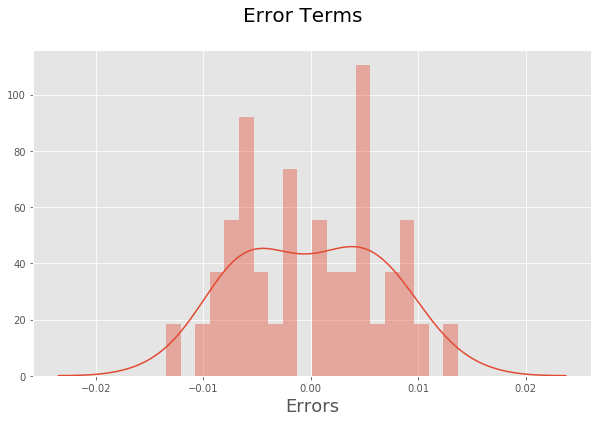

In [559]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

### Model evaluation

In [561]:
X_test = df_test
y_test = df_test.pop('gmv')

In [562]:
X_test = X_test[X_train_lm.drop('const', axis = 1).columns]
X_test = sm.add_constant(X_test)
X_test

,const,adStock_Other,pct_online_transactions,FMRadio,HomeAudioSpeaker,VoiceRecorder
6,1.0,0.000000,0.081395,0.833648,0.416162,0.375000
36,1.0,0.470891,0.441860,0.720227,0.446061,0.894231
37,1.0,0.235445,0.941860,0.725898,0.379394,0.894231
28,1.0,1.000000,0.011628,0.897921,1.000000,0.730769
43,1.0,0.368180,0.058140,0.551985,0.381414,1.000000
49,1.0,0.006136,0.023256,0.164461,0.194343,0.240385
5,1.0,0.000000,1.000000,0.000000,0.000000,0.000000
33,1.0,0.753426,0.093023,1.000000,0.871515,0.798077
20,1.0,0.000000,0.000000,0.843100,0.960000,0.394231
42,1.0,0.343635,0.046512,0.642722,0.426263,0.932692


In [563]:
# Making predictions using the fourth model
y_pred = lr.predict(X_test)

Text(0, 0.5, 'y_pred')

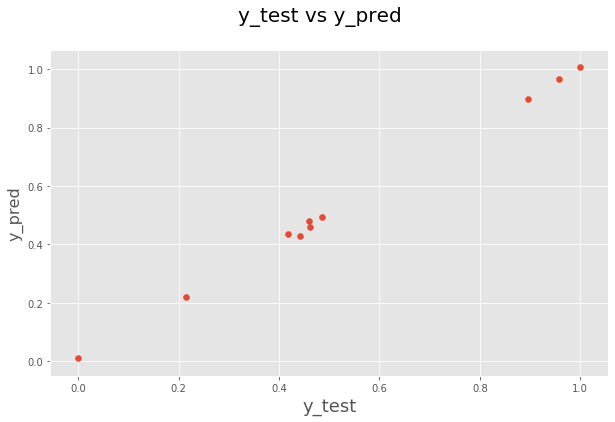

In [564]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)

### Elasticity

In [566]:
coefficients_df = pd.DataFrame(pd.DataFrame(lr.params)[1:]).reset_index()
coefficients_df.columns = ['feature','coefficient']
elasticity_data = calculateElasticity(X_train_lm, y_train, coefficients_df)

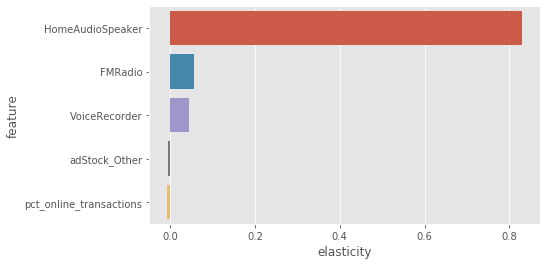

In [567]:
plt.figure(figsize = (7,4))
sns.barplot(x = 'elasticity',y ='feature',data = elasticity_data.sort_values('elasticity', ascending = False))

## Best Models for each category

### GamingAccessory

#### Kyock's Model
    1. Highest Adjusted R-square
    2. Low MSE value
    3. Features on which company can act upon:
        * GamingMouse
        * GamingHeadset
        * GamingAccessoryKit
        * adStock_Radio
        * adStock_SEM

### CameraAccessory

#### Kyock's Model
    1. Highest Adjusted R-square
    2. Low MSE value
    3. Features on which company can act upon:
        * Camerabag
        * CameraTripod
        

### HomeAudio

#### Kyock's Model
    1. Highest Adjusted R-square
    2. Low MSE value
    3. Features on which company can act upon:
        * HomeAudioSpeaker
        * FMRadio
        * VoiceRecorder
        * adStock_Other
        * pct_online_transactions
        